In [1]:
import tldextract
import gzip
import re
from tqdm.notebook import tqdm, trange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tqdm.pandas()

/home/daniil_boiko/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
train = pd.read_csv('data/train.marks.tsv/train.marks.tsv', sep='\t', header=None)
test = pd.read_csv('data/sample.csv/sample.csv')

In [4]:
train.columns = list(test.columns) + ['Target']

In [5]:
url_data = pd.read_csv('data/url.data/url.data', sep='\t', header=None)

url_data[2] = url_data[1].progress_map(lambda x: tldextract.extract(x))
url_data[3] = url_data[2].map(lambda x: x[2])

for i, (k, v) in enumerate(url_data[3].value_counts()[:5].iteritems()):
    url_data[k] = (url_data[3] == k).astype(int)

url_data['porn'] = url_data[1].map(lambda x: 'porn' in x or 'xxx' in x or 'sex' in x).astype(int)
url_data['news'] = url_data[1].map(lambda x: 'news' in x or 'paper' in x or 'journal' in x or 'magazine' in x).astype(int)
url_data['forum'] = url_data[1].map(lambda x: 'topic' in x or 'forum' in x).astype(int)

url_data = url_data.drop(columns=[1, 2, 3])

In [6]:
train = pd.merge(train, url_data, left_on=['DocumentId'], right_on=[0]).drop(columns=[0])
test = pd.merge(test, url_data, left_on=['DocumentId'], right_on=[0]).drop(columns=[0])

Text(0, 0.5, 'Test')

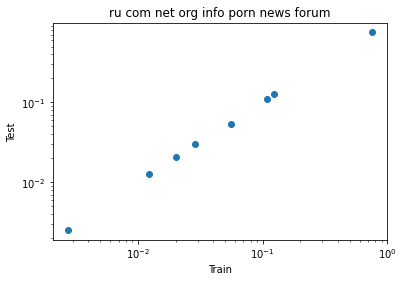

In [7]:
plt.scatter(
    train.mean()[['ru', 'com', 'net', 'org', 'info', 'porn', 'news', 'forum']],
    test.mean()[['ru', 'com', 'net', 'org', 'info', 'porn', 'news', 'forum']],
)
plt.title(' '.join(['ru', 'com', 'net', 'org', 'info', 'porn', 'news', 'forum']))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Train')
plt.ylabel('Test')

In [8]:
list(train.columns)

['QueryId',
 'DocumentId',
 'Target',
 'ru',
 'com',
 'net',
 'org',
 'info',
 'porn',
 'news',
 'forum']

In [9]:
title_embeds = np.load('data/title_embeds.npy')
body_embeds = np.load('data/body_embeds.npy')
query_embeds = np.load('data/query_embeds.npy')

In [10]:
title_embeds.shape, body_embeds.shape, query_embeds.shape

((582167, 512), (582167, 512), (6311, 512))

In [11]:
def add_embed_fc(dset, prefix = ''):
    title_embed_scores = []
    body_embed_scores = []
    
    for row_id, row in tqdm(dset.iterrows(), total=len(dset)):  
        title_embed_scores.append(
            np.inner(
                title_embeds[int(row['DocumentId'])],
                query_embeds[int(row['QueryId'])]
            )
        )
        
        body_embed_scores.append(
            np.inner(
                body_embeds[int(row['DocumentId'])],
                query_embeds[int(row['QueryId'])]
            )
        )
        
    dset[prefix+'_title_USE'] = title_embed_scores
    dset[prefix+'_body_USE'] = body_embed_scores

In [12]:
query_embeds = np.load('data/query_embeds_not_corrected.npy')

In [13]:
add_embed_fc(train, prefix='q_nc')

In [14]:
add_embed_fc(test, prefix='q_nc')

In [15]:
train['q_nc_USE_diff'] = train['q_nc_title_USE'] - train['q_nc_body_USE'] 
test['q_nc_USE_diff'] = test['q_nc_title_USE'] - test['q_nc_body_USE'] 

In [16]:
query_embeds = np.load('data/query_embeds.npy')

add_embed_fc(train, prefix='q')
add_embed_fc(test, prefix='q')

train['q_USE_diff'] = train['q_title_USE'] - train['q_body_USE'] 
test['q_USE_diff'] = test['q_title_USE'] - test['q_body_USE'] 

In [17]:
import pickle as pkl
with open('data/clicks.pkl', 'rb') as f:
    click_data = pkl.load(f)

In [18]:
train['ctr'] = train['DocumentId'].map(
    lambda x: click_data[x][1]/click_data[x][0] if x in click_data else -1
)

test['ctr'] = test['DocumentId'].map(
    lambda x: click_data[x][1]/click_data[x][0] if x in click_data else -1
)

train['shown'] = train['DocumentId'].map(
    lambda x: click_data[x][0] if x in click_data else -1
)

test['shown'] = test['DocumentId'].map(
    lambda x: click_data[x][0] if x in click_data else -1
)

In [19]:
import pickle as pkl
with open('data/clicks_domain.pkl', 'rb') as f:
    click_data_domain = pkl.load(f)

In [20]:
url_data_ = pd.read_csv('data/url.data/url.data', sep='\t', header=None)
url_data_[1] = url_data_[1].map(lambda x: tldextract.extract(x).domain)

In [21]:
url_data_ = url_data_[1].to_dict()

In [22]:
train['ctr_domain'] = train['DocumentId'].map(
    lambda x: click_data_domain[url_data_[x]][1]/click_data_domain[url_data_[x]][0] if url_data_[x] in click_data_domain else -1
)

test['ctr_domain'] = test['DocumentId'].map(
    lambda x: click_data_domain[url_data_[x]][1]/click_data_domain[url_data_[x]][0] if url_data_[x] in click_data_domain else -1
)

train['shown_domain'] = train['DocumentId'].map(
    lambda x: click_data_domain[url_data_[x]][0] if url_data_[x] in click_data_domain else -1
)

test['shown_domain'] = test['DocumentId'].map(
    lambda x: click_data_domain[url_data_[x]][0] if url_data_[x] in click_data_domain else -1
)

In [23]:
def get_query_ctr(x):
    if url_data_[x['DocumentId']] not in click_data_domain:
        return -1
    
    if x['QueryId'] not in click_data_domain[url_data_[x['DocumentId']]][2]:
        return -2
    
    return click_data_domain[url_data_[x['DocumentId']]][2][x['QueryId']][1] / click_data_domain[url_data_[x['DocumentId']]][2][x['QueryId']][0]

In [24]:
train['query_ctr'] = train.apply(get_query_ctr, axis=1)
test['query_ctr'] = test.apply(get_query_ctr, axis=1)

In [25]:
def get_query_ctr_nd(x):
    if x['DocumentId'] not in click_data:
        return -1
    
    if x['QueryId'] not in click_data[x['DocumentId']][2]:
        return -2
    
    return click_data[x['DocumentId']][2][x['QueryId']][1] / click_data[x['DocumentId']][2][x['QueryId']][0]

In [26]:
train['query_ctr_nd'] = train.apply(get_query_ctr_nd, axis=1)
test['query_ctr_nd'] = test.apply(get_query_ctr_nd, axis=1)

In [27]:
import pickle as pkl
with open('data/clicks_times_processed.pkl', 'rb') as f:
    click_data_times = pkl.load(f)

In [28]:
def get_average_position_domain(x):
    if url_data_[x['DocumentId']] not in click_data_times:
        return -1
    
    return click_data_times[url_data_[x['DocumentId']]][3]

def get_average_time_domain(x):
    if url_data_[x['DocumentId']] not in click_data_times:
        return -1
    
    return click_data_times[url_data_[x['DocumentId']]][4]

def get_average_query_position(x):
    if url_data_[x['DocumentId']] not in click_data_times:
        return -1
    
    if x['QueryId'] not in click_data_times[url_data_[x['DocumentId']]][2]:
        return -2
    
    return click_data_times[url_data_[x['DocumentId']]][2][x['QueryId']][2]

def get_average_query_time(x):
    if url_data_[x['DocumentId']] not in click_data_times:
        return -1
    
    if x['QueryId'] not in click_data_times[url_data_[x['DocumentId']]][2]:
        return -2
    
    return click_data_times[url_data_[x['DocumentId']]][2][x['QueryId']][3]

In [29]:
get_average_query_time.__name__[4:]

'average_query_time'

In [30]:
functions = [
    get_average_position_domain,
    get_average_time_domain,
    get_average_query_position,
    get_average_query_time,
]
for f in tqdm(functions):
    train[f.__name__[4:]] = train.progress_apply(f, axis=1)
    test[f.__name__[4:]] = test.progress_apply(f, axis=1)

In [31]:
train = train.fillna(-1)
test = test.fillna(-1)

In [32]:
train

,QueryId,DocumentId,Target,ru,com,net,org,info,porn,news,...,ctr,shown,ctr_domain,shown_domain,query_ctr,query_ctr_nd,average_position_domain,average_time_domain,average_query_position,average_query_time
0,2,135041,1,1,0,0,0,0,0,0,...,-1.000000,-1,0.162242,1356,-2.000000,-1.0,2.431373,129.485294,-2.000000,-2.000000
1,2,80518,1,0,0,0,0,1,0,0,...,-1.000000,-1,0.197117,74286,-2.000000,-1.0,2.695096,124.238887,-2.000000,-2.000000
2,2,434055,1,1,0,0,0,0,0,0,...,-1.000000,-1,0.086957,115,-2.000000,-1.0,4.125000,1523.875000,-2.000000,-2.000000
3,2,510856,0,1,0,0,0,0,0,0,...,-1.000000,-1,0.190476,21,-2.000000,-1.0,3.000000,1703.000000,-2.000000,-2.000000
4,2,458604,1,1,0,0,0,0,0,0,...,-1.000000,-1,0.159204,402,-2.000000,-1.0,3.677966,235.000000,-2.000000,-2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202074,6305,63981,3,0,1,0,0,0,0,0,...,-1.000000,-1,0.130265,184195009,0.096958,-1.0,1.265850,125.801656,2.157576,75.061538
202075,6305,354802,1,1,0,0,0,0,0,0,...,-1.000000,-1,0.137748,3020,-2.000000,-1.0,3.761084,144.293103,-2.000000,-2.000000
202076,6305,275960,4,1,0,0,0,0,0,0,...,-1.000000,-1,0.156817,445074,0.285714,-1.0,2.455246,138.046186,2.000000,155.000000
202077,6305,338427,4,1,0,0,0,0,0,0,...,0.031056,161,0.160863,136055810,0.041605,0.0,1.327870,98.936767,3.240000,0.000000


In [33]:
with open('data/queries.corrected.pkl', 'rb') as f:
    queries_dict = pkl.load(f)
    
queries_dict = queries_dict['lemmatized'].to_dict()

In [34]:
train['q_text'] = train['QueryId'].map(queries_dict)
test['q_text'] = test['QueryId'].map(queries_dict)

In [35]:
with open('data/title_mapper.pkl', 'rb') as f:
    titles_dict = pkl.load(f)

In [36]:
train['title_text'] = train['DocumentId'].map(titles_dict)
test['title_text'] = test['DocumentId'].map(titles_dict)

In [37]:
def extract_years(s):
    return set(re.findall('(\d{4})', s))

In [38]:
extract_years(train['q_text'][1000])

set()

In [39]:
def add_simple_text_features(x):
    q_text_tokenized = x['q_text'].map(lambda x: x.split()).to_list()
    title_text_tokenized = x['title_text'].map(lambda x: x.split()).to_list()
    
    f = {
        'n_q_words':[],
        'n_q_words_uniq':[],
        'n_title_words':[],
        'n_title_words_uniq':[],
        'n_diff':[],
        'n_diff_uniq':[],
        'n_same_words_q_title_uniq':[],
        'query_year': [],
        'title_year': [],
        'query_year_n': [],
        'title_year_n': [],
        'year_match': []
    }
    
    for i in trange(len(x)):
        f['n_q_words'].append(len(q_text_tokenized[i]))
        f['n_q_words_uniq'].append(len(set(q_text_tokenized[i])))
        
        f['n_title_words'].append(len(title_text_tokenized[i]))
        f['n_title_words_uniq'].append(len(set(title_text_tokenized[i])))
        
        f['n_diff'].append(f['n_q_words'][i] - f['n_title_words'][i])
        f['n_diff_uniq'].append(f['n_q_words_uniq'][i] - f['n_title_words_uniq'][i])
        
        f['n_same_words_q_title_uniq'].append(len(
            set(q_text_tokenized[i]).intersection(set(title_text_tokenized[i]))
        ))
        
        query_years = extract_years(x['q_text'][i])
        title_years = extract_years(x['title_text'][i])

        f['query_year'].append(list(query_years)[0] if query_years else -1)
        f['title_year'].append(list(title_years)[0] if title_years else -1)
        f['query_year_n'].append(len(query_years))
        f['title_year_n'].append(len(title_years))
        f['year_match'].append(len(query_years.intersection(title_years)))
        
    for k, v in f.items():
        x[k] =v

In [40]:
add_simple_text_features(train)
add_simple_text_features(test)

In [41]:
from gensim.summarization import bm25

In [42]:
gsbm = bm25.BM25(train['title_text'].to_list()+test['title_text'].to_list())

In [43]:
def add_bm25_score(x, mode='train'):
    scores = []
    offset = 0 if mode == 'train' else len(train)
    
    for i in trange(len(x)):
        scores.append(gsbm.get_score(x['q_text'][i], i+offset))
        
    x['title_bm25'] = scores

In [44]:
add_bm25_score(train)

In [45]:
add_bm25_score(test, 'not_train')

In [46]:
with open('data/google_scraping_dict.pkl', 'rb') as f:
    scraping_results = pkl.load(f)

In [47]:
def add_scraped(x):
    domains = x['DocumentId'].map(url_data_)
    
    positions = []
    for i in trange(len(x)):
        if domains[i] not in scraping_results[x['QueryId'][i]][1]:
            positions.append(-1)
        else:
            positions.append(scraping_results[x['QueryId'][i]][1].index(domains[i]))
    
    x['google_scraping'] = positions

In [48]:
add_scraped(train)
add_scraped(test)

In [49]:
import os
downloaded = os.listdir('data/docs/')
downloaded = {int(filename.split('.')[0]):os.path.getsize(f'data/docs/{filename}') for filename in downloaded}

In [50]:
train['exists'] = train['DocumentId'].map(lambda x: downloaded[x] if x in downloaded else -999)
test['exists'] = test['DocumentId'].map(lambda x: downloaded[x] if x in downloaded else -999)

In [51]:
with open('data/query_stats.pkl', 'rb') as f:
    query_stats = pkl.load(f)

In [52]:
for dataset in [train, test]:
    dataset['query_shows'] = dataset['QueryId'].map(lambda x: query_stats[x][0] if x in query_stats else -1)
    dataset['query_reading_mean_time'] = dataset['QueryId'].map(lambda x: query_stats[x][1] if x in query_stats else -1)
    dataset['query_page_time'] = dataset['QueryId'].map(lambda x: query_stats[x][2] if x in query_stats else -1)
    dataset['query_clicked_count'] = dataset['QueryId'].map(lambda x: query_stats[x][3] if x in query_stats else -1)


In [55]:
import pickle as pkl

with open('data/train_20210204.pkl', 'wb') as f:
    pkl.dump(train, f)
    
with open('data/test_20210204.pkl', 'wb') as f:
    pkl.dump(test, f)

In [53]:
import pandas as pd
import numpy as np
from catboost import CatBoost, Pool
from sklearn.model_selection import GroupShuffleSplit, GroupKFold

In [54]:
train['QueryId'] = train['QueryId'].astype(int)

In [55]:
train.sort_values('QueryId', inplace=True)

In [56]:
train_idx, test_idx = next(iter(GroupKFold(n_splits=10).split(train, groups = train['QueryId'])))

In [57]:
pools = {}

idx = {
    'train': train_idx,
    'test': test_idx
}

for type_ in ['train','test']:
      pools[type_] = Pool(train.iloc[idx[type_]].drop(columns=['QueryId','DocumentId', 'Target', 'q_text', 'title_text']).values,
                          train.iloc[idx[type_]]['Target'].values, 
                          group_id = train.iloc[idx[type_]]['QueryId'].values)
        

In [58]:
depths = []
etas = []
l2s = []
best_scores = []

for depth in [6]:
    for eta in [0.1]:
        for l2 in [0]:
            parameters = {
                'loss_function': 'YetiRankPairwise',
                'iterations': 10_000,
                'eval_metric': 'NDCG:top=5;type=Exp',
                'metric_period': 1,
                'thread_count': -1,
                'verbose': True,
                'random_seed': 0,
                'depth': depth,
                'eta': eta,
                'use_best_model': True,
                'l2_leaf_reg':l2
            }


            model_yeti = CatBoost(parameters)
            model_yeti.fit(pools['train'],
                        eval_set=pools['test'],
                        plot=False)
            
            depths.append(depth)
            etas.append(eta)
            l2s.append(l2)
            #best_scores.append(np.max(model.get_evals_result()['validation']['NDCG:top=10;type=Exp']))
            #print(np.max(best_scores))

0:	test: 0.5325499	best: 0.5325499 (0)	total: 530ms	remaining: 1h 28m 20s
1:	test: 0.5813415	best: 0.5813415 (1)	total: 1.05s	remaining: 1h 27m 34s
2:	test: 0.5963858	best: 0.5963858 (2)	total: 1.57s	remaining: 1h 27m 28s
3:	test: 0.5994729	best: 0.5994729 (3)	total: 2.1s	remaining: 1h 27m 33s
4:	test: 0.5997822	best: 0.5997822 (4)	total: 2.65s	remaining: 1h 28m 24s
5:	test: 0.6576207	best: 0.6576207 (5)	total: 3.21s	remaining: 1h 29m 1s
6:	test: 0.6571188	best: 0.6576207 (5)	total: 3.75s	remaining: 1h 29m 10s
7:	test: 0.6642603	best: 0.6642603 (7)	total: 4.29s	remaining: 1h 29m 20s
8:	test: 0.6670649	best: 0.6670649 (8)	total: 4.86s	remaining: 1h 29m 50s
9:	test: 0.6672569	best: 0.6672569 (9)	total: 5.4s	remaining: 1h 29m 58s
10:	test: 0.6669688	best: 0.6672569 (9)	total: 5.96s	remaining: 1h 30m 12s
11:	test: 0.6750080	best: 0.6750080 (11)	total: 6.52s	remaining: 1h 30m 27s
12:	test: 0.6754029	best: 0.6754029 (12)	total: 7.1s	remaining: 1h 30m 56s
13:	test: 0.6760581	best: 0.6760581 (

109:	test: 0.7399462	best: 0.7403119 (108)	total: 1m 5s	remaining: 1h 38m 3s
110:	test: 0.7399026	best: 0.7403119 (108)	total: 1m 6s	remaining: 1h 38m 4s
111:	test: 0.7399508	best: 0.7403119 (108)	total: 1m 6s	remaining: 1h 38m 4s
112:	test: 0.7378537	best: 0.7403119 (108)	total: 1m 7s	remaining: 1h 38m 4s
113:	test: 0.7386362	best: 0.7403119 (108)	total: 1m 7s	remaining: 1h 38m 4s
114:	test: 0.7387673	best: 0.7403119 (108)	total: 1m 8s	remaining: 1h 38m 4s
115:	test: 0.7360981	best: 0.7403119 (108)	total: 1m 9s	remaining: 1h 38m 1s
116:	test: 0.7382457	best: 0.7403119 (108)	total: 1m 9s	remaining: 1h 38m
117:	test: 0.7373731	best: 0.7403119 (108)	total: 1m 10s	remaining: 1h 37m 57s
118:	test: 0.7377876	best: 0.7403119 (108)	total: 1m 10s	remaining: 1h 37m 58s
119:	test: 0.7380776	best: 0.7403119 (108)	total: 1m 11s	remaining: 1h 37m 57s
120:	test: 0.7372545	best: 0.7403119 (108)	total: 1m 11s	remaining: 1h 37m 55s
121:	test: 0.7372545	best: 0.7403119 (108)	total: 1m 12s	remaining: 1h 

214:	test: 0.7443425	best: 0.7449529 (206)	total: 2m 8s	remaining: 1h 37m 6s
215:	test: 0.7434745	best: 0.7449529 (206)	total: 2m 8s	remaining: 1h 37m 7s
216:	test: 0.7438781	best: 0.7449529 (206)	total: 2m 9s	remaining: 1h 37m 6s
217:	test: 0.7444962	best: 0.7449529 (206)	total: 2m 9s	remaining: 1h 37m 6s
218:	test: 0.7450337	best: 0.7450337 (218)	total: 2m 10s	remaining: 1h 37m 6s
219:	test: 0.7442187	best: 0.7450337 (218)	total: 2m 11s	remaining: 1h 37m 6s
220:	test: 0.7441330	best: 0.7450337 (218)	total: 2m 11s	remaining: 1h 37m 4s
221:	test: 0.7437618	best: 0.7450337 (218)	total: 2m 12s	remaining: 1h 37m 4s
222:	test: 0.7447739	best: 0.7450337 (218)	total: 2m 12s	remaining: 1h 37m 4s
223:	test: 0.7447789	best: 0.7450337 (218)	total: 2m 13s	remaining: 1h 37m 3s
224:	test: 0.7444932	best: 0.7450337 (218)	total: 2m 14s	remaining: 1h 37m 3s
225:	test: 0.7446060	best: 0.7450337 (218)	total: 2m 14s	remaining: 1h 37m 2s
226:	test: 0.7446615	best: 0.7450337 (218)	total: 2m 15s	remaining: 

319:	test: 0.7443792	best: 0.7468542 (273)	total: 3m 10s	remaining: 1h 36m 8s
320:	test: 0.7442866	best: 0.7468542 (273)	total: 3m 11s	remaining: 1h 36m 8s
321:	test: 0.7445267	best: 0.7468542 (273)	total: 3m 11s	remaining: 1h 36m 7s
322:	test: 0.7441077	best: 0.7468542 (273)	total: 3m 12s	remaining: 1h 36m 6s
323:	test: 0.7444446	best: 0.7468542 (273)	total: 3m 13s	remaining: 1h 36m 6s
324:	test: 0.7449588	best: 0.7468542 (273)	total: 3m 13s	remaining: 1h 36m 5s
325:	test: 0.7448865	best: 0.7468542 (273)	total: 3m 14s	remaining: 1h 36m 4s
326:	test: 0.7442595	best: 0.7468542 (273)	total: 3m 14s	remaining: 1h 36m 3s
327:	test: 0.7449196	best: 0.7468542 (273)	total: 3m 15s	remaining: 1h 36m 2s
328:	test: 0.7447542	best: 0.7468542 (273)	total: 3m 16s	remaining: 1h 36m 1s
329:	test: 0.7452075	best: 0.7468542 (273)	total: 3m 16s	remaining: 1h 36m 1s
330:	test: 0.7452075	best: 0.7468542 (273)	total: 3m 17s	remaining: 1h 36m
331:	test: 0.7459259	best: 0.7468542 (273)	total: 3m 17s	remaining:

424:	test: 0.7484069	best: 0.7486424 (414)	total: 4m 13s	remaining: 1h 35m 5s
425:	test: 0.7484666	best: 0.7486424 (414)	total: 4m 13s	remaining: 1h 35m 5s
426:	test: 0.7484666	best: 0.7486424 (414)	total: 4m 14s	remaining: 1h 35m 5s
427:	test: 0.7484666	best: 0.7486424 (414)	total: 4m 15s	remaining: 1h 35m 5s
428:	test: 0.7484069	best: 0.7486424 (414)	total: 4m 15s	remaining: 1h 35m 5s
429:	test: 0.7483408	best: 0.7486424 (414)	total: 4m 16s	remaining: 1h 35m 5s
430:	test: 0.7486740	best: 0.7486740 (430)	total: 4m 16s	remaining: 1h 35m 5s
431:	test: 0.7486740	best: 0.7486740 (430)	total: 4m 17s	remaining: 1h 35m 4s
432:	test: 0.7482081	best: 0.7486740 (430)	total: 4m 18s	remaining: 1h 35m 4s
433:	test: 0.7482385	best: 0.7486740 (430)	total: 4m 18s	remaining: 1h 35m 4s
434:	test: 0.7486428	best: 0.7486740 (430)	total: 4m 19s	remaining: 1h 35m 3s
435:	test: 0.7485772	best: 0.7486740 (430)	total: 4m 20s	remaining: 1h 35m 3s
436:	test: 0.7485395	best: 0.7486740 (430)	total: 4m 20s	remaini

529:	test: 0.7511777	best: 0.7541399 (511)	total: 5m 15s	remaining: 1h 33m 56s
530:	test: 0.7511385	best: 0.7541399 (511)	total: 5m 16s	remaining: 1h 33m 56s
531:	test: 0.7511334	best: 0.7541399 (511)	total: 5m 16s	remaining: 1h 33m 55s
532:	test: 0.7511385	best: 0.7541399 (511)	total: 5m 17s	remaining: 1h 33m 54s
533:	test: 0.7513340	best: 0.7541399 (511)	total: 5m 17s	remaining: 1h 33m 53s
534:	test: 0.7513340	best: 0.7541399 (511)	total: 5m 18s	remaining: 1h 33m 53s
535:	test: 0.7513340	best: 0.7541399 (511)	total: 5m 19s	remaining: 1h 33m 52s
536:	test: 0.7512679	best: 0.7541399 (511)	total: 5m 19s	remaining: 1h 33m 52s
537:	test: 0.7513340	best: 0.7541399 (511)	total: 5m 20s	remaining: 1h 33m 51s
538:	test: 0.7510031	best: 0.7541399 (511)	total: 5m 20s	remaining: 1h 33m 51s
539:	test: 0.7510031	best: 0.7541399 (511)	total: 5m 21s	remaining: 1h 33m 50s
540:	test: 0.7511002	best: 0.7541399 (511)	total: 5m 22s	remaining: 1h 33m 50s
541:	test: 0.7511002	best: 0.7541399 (511)	total: 5m

634:	test: 0.7522334	best: 0.7541399 (511)	total: 6m 16s	remaining: 1h 32m 38s
635:	test: 0.7531619	best: 0.7541399 (511)	total: 6m 17s	remaining: 1h 32m 37s
636:	test: 0.7531619	best: 0.7541399 (511)	total: 6m 18s	remaining: 1h 32m 36s
637:	test: 0.7519835	best: 0.7541399 (511)	total: 6m 18s	remaining: 1h 32m 35s
638:	test: 0.7517569	best: 0.7541399 (511)	total: 6m 19s	remaining: 1h 32m 34s
639:	test: 0.7518006	best: 0.7541399 (511)	total: 6m 19s	remaining: 1h 32m 33s
640:	test: 0.7529740	best: 0.7541399 (511)	total: 6m 20s	remaining: 1h 32m 32s
641:	test: 0.7529740	best: 0.7541399 (511)	total: 6m 20s	remaining: 1h 32m 31s
642:	test: 0.7529740	best: 0.7541399 (511)	total: 6m 21s	remaining: 1h 32m 30s
643:	test: 0.7529740	best: 0.7541399 (511)	total: 6m 21s	remaining: 1h 32m 29s
644:	test: 0.7536010	best: 0.7541399 (511)	total: 6m 22s	remaining: 1h 32m 27s
645:	test: 0.7536010	best: 0.7541399 (511)	total: 6m 23s	remaining: 1h 32m 26s
646:	test: 0.7536010	best: 0.7541399 (511)	total: 6m

739:	test: 0.7564205	best: 0.7564205 (739)	total: 7m 17s	remaining: 1h 31m 19s
740:	test: 0.7564205	best: 0.7564205 (739)	total: 7m 18s	remaining: 1h 31m 18s
741:	test: 0.7560258	best: 0.7564205 (739)	total: 7m 19s	remaining: 1h 31m 18s
742:	test: 0.7560258	best: 0.7564205 (739)	total: 7m 19s	remaining: 1h 31m 17s
743:	test: 0.7562232	best: 0.7564205 (739)	total: 7m 20s	remaining: 1h 31m 16s
744:	test: 0.7562232	best: 0.7564205 (739)	total: 7m 20s	remaining: 1h 31m 15s
745:	test: 0.7562232	best: 0.7564205 (739)	total: 7m 21s	remaining: 1h 31m 14s
746:	test: 0.7562232	best: 0.7564205 (739)	total: 7m 21s	remaining: 1h 31m 14s
747:	test: 0.7562232	best: 0.7564205 (739)	total: 7m 22s	remaining: 1h 31m 13s
748:	test: 0.7563351	best: 0.7564205 (739)	total: 7m 23s	remaining: 1h 31m 13s
749:	test: 0.7563351	best: 0.7564205 (739)	total: 7m 23s	remaining: 1h 31m 12s
750:	test: 0.7560664	best: 0.7564205 (739)	total: 7m 24s	remaining: 1h 31m 11s
751:	test: 0.7559821	best: 0.7564205 (739)	total: 7m

844:	test: 0.7570356	best: 0.7587532 (794)	total: 8m 18s	remaining: 1h 30m 3s
845:	test: 0.7570356	best: 0.7587532 (794)	total: 8m 19s	remaining: 1h 30m 2s
846:	test: 0.7570356	best: 0.7587532 (794)	total: 8m 19s	remaining: 1h 30m 1s
847:	test: 0.7571679	best: 0.7587532 (794)	total: 8m 20s	remaining: 1h 30m 1s
848:	test: 0.7571679	best: 0.7587532 (794)	total: 8m 21s	remaining: 1h 30m
849:	test: 0.7571679	best: 0.7587532 (794)	total: 8m 21s	remaining: 1h 29m 59s
850:	test: 0.7571679	best: 0.7587532 (794)	total: 8m 22s	remaining: 1h 29m 58s
851:	test: 0.7571679	best: 0.7587532 (794)	total: 8m 22s	remaining: 1h 29m 58s
852:	test: 0.7570904	best: 0.7587532 (794)	total: 8m 23s	remaining: 1h 29m 57s
853:	test: 0.7568930	best: 0.7587532 (794)	total: 8m 23s	remaining: 1h 29m 57s
854:	test: 0.7568930	best: 0.7587532 (794)	total: 8m 24s	remaining: 1h 29m 56s
855:	test: 0.7577957	best: 0.7587532 (794)	total: 8m 25s	remaining: 1h 29m 56s
856:	test: 0.7577957	best: 0.7587532 (794)	total: 8m 25s	rem

949:	test: 0.7577620	best: 0.7587532 (794)	total: 9m 20s	remaining: 1h 28m 55s
950:	test: 0.7592049	best: 0.7592049 (950)	total: 9m 20s	remaining: 1h 28m 55s
951:	test: 0.7592049	best: 0.7592049 (950)	total: 9m 21s	remaining: 1h 28m 54s
952:	test: 0.7583890	best: 0.7592049 (950)	total: 9m 21s	remaining: 1h 28m 53s
953:	test: 0.7579611	best: 0.7592049 (950)	total: 9m 22s	remaining: 1h 28m 53s
954:	test: 0.7575234	best: 0.7592049 (950)	total: 9m 23s	remaining: 1h 28m 52s
955:	test: 0.7568964	best: 0.7592049 (950)	total: 9m 23s	remaining: 1h 28m 52s
956:	test: 0.7568913	best: 0.7592049 (950)	total: 9m 24s	remaining: 1h 28m 51s
957:	test: 0.7568913	best: 0.7592049 (950)	total: 9m 24s	remaining: 1h 28m 51s
958:	test: 0.7568252	best: 0.7592049 (950)	total: 9m 25s	remaining: 1h 28m 50s
959:	test: 0.7568252	best: 0.7592049 (950)	total: 9m 26s	remaining: 1h 28m 49s
960:	test: 0.7568252	best: 0.7592049 (950)	total: 9m 26s	remaining: 1h 28m 49s
961:	test: 0.7556411	best: 0.7592049 (950)	total: 9m

1053:	test: 0.7580089	best: 0.7592049 (950)	total: 10m 21s	remaining: 1h 27m 54s
1054:	test: 0.7579382	best: 0.7592049 (950)	total: 10m 22s	remaining: 1h 27m 54s
1055:	test: 0.7579382	best: 0.7592049 (950)	total: 10m 22s	remaining: 1h 27m 53s
1056:	test: 0.7581953	best: 0.7592049 (950)	total: 10m 23s	remaining: 1h 27m 53s
1057:	test: 0.7584166	best: 0.7592049 (950)	total: 10m 23s	remaining: 1h 27m 52s
1058:	test: 0.7587830	best: 0.7592049 (950)	total: 10m 24s	remaining: 1h 27m 52s
1059:	test: 0.7587830	best: 0.7592049 (950)	total: 10m 25s	remaining: 1h 27m 51s
1060:	test: 0.7587830	best: 0.7592049 (950)	total: 10m 25s	remaining: 1h 27m 50s
1061:	test: 0.7587830	best: 0.7592049 (950)	total: 10m 26s	remaining: 1h 27m 49s
1062:	test: 0.7587830	best: 0.7592049 (950)	total: 10m 26s	remaining: 1h 27m 49s
1063:	test: 0.7587830	best: 0.7592049 (950)	total: 10m 27s	remaining: 1h 27m 48s
1064:	test: 0.7580615	best: 0.7592049 (950)	total: 10m 27s	remaining: 1h 27m 47s
1065:	test: 0.7580788	best: 

1155:	test: 0.7588481	best: 0.7600270 (1137)	total: 11m 21s	remaining: 1h 26m 53s
1156:	test: 0.7588481	best: 0.7600270 (1137)	total: 11m 22s	remaining: 1h 26m 53s
1157:	test: 0.7588481	best: 0.7600270 (1137)	total: 11m 22s	remaining: 1h 26m 52s
1158:	test: 0.7584107	best: 0.7600270 (1137)	total: 11m 23s	remaining: 1h 26m 52s
1159:	test: 0.7584107	best: 0.7600270 (1137)	total: 11m 23s	remaining: 1h 26m 51s
1160:	test: 0.7579933	best: 0.7600270 (1137)	total: 11m 24s	remaining: 1h 26m 51s
1161:	test: 0.7579933	best: 0.7600270 (1137)	total: 11m 25s	remaining: 1h 26m 50s
1162:	test: 0.7579933	best: 0.7600270 (1137)	total: 11m 25s	remaining: 1h 26m 50s
1163:	test: 0.7579933	best: 0.7600270 (1137)	total: 11m 26s	remaining: 1h 26m 49s
1164:	test: 0.7577959	best: 0.7600270 (1137)	total: 11m 26s	remaining: 1h 26m 48s
1165:	test: 0.7577959	best: 0.7600270 (1137)	total: 11m 27s	remaining: 1h 26m 48s
1166:	test: 0.7577959	best: 0.7600270 (1137)	total: 11m 28s	remaining: 1h 26m 47s
1167:	test: 0.75

1256:	test: 0.7588890	best: 0.7600270 (1137)	total: 12m 20s	remaining: 1h 25m 53s
1257:	test: 0.7588890	best: 0.7600270 (1137)	total: 12m 21s	remaining: 1h 25m 53s
1258:	test: 0.7588890	best: 0.7600270 (1137)	total: 12m 22s	remaining: 1h 25m 52s
1259:	test: 0.7588890	best: 0.7600270 (1137)	total: 12m 22s	remaining: 1h 25m 51s
1260:	test: 0.7588890	best: 0.7600270 (1137)	total: 12m 23s	remaining: 1h 25m 51s
1261:	test: 0.7588890	best: 0.7600270 (1137)	total: 12m 23s	remaining: 1h 25m 50s
1262:	test: 0.7584009	best: 0.7600270 (1137)	total: 12m 24s	remaining: 1h 25m 50s
1263:	test: 0.7591723	best: 0.7600270 (1137)	total: 12m 25s	remaining: 1h 25m 49s
1264:	test: 0.7591723	best: 0.7600270 (1137)	total: 12m 25s	remaining: 1h 25m 48s
1265:	test: 0.7591912	best: 0.7600270 (1137)	total: 12m 26s	remaining: 1h 25m 48s
1266:	test: 0.7587534	best: 0.7600270 (1137)	total: 12m 26s	remaining: 1h 25m 47s
1267:	test: 0.7587534	best: 0.7600270 (1137)	total: 12m 27s	remaining: 1h 25m 47s
1268:	test: 0.75

1357:	test: 0.7574883	best: 0.7600270 (1137)	total: 13m 19s	remaining: 1h 24m 50s
1358:	test: 0.7562445	best: 0.7600270 (1137)	total: 13m 20s	remaining: 1h 24m 49s
1359:	test: 0.7562445	best: 0.7600270 (1137)	total: 13m 21s	remaining: 1h 24m 48s
1360:	test: 0.7562445	best: 0.7600270 (1137)	total: 13m 21s	remaining: 1h 24m 48s
1361:	test: 0.7565089	best: 0.7600270 (1137)	total: 13m 22s	remaining: 1h 24m 47s
1362:	test: 0.7565089	best: 0.7600270 (1137)	total: 13m 22s	remaining: 1h 24m 47s
1363:	test: 0.7564652	best: 0.7600270 (1137)	total: 13m 23s	remaining: 1h 24m 46s
1364:	test: 0.7564652	best: 0.7600270 (1137)	total: 13m 23s	remaining: 1h 24m 45s
1365:	test: 0.7564900	best: 0.7600270 (1137)	total: 13m 24s	remaining: 1h 24m 45s
1366:	test: 0.7566501	best: 0.7600270 (1137)	total: 13m 25s	remaining: 1h 24m 44s
1367:	test: 0.7565971	best: 0.7600270 (1137)	total: 13m 25s	remaining: 1h 24m 44s
1368:	test: 0.7580383	best: 0.7600270 (1137)	total: 13m 26s	remaining: 1h 24m 43s
1369:	test: 0.75

1458:	test: 0.7567483	best: 0.7600270 (1137)	total: 14m 18s	remaining: 1h 23m 46s
1459:	test: 0.7567483	best: 0.7600270 (1137)	total: 14m 19s	remaining: 1h 23m 45s
1460:	test: 0.7566003	best: 0.7600270 (1137)	total: 14m 19s	remaining: 1h 23m 44s
1461:	test: 0.7566003	best: 0.7600270 (1137)	total: 14m 20s	remaining: 1h 23m 43s
1462:	test: 0.7566003	best: 0.7600270 (1137)	total: 14m 20s	remaining: 1h 23m 43s
1463:	test: 0.7566003	best: 0.7600270 (1137)	total: 14m 21s	remaining: 1h 23m 42s
1464:	test: 0.7566003	best: 0.7600270 (1137)	total: 14m 21s	remaining: 1h 23m 41s
1465:	test: 0.7566003	best: 0.7600270 (1137)	total: 14m 22s	remaining: 1h 23m 40s
1466:	test: 0.7568216	best: 0.7600270 (1137)	total: 14m 23s	remaining: 1h 23m 40s
1467:	test: 0.7568216	best: 0.7600270 (1137)	total: 14m 23s	remaining: 1h 23m 39s
1468:	test: 0.7567326	best: 0.7600270 (1137)	total: 14m 24s	remaining: 1h 23m 39s
1469:	test: 0.7579765	best: 0.7600270 (1137)	total: 14m 24s	remaining: 1h 23m 38s
1470:	test: 0.75

1559:	test: 0.7575853	best: 0.7600270 (1137)	total: 15m 16s	remaining: 1h 22m 40s
1560:	test: 0.7578212	best: 0.7600270 (1137)	total: 15m 17s	remaining: 1h 22m 39s
1561:	test: 0.7578212	best: 0.7600270 (1137)	total: 15m 18s	remaining: 1h 22m 39s
1562:	test: 0.7578212	best: 0.7600270 (1137)	total: 15m 18s	remaining: 1h 22m 38s
1563:	test: 0.7582123	best: 0.7600270 (1137)	total: 15m 19s	remaining: 1h 22m 37s
1564:	test: 0.7581597	best: 0.7600270 (1137)	total: 15m 19s	remaining: 1h 22m 37s
1565:	test: 0.7581597	best: 0.7600270 (1137)	total: 15m 20s	remaining: 1h 22m 36s
1566:	test: 0.7581597	best: 0.7600270 (1137)	total: 15m 20s	remaining: 1h 22m 36s
1567:	test: 0.7581597	best: 0.7600270 (1137)	total: 15m 21s	remaining: 1h 22m 35s
1568:	test: 0.7581597	best: 0.7600270 (1137)	total: 15m 22s	remaining: 1h 22m 34s
1569:	test: 0.7580771	best: 0.7600270 (1137)	total: 15m 22s	remaining: 1h 22m 34s
1570:	test: 0.7578212	best: 0.7600270 (1137)	total: 15m 23s	remaining: 1h 22m 33s
1571:	test: 0.75

1660:	test: 0.7593078	best: 0.7604207 (1611)	total: 16m 15s	remaining: 1h 21m 38s
1661:	test: 0.7588700	best: 0.7604207 (1611)	total: 16m 16s	remaining: 1h 21m 37s
1662:	test: 0.7593078	best: 0.7604207 (1611)	total: 16m 16s	remaining: 1h 21m 37s
1663:	test: 0.7593078	best: 0.7604207 (1611)	total: 16m 17s	remaining: 1h 21m 36s
1664:	test: 0.7593078	best: 0.7604207 (1611)	total: 16m 17s	remaining: 1h 21m 35s
1665:	test: 0.7593078	best: 0.7604207 (1611)	total: 16m 18s	remaining: 1h 21m 34s
1666:	test: 0.7593078	best: 0.7604207 (1611)	total: 16m 19s	remaining: 1h 21m 34s
1667:	test: 0.7588700	best: 0.7604207 (1611)	total: 16m 19s	remaining: 1h 21m 33s
1668:	test: 0.7588700	best: 0.7604207 (1611)	total: 16m 20s	remaining: 1h 21m 32s
1669:	test: 0.7593740	best: 0.7604207 (1611)	total: 16m 20s	remaining: 1h 21m 32s
1670:	test: 0.7589363	best: 0.7604207 (1611)	total: 16m 21s	remaining: 1h 21m 31s
1671:	test: 0.7589363	best: 0.7604207 (1611)	total: 16m 21s	remaining: 1h 21m 30s
1672:	test: 0.75

1761:	test: 0.7603651	best: 0.7610944 (1707)	total: 17m 14s	remaining: 1h 20m 36s
1762:	test: 0.7603320	best: 0.7610944 (1707)	total: 17m 14s	remaining: 1h 20m 35s
1763:	test: 0.7604028	best: 0.7610944 (1707)	total: 17m 15s	remaining: 1h 20m 34s
1764:	test: 0.7604028	best: 0.7610944 (1707)	total: 17m 16s	remaining: 1h 20m 34s
1765:	test: 0.7606002	best: 0.7610944 (1707)	total: 17m 16s	remaining: 1h 20m 33s
1766:	test: 0.7608071	best: 0.7610944 (1707)	total: 17m 17s	remaining: 1h 20m 33s
1767:	test: 0.7606334	best: 0.7610944 (1707)	total: 17m 17s	remaining: 1h 20m 32s
1768:	test: 0.7606860	best: 0.7610944 (1707)	total: 17m 18s	remaining: 1h 20m 31s
1769:	test: 0.7608183	best: 0.7610944 (1707)	total: 17m 19s	remaining: 1h 20m 31s
1770:	test: 0.7608183	best: 0.7610944 (1707)	total: 17m 19s	remaining: 1h 20m 30s
1771:	test: 0.7608183	best: 0.7610944 (1707)	total: 17m 20s	remaining: 1h 20m 29s
1772:	test: 0.7606334	best: 0.7610944 (1707)	total: 17m 20s	remaining: 1h 20m 29s
1773:	test: 0.76

1862:	test: 0.7607316	best: 0.7614799 (1819)	total: 18m 13s	remaining: 1h 19m 34s
1863:	test: 0.7607316	best: 0.7614799 (1819)	total: 18m 13s	remaining: 1h 19m 34s
1864:	test: 0.7604367	best: 0.7614799 (1819)	total: 18m 14s	remaining: 1h 19m 33s
1865:	test: 0.7604367	best: 0.7614799 (1819)	total: 18m 14s	remaining: 1h 19m 32s
1866:	test: 0.7604367	best: 0.7614799 (1819)	total: 18m 15s	remaining: 1h 19m 32s
1867:	test: 0.7603760	best: 0.7614799 (1819)	total: 18m 16s	remaining: 1h 19m 31s
1868:	test: 0.7603760	best: 0.7614799 (1819)	total: 18m 16s	remaining: 1h 19m 31s
1869:	test: 0.7603760	best: 0.7614799 (1819)	total: 18m 17s	remaining: 1h 19m 30s
1870:	test: 0.7603760	best: 0.7614799 (1819)	total: 18m 17s	remaining: 1h 19m 29s
1871:	test: 0.7603760	best: 0.7614799 (1819)	total: 18m 18s	remaining: 1h 19m 29s
1872:	test: 0.7603760	best: 0.7614799 (1819)	total: 18m 19s	remaining: 1h 19m 28s
1873:	test: 0.7604367	best: 0.7614799 (1819)	total: 18m 19s	remaining: 1h 19m 28s
1874:	test: 0.76

1963:	test: 0.7608973	best: 0.7615472 (1908)	total: 19m 11s	remaining: 1h 18m 31s
1964:	test: 0.7608174	best: 0.7615472 (1908)	total: 19m 12s	remaining: 1h 18m 31s
1965:	test: 0.7608174	best: 0.7615472 (1908)	total: 19m 12s	remaining: 1h 18m 30s
1966:	test: 0.7610280	best: 0.7615472 (1908)	total: 19m 13s	remaining: 1h 18m 29s
1967:	test: 0.7610280	best: 0.7615472 (1908)	total: 19m 13s	remaining: 1h 18m 29s
1968:	test: 0.7609753	best: 0.7615472 (1908)	total: 19m 14s	remaining: 1h 18m 28s
1969:	test: 0.7609753	best: 0.7615472 (1908)	total: 19m 15s	remaining: 1h 18m 28s
1970:	test: 0.7609753	best: 0.7615472 (1908)	total: 19m 15s	remaining: 1h 18m 27s
1971:	test: 0.7610280	best: 0.7615472 (1908)	total: 19m 16s	remaining: 1h 18m 27s
1972:	test: 0.7610280	best: 0.7615472 (1908)	total: 19m 16s	remaining: 1h 18m 26s
1973:	test: 0.7610280	best: 0.7615472 (1908)	total: 19m 17s	remaining: 1h 18m 25s
1974:	test: 0.7608307	best: 0.7615472 (1908)	total: 19m 17s	remaining: 1h 18m 25s
1975:	test: 0.76

2064:	test: 0.7606857	best: 0.7615472 (1908)	total: 20m 10s	remaining: 1h 17m 30s
2065:	test: 0.7606857	best: 0.7615472 (1908)	total: 20m 10s	remaining: 1h 17m 29s
2066:	test: 0.7606857	best: 0.7615472 (1908)	total: 20m 11s	remaining: 1h 17m 29s
2067:	test: 0.7605812	best: 0.7615472 (1908)	total: 20m 11s	remaining: 1h 17m 28s
2068:	test: 0.7605812	best: 0.7615472 (1908)	total: 20m 12s	remaining: 1h 17m 27s
2069:	test: 0.7606857	best: 0.7615472 (1908)	total: 20m 13s	remaining: 1h 17m 27s
2070:	test: 0.7608259	best: 0.7615472 (1908)	total: 20m 13s	remaining: 1h 17m 26s
2071:	test: 0.7607475	best: 0.7615472 (1908)	total: 20m 14s	remaining: 1h 17m 25s
2072:	test: 0.7607475	best: 0.7615472 (1908)	total: 20m 14s	remaining: 1h 17m 25s
2073:	test: 0.7607475	best: 0.7615472 (1908)	total: 20m 15s	remaining: 1h 17m 24s
2074:	test: 0.7607594	best: 0.7615472 (1908)	total: 20m 15s	remaining: 1h 17m 24s
2075:	test: 0.7608037	best: 0.7615472 (1908)	total: 20m 16s	remaining: 1h 17m 23s
2076:	test: 0.76

2165:	test: 0.7620549	best: 0.7628843 (2161)	total: 21m 8s	remaining: 1h 16m 29s
2166:	test: 0.7621333	best: 0.7628843 (2161)	total: 21m 9s	remaining: 1h 16m 28s
2167:	test: 0.7635158	best: 0.7635158 (2167)	total: 21m 10s	remaining: 1h 16m 28s
2168:	test: 0.7626479	best: 0.7635158 (2167)	total: 21m 10s	remaining: 1h 16m 27s
2169:	test: 0.7626479	best: 0.7635158 (2167)	total: 21m 11s	remaining: 1h 16m 27s
2170:	test: 0.7621333	best: 0.7635158 (2167)	total: 21m 11s	remaining: 1h 16m 26s
2171:	test: 0.7630013	best: 0.7635158 (2167)	total: 21m 12s	remaining: 1h 16m 25s
2172:	test: 0.7629229	best: 0.7635158 (2167)	total: 21m 13s	remaining: 1h 16m 25s
2173:	test: 0.7628521	best: 0.7635158 (2167)	total: 21m 13s	remaining: 1h 16m 24s
2174:	test: 0.7635781	best: 0.7635781 (2174)	total: 21m 14s	remaining: 1h 16m 23s
2175:	test: 0.7636114	best: 0.7636114 (2175)	total: 21m 14s	remaining: 1h 16m 23s
2176:	test: 0.7636114	best: 0.7636114 (2175)	total: 21m 15s	remaining: 1h 16m 22s
2177:	test: 0.7636

2266:	test: 0.7616717	best: 0.7649906 (2219)	total: 22m 7s	remaining: 1h 15m 28s
2267:	test: 0.7616717	best: 0.7649906 (2219)	total: 22m 8s	remaining: 1h 15m 27s
2268:	test: 0.7616717	best: 0.7649906 (2219)	total: 22m 8s	remaining: 1h 15m 27s
2269:	test: 0.7619524	best: 0.7649906 (2219)	total: 22m 9s	remaining: 1h 15m 26s
2270:	test: 0.7613090	best: 0.7649906 (2219)	total: 22m 9s	remaining: 1h 15m 26s
2271:	test: 0.7614462	best: 0.7649906 (2219)	total: 22m 10s	remaining: 1h 15m 25s
2272:	test: 0.7618126	best: 0.7649906 (2219)	total: 22m 11s	remaining: 1h 15m 24s
2273:	test: 0.7619254	best: 0.7649906 (2219)	total: 22m 11s	remaining: 1h 15m 24s
2274:	test: 0.7619254	best: 0.7649906 (2219)	total: 22m 12s	remaining: 1h 15m 23s
2275:	test: 0.7619254	best: 0.7649906 (2219)	total: 22m 12s	remaining: 1h 15m 23s
2276:	test: 0.7619254	best: 0.7649906 (2219)	total: 22m 13s	remaining: 1h 15m 22s
2277:	test: 0.7619254	best: 0.7649906 (2219)	total: 22m 13s	remaining: 1h 15m 21s
2278:	test: 0.7624019

2367:	test: 0.7631767	best: 0.7649906 (2219)	total: 23m 6s	remaining: 1h 14m 27s
2368:	test: 0.7631767	best: 0.7649906 (2219)	total: 23m 6s	remaining: 1h 14m 26s
2369:	test: 0.7632364	best: 0.7649906 (2219)	total: 23m 7s	remaining: 1h 14m 25s
2370:	test: 0.7628781	best: 0.7649906 (2219)	total: 23m 7s	remaining: 1h 14m 25s
2371:	test: 0.7628781	best: 0.7649906 (2219)	total: 23m 8s	remaining: 1h 14m 24s
2372:	test: 0.7628781	best: 0.7649906 (2219)	total: 23m 8s	remaining: 1h 14m 24s
2373:	test: 0.7628781	best: 0.7649906 (2219)	total: 23m 9s	remaining: 1h 14m 23s
2374:	test: 0.7630262	best: 0.7649906 (2219)	total: 23m 10s	remaining: 1h 14m 22s
2375:	test: 0.7630262	best: 0.7649906 (2219)	total: 23m 10s	remaining: 1h 14m 22s
2376:	test: 0.7629142	best: 0.7649906 (2219)	total: 23m 11s	remaining: 1h 14m 21s
2377:	test: 0.7630009	best: 0.7649906 (2219)	total: 23m 11s	remaining: 1h 14m 21s
2378:	test: 0.7629142	best: 0.7649906 (2219)	total: 23m 12s	remaining: 1h 14m 20s
2379:	test: 0.7630009	b

2468:	test: 0.7633962	best: 0.7649906 (2219)	total: 24m 3s	remaining: 1h 13m 24s
2469:	test: 0.7637872	best: 0.7649906 (2219)	total: 24m 4s	remaining: 1h 13m 23s
2470:	test: 0.7639109	best: 0.7649906 (2219)	total: 24m 5s	remaining: 1h 13m 23s
2471:	test: 0.7639109	best: 0.7649906 (2219)	total: 24m 5s	remaining: 1h 13m 22s
2472:	test: 0.7639109	best: 0.7649906 (2219)	total: 24m 6s	remaining: 1h 13m 21s
2473:	test: 0.7633078	best: 0.7649906 (2219)	total: 24m 6s	remaining: 1h 13m 21s
2474:	test: 0.7633078	best: 0.7649906 (2219)	total: 24m 7s	remaining: 1h 13m 20s
2475:	test: 0.7633945	best: 0.7649906 (2219)	total: 24m 7s	remaining: 1h 13m 19s
2476:	test: 0.7633945	best: 0.7649906 (2219)	total: 24m 8s	remaining: 1h 13m 19s
2477:	test: 0.7635279	best: 0.7649906 (2219)	total: 24m 9s	remaining: 1h 13m 18s
2478:	test: 0.7635279	best: 0.7649906 (2219)	total: 24m 9s	remaining: 1h 13m 18s
2479:	test: 0.7635279	best: 0.7649906 (2219)	total: 24m 10s	remaining: 1h 13m 17s
2480:	test: 0.7635279	best:

2569:	test: 0.7636675	best: 0.7649906 (2219)	total: 25m 3s	remaining: 1h 12m 25s
2570:	test: 0.7636675	best: 0.7649906 (2219)	total: 25m 3s	remaining: 1h 12m 24s
2571:	test: 0.7636675	best: 0.7649906 (2219)	total: 25m 4s	remaining: 1h 12m 24s
2572:	test: 0.7636675	best: 0.7649906 (2219)	total: 25m 4s	remaining: 1h 12m 23s
2573:	test: 0.7638231	best: 0.7649906 (2219)	total: 25m 5s	remaining: 1h 12m 22s
2574:	test: 0.7634050	best: 0.7649906 (2219)	total: 25m 5s	remaining: 1h 12m 22s
2575:	test: 0.7634050	best: 0.7649906 (2219)	total: 25m 6s	remaining: 1h 12m 21s
2576:	test: 0.7632495	best: 0.7649906 (2219)	total: 25m 7s	remaining: 1h 12m 20s
2577:	test: 0.7632495	best: 0.7649906 (2219)	total: 25m 7s	remaining: 1h 12m 20s
2578:	test: 0.7631967	best: 0.7649906 (2219)	total: 25m 8s	remaining: 1h 12m 19s
2579:	test: 0.7631967	best: 0.7649906 (2219)	total: 25m 8s	remaining: 1h 12m 18s
2580:	test: 0.7631967	best: 0.7649906 (2219)	total: 25m 9s	remaining: 1h 12m 18s
2581:	test: 0.7631967	best: 

2670:	test: 0.7632817	best: 0.7649906 (2219)	total: 26m	remaining: 1h 11m 22s
2671:	test: 0.7632817	best: 0.7649906 (2219)	total: 26m 1s	remaining: 1h 11m 22s
2672:	test: 0.7632817	best: 0.7649906 (2219)	total: 26m 1s	remaining: 1h 11m 21s
2673:	test: 0.7631693	best: 0.7649906 (2219)	total: 26m 2s	remaining: 1h 11m 20s
2674:	test: 0.7632817	best: 0.7649906 (2219)	total: 26m 3s	remaining: 1h 11m 20s
2675:	test: 0.7643720	best: 0.7649906 (2219)	total: 26m 3s	remaining: 1h 11m 19s
2676:	test: 0.7635040	best: 0.7649906 (2219)	total: 26m 4s	remaining: 1h 11m 18s
2677:	test: 0.7633374	best: 0.7649906 (2219)	total: 26m 4s	remaining: 1h 11m 18s
2678:	test: 0.7642054	best: 0.7649906 (2219)	total: 26m 5s	remaining: 1h 11m 17s
2679:	test: 0.7642054	best: 0.7649906 (2219)	total: 26m 5s	remaining: 1h 11m 17s
2680:	test: 0.7641447	best: 0.7649906 (2219)	total: 26m 6s	remaining: 1h 11m 16s
2681:	test: 0.7641447	best: 0.7649906 (2219)	total: 26m 7s	remaining: 1h 11m 15s
2682:	test: 0.7643189	best: 0.7

2771:	test: 0.7652284	best: 0.7666197 (2736)	total: 26m 59s	remaining: 1h 10m 22s
2772:	test: 0.7655463	best: 0.7666197 (2736)	total: 26m 59s	remaining: 1h 10m 21s
2773:	test: 0.7655304	best: 0.7666197 (2736)	total: 27m	remaining: 1h 10m 20s
2774:	test: 0.7652125	best: 0.7666197 (2736)	total: 27m	remaining: 1h 10m 20s
2775:	test: 0.7649500	best: 0.7666197 (2736)	total: 27m 1s	remaining: 1h 10m 19s
2776:	test: 0.7649500	best: 0.7666197 (2736)	total: 27m 2s	remaining: 1h 10m 18s
2777:	test: 0.7652832	best: 0.7666197 (2736)	total: 27m 2s	remaining: 1h 10m 18s
2778:	test: 0.7652832	best: 0.7666197 (2736)	total: 27m 3s	remaining: 1h 10m 17s
2779:	test: 0.7647701	best: 0.7666197 (2736)	total: 27m 3s	remaining: 1h 10m 17s
2780:	test: 0.7652424	best: 0.7666197 (2736)	total: 27m 4s	remaining: 1h 10m 16s
2781:	test: 0.7653007	best: 0.7666197 (2736)	total: 27m 5s	remaining: 1h 10m 16s
2782:	test: 0.7653007	best: 0.7666197 (2736)	total: 27m 5s	remaining: 1h 10m 15s
2783:	test: 0.7653007	best: 0.76

2873:	test: 0.7665661	best: 0.7668367 (2870)	total: 27m 58s	remaining: 1h 9m 21s
2874:	test: 0.7664181	best: 0.7668367 (2870)	total: 27m 58s	remaining: 1h 9m 20s
2875:	test: 0.7664181	best: 0.7668367 (2870)	total: 27m 59s	remaining: 1h 9m 20s
2876:	test: 0.7664181	best: 0.7668367 (2870)	total: 28m	remaining: 1h 9m 19s
2877:	test: 0.7664181	best: 0.7668367 (2870)	total: 28m	remaining: 1h 9m 19s
2878:	test: 0.7664181	best: 0.7668367 (2870)	total: 28m 1s	remaining: 1h 9m 18s
2879:	test: 0.7664181	best: 0.7668367 (2870)	total: 28m 1s	remaining: 1h 9m 18s
2880:	test: 0.7664181	best: 0.7668367 (2870)	total: 28m 2s	remaining: 1h 9m 17s
2881:	test: 0.7669744	best: 0.7669744 (2881)	total: 28m 3s	remaining: 1h 9m 16s
2882:	test: 0.7671065	best: 0.7671065 (2882)	total: 28m 3s	remaining: 1h 9m 16s
2883:	test: 0.7671065	best: 0.7671065 (2882)	total: 28m 4s	remaining: 1h 9m 15s
2884:	test: 0.7669584	best: 0.7671065 (2882)	total: 28m 4s	remaining: 1h 9m 15s
2885:	test: 0.7669584	best: 0.7671065 (2882

2975:	test: 0.7684763	best: 0.7691255 (2970)	total: 28m 57s	remaining: 1h 8m 20s
2976:	test: 0.7681584	best: 0.7691255 (2970)	total: 28m 57s	remaining: 1h 8m 20s
2977:	test: 0.7686001	best: 0.7691255 (2970)	total: 28m 58s	remaining: 1h 8m 19s
2978:	test: 0.7686001	best: 0.7691255 (2970)	total: 28m 59s	remaining: 1h 8m 18s
2979:	test: 0.7685340	best: 0.7691255 (2970)	total: 28m 59s	remaining: 1h 8m 18s
2980:	test: 0.7686001	best: 0.7691255 (2970)	total: 29m	remaining: 1h 8m 17s
2981:	test: 0.7688784	best: 0.7691255 (2970)	total: 29m	remaining: 1h 8m 17s
2982:	test: 0.7689871	best: 0.7691255 (2970)	total: 29m 1s	remaining: 1h 8m 16s
2983:	test: 0.7684040	best: 0.7691255 (2970)	total: 29m 2s	remaining: 1h 8m 16s
2984:	test: 0.7682953	best: 0.7691255 (2970)	total: 29m 2s	remaining: 1h 8m 15s
2985:	test: 0.7682292	best: 0.7691255 (2970)	total: 29m 3s	remaining: 1h 8m 14s
2986:	test: 0.7682292	best: 0.7691255 (2970)	total: 29m 3s	remaining: 1h 8m 14s
2987:	test: 0.7677390	best: 0.7691255 (29

3077:	test: 0.7669322	best: 0.7691255 (2970)	total: 29m 56s	remaining: 1h 7m 20s
3078:	test: 0.7670121	best: 0.7691255 (2970)	total: 29m 57s	remaining: 1h 7m 20s
3079:	test: 0.7670121	best: 0.7691255 (2970)	total: 29m 57s	remaining: 1h 7m 19s
3080:	test: 0.7670121	best: 0.7691255 (2970)	total: 29m 58s	remaining: 1h 7m 19s
3081:	test: 0.7669515	best: 0.7691255 (2970)	total: 29m 59s	remaining: 1h 7m 18s
3082:	test: 0.7670112	best: 0.7691255 (2970)	total: 29m 59s	remaining: 1h 7m 17s
3083:	test: 0.7670112	best: 0.7691255 (2970)	total: 30m	remaining: 1h 7m 17s
3084:	test: 0.7673794	best: 0.7691255 (2970)	total: 30m	remaining: 1h 7m 16s
3085:	test: 0.7673794	best: 0.7691255 (2970)	total: 30m 1s	remaining: 1h 7m 16s
3086:	test: 0.7673794	best: 0.7691255 (2970)	total: 30m 2s	remaining: 1h 7m 15s
3087:	test: 0.7670112	best: 0.7691255 (2970)	total: 30m 2s	remaining: 1h 7m 15s
3088:	test: 0.7670112	best: 0.7691255 (2970)	total: 30m 3s	remaining: 1h 7m 14s
3089:	test: 0.7670112	best: 0.7691255 (2

3179:	test: 0.7674687	best: 0.7691255 (2970)	total: 30m 56s	remaining: 1h 6m 21s
3180:	test: 0.7674687	best: 0.7691255 (2970)	total: 30m 57s	remaining: 1h 6m 21s
3181:	test: 0.7670777	best: 0.7691255 (2970)	total: 30m 57s	remaining: 1h 6m 20s
3182:	test: 0.7668140	best: 0.7691255 (2970)	total: 30m 58s	remaining: 1h 6m 20s
3183:	test: 0.7667095	best: 0.7691255 (2970)	total: 30m 58s	remaining: 1h 6m 19s
3184:	test: 0.7667095	best: 0.7691255 (2970)	total: 30m 59s	remaining: 1h 6m 18s
3185:	test: 0.7670170	best: 0.7691255 (2970)	total: 31m	remaining: 1h 6m 18s
3186:	test: 0.7669125	best: 0.7691255 (2970)	total: 31m	remaining: 1h 6m 17s
3187:	test: 0.7669125	best: 0.7691255 (2970)	total: 31m 1s	remaining: 1h 6m 17s
3188:	test: 0.7669125	best: 0.7691255 (2970)	total: 31m 1s	remaining: 1h 6m 16s
3189:	test: 0.7669125	best: 0.7691255 (2970)	total: 31m 2s	remaining: 1h 6m 15s
3190:	test: 0.7668542	best: 0.7691255 (2970)	total: 31m 3s	remaining: 1h 6m 15s
3191:	test: 0.7668542	best: 0.7691255 (2

3281:	test: 0.7678915	best: 0.7693332 (3256)	total: 31m 55s	remaining: 1h 5m 21s
3282:	test: 0.7678915	best: 0.7693332 (3256)	total: 31m 56s	remaining: 1h 5m 20s
3283:	test: 0.7678915	best: 0.7693332 (3256)	total: 31m 56s	remaining: 1h 5m 19s
3284:	test: 0.7678332	best: 0.7693332 (3256)	total: 31m 57s	remaining: 1h 5m 19s
3285:	test: 0.7678915	best: 0.7693332 (3256)	total: 31m 57s	remaining: 1h 5m 18s
3286:	test: 0.7678915	best: 0.7693332 (3256)	total: 31m 58s	remaining: 1h 5m 18s
3287:	test: 0.7678332	best: 0.7693332 (3256)	total: 31m 59s	remaining: 1h 5m 17s
3288:	test: 0.7678730	best: 0.7693332 (3256)	total: 31m 59s	remaining: 1h 5m 16s
3289:	test: 0.7678730	best: 0.7693332 (3256)	total: 32m	remaining: 1h 5m 16s
3290:	test: 0.7678204	best: 0.7693332 (3256)	total: 32m	remaining: 1h 5m 15s
3291:	test: 0.7676576	best: 0.7693332 (3256)	total: 32m 1s	remaining: 1h 5m 15s
3292:	test: 0.7689638	best: 0.7693332 (3256)	total: 32m 1s	remaining: 1h 5m 14s
3293:	test: 0.7687636	best: 0.7693332 

3383:	test: 0.7700982	best: 0.7701823 (3380)	total: 32m 54s	remaining: 1h 4m 20s
3384:	test: 0.7700982	best: 0.7701823 (3380)	total: 32m 55s	remaining: 1h 4m 19s
3385:	test: 0.7697300	best: 0.7701823 (3380)	total: 32m 55s	remaining: 1h 4m 19s
3386:	test: 0.7698142	best: 0.7701823 (3380)	total: 32m 56s	remaining: 1h 4m 18s
3387:	test: 0.7698142	best: 0.7701823 (3380)	total: 32m 56s	remaining: 1h 4m 18s
3388:	test: 0.7698142	best: 0.7701823 (3380)	total: 32m 57s	remaining: 1h 4m 17s
3389:	test: 0.7698142	best: 0.7701823 (3380)	total: 32m 58s	remaining: 1h 4m 16s
3390:	test: 0.7691298	best: 0.7701823 (3380)	total: 32m 58s	remaining: 1h 4m 16s
3391:	test: 0.7691298	best: 0.7701823 (3380)	total: 32m 59s	remaining: 1h 4m 15s
3392:	test: 0.7691298	best: 0.7701823 (3380)	total: 32m 59s	remaining: 1h 4m 15s
3393:	test: 0.7691298	best: 0.7701823 (3380)	total: 33m	remaining: 1h 4m 14s
3394:	test: 0.7692343	best: 0.7701823 (3380)	total: 33m 1s	remaining: 1h 4m 14s
3395:	test: 0.7692343	best: 0.770

3485:	test: 0.7692440	best: 0.7701823 (3380)	total: 33m 53s	remaining: 1h 3m 19s
3486:	test: 0.7692440	best: 0.7701823 (3380)	total: 33m 54s	remaining: 1h 3m 19s
3487:	test: 0.7693158	best: 0.7701823 (3380)	total: 33m 54s	remaining: 1h 3m 18s
3488:	test: 0.7692467	best: 0.7701823 (3380)	total: 33m 55s	remaining: 1h 3m 18s
3489:	test: 0.7692184	best: 0.7701823 (3380)	total: 33m 55s	remaining: 1h 3m 17s
3490:	test: 0.7692184	best: 0.7701823 (3380)	total: 33m 56s	remaining: 1h 3m 16s
3491:	test: 0.7692184	best: 0.7701823 (3380)	total: 33m 56s	remaining: 1h 3m 16s
3492:	test: 0.7696094	best: 0.7701823 (3380)	total: 33m 57s	remaining: 1h 3m 15s
3493:	test: 0.7691200	best: 0.7701823 (3380)	total: 33m 58s	remaining: 1h 3m 14s
3494:	test: 0.7691200	best: 0.7701823 (3380)	total: 33m 58s	remaining: 1h 3m 14s
3495:	test: 0.7692184	best: 0.7701823 (3380)	total: 33m 59s	remaining: 1h 3m 13s
3496:	test: 0.7692184	best: 0.7701823 (3380)	total: 33m 59s	remaining: 1h 3m 13s
3497:	test: 0.7692184	best: 

3587:	test: 0.7686646	best: 0.7701823 (3380)	total: 34m 51s	remaining: 1h 2m 17s
3588:	test: 0.7686646	best: 0.7701823 (3380)	total: 34m 52s	remaining: 1h 2m 16s
3589:	test: 0.7686646	best: 0.7701823 (3380)	total: 34m 52s	remaining: 1h 2m 16s
3590:	test: 0.7686646	best: 0.7701823 (3380)	total: 34m 53s	remaining: 1h 2m 15s
3591:	test: 0.7686646	best: 0.7701823 (3380)	total: 34m 53s	remaining: 1h 2m 15s
3592:	test: 0.7683314	best: 0.7701823 (3380)	total: 34m 54s	remaining: 1h 2m 14s
3593:	test: 0.7682606	best: 0.7701823 (3380)	total: 34m 54s	remaining: 1h 2m 14s
3594:	test: 0.7682730	best: 0.7701823 (3380)	total: 34m 55s	remaining: 1h 2m 13s
3595:	test: 0.7683658	best: 0.7701823 (3380)	total: 34m 56s	remaining: 1h 2m 12s
3596:	test: 0.7683658	best: 0.7701823 (3380)	total: 34m 56s	remaining: 1h 2m 12s
3597:	test: 0.7683658	best: 0.7701823 (3380)	total: 34m 57s	remaining: 1h 2m 11s
3598:	test: 0.7683658	best: 0.7701823 (3380)	total: 34m 57s	remaining: 1h 2m 11s
3599:	test: 0.7682613	best: 

3689:	test: 0.7687910	best: 0.7705301 (3643)	total: 35m 50s	remaining: 1h 1m 18s
3690:	test: 0.7687200	best: 0.7705301 (3643)	total: 35m 51s	remaining: 1h 1m 17s
3691:	test: 0.7684049	best: 0.7705301 (3643)	total: 35m 52s	remaining: 1h 1m 17s
3692:	test: 0.7688670	best: 0.7705301 (3643)	total: 35m 52s	remaining: 1h 1m 16s
3693:	test: 0.7684510	best: 0.7705301 (3643)	total: 35m 53s	remaining: 1h 1m 15s
3694:	test: 0.7684760	best: 0.7705301 (3643)	total: 35m 53s	remaining: 1h 1m 15s
3695:	test: 0.7685737	best: 0.7705301 (3643)	total: 35m 54s	remaining: 1h 1m 14s
3696:	test: 0.7684760	best: 0.7705301 (3643)	total: 35m 55s	remaining: 1h 1m 14s
3697:	test: 0.7687910	best: 0.7705301 (3643)	total: 35m 55s	remaining: 1h 1m 13s
3698:	test: 0.7689975	best: 0.7705301 (3643)	total: 35m 56s	remaining: 1h 1m 12s
3699:	test: 0.7689975	best: 0.7705301 (3643)	total: 35m 56s	remaining: 1h 1m 12s
3700:	test: 0.7689975	best: 0.7705301 (3643)	total: 35m 57s	remaining: 1h 1m 11s
3701:	test: 0.7690735	best: 

3794:	test: 0.7666314	best: 0.7705301 (3643)	total: 36m 51s	remaining: 1h 16s
3795:	test: 0.7678666	best: 0.7705301 (3643)	total: 36m 52s	remaining: 1h 15s
3796:	test: 0.7670075	best: 0.7705301 (3643)	total: 36m 53s	remaining: 1h 15s
3797:	test: 0.7670658	best: 0.7705301 (3643)	total: 36m 53s	remaining: 1h 14s
3798:	test: 0.7670658	best: 0.7705301 (3643)	total: 36m 54s	remaining: 1h 14s
3799:	test: 0.7667325	best: 0.7705301 (3643)	total: 36m 54s	remaining: 1h 13s
3800:	test: 0.7667325	best: 0.7705301 (3643)	total: 36m 55s	remaining: 1h 12s
3801:	test: 0.7654974	best: 0.7705301 (3643)	total: 36m 55s	remaining: 1h 12s
3802:	test: 0.7654974	best: 0.7705301 (3643)	total: 36m 56s	remaining: 1h 11s
3803:	test: 0.7654974	best: 0.7705301 (3643)	total: 36m 57s	remaining: 1h 11s
3804:	test: 0.7654974	best: 0.7705301 (3643)	total: 36m 57s	remaining: 1h 10s
3805:	test: 0.7654974	best: 0.7705301 (3643)	total: 36m 58s	remaining: 1h 10s
3806:	test: 0.7654974	best: 0.7705301 (3643)	total: 36m 58s	rema

3899:	test: 0.7659932	best: 0.7705301 (3643)	total: 37m 52s	remaining: 59m 14s
3900:	test: 0.7659932	best: 0.7705301 (3643)	total: 37m 53s	remaining: 59m 14s
3901:	test: 0.7666646	best: 0.7705301 (3643)	total: 37m 53s	remaining: 59m 13s
3902:	test: 0.7666646	best: 0.7705301 (3643)	total: 37m 54s	remaining: 59m 12s
3903:	test: 0.7666646	best: 0.7705301 (3643)	total: 37m 54s	remaining: 59m 12s
3904:	test: 0.7666646	best: 0.7705301 (3643)	total: 37m 55s	remaining: 59m 11s
3905:	test: 0.7666646	best: 0.7705301 (3643)	total: 37m 55s	remaining: 59m 10s
3906:	test: 0.7670310	best: 0.7705301 (3643)	total: 37m 56s	remaining: 59m 10s
3907:	test: 0.7670310	best: 0.7705301 (3643)	total: 37m 57s	remaining: 59m 9s
3908:	test: 0.7670310	best: 0.7705301 (3643)	total: 37m 57s	remaining: 59m 9s
3909:	test: 0.7670310	best: 0.7705301 (3643)	total: 37m 58s	remaining: 59m 8s
3910:	test: 0.7670310	best: 0.7705301 (3643)	total: 37m 58s	remaining: 59m 7s
3911:	test: 0.7670310	best: 0.7705301 (3643)	total: 37m 

4004:	test: 0.7679530	best: 0.7705301 (3643)	total: 38m 52s	remaining: 58m 12s
4005:	test: 0.7679530	best: 0.7705301 (3643)	total: 38m 53s	remaining: 58m 11s
4006:	test: 0.7677556	best: 0.7705301 (3643)	total: 38m 54s	remaining: 58m 10s
4007:	test: 0.7676511	best: 0.7705301 (3643)	total: 38m 54s	remaining: 58m 10s
4008:	test: 0.7677179	best: 0.7705301 (3643)	total: 38m 55s	remaining: 58m 9s
4009:	test: 0.7677179	best: 0.7705301 (3643)	total: 38m 55s	remaining: 58m 9s
4010:	test: 0.7677179	best: 0.7705301 (3643)	total: 38m 56s	remaining: 58m 8s
4011:	test: 0.7677179	best: 0.7705301 (3643)	total: 38m 56s	remaining: 58m 7s
4012:	test: 0.7673846	best: 0.7705301 (3643)	total: 38m 57s	remaining: 58m 7s
4013:	test: 0.7673846	best: 0.7705301 (3643)	total: 38m 58s	remaining: 58m 6s
4014:	test: 0.7673846	best: 0.7705301 (3643)	total: 38m 58s	remaining: 58m 6s
4015:	test: 0.7673846	best: 0.7705301 (3643)	total: 38m 59s	remaining: 58m 5s
4016:	test: 0.7673846	best: 0.7705301 (3643)	total: 38m 59s	

4109:	test: 0.7655843	best: 0.7705301 (3643)	total: 39m 53s	remaining: 57m 9s
4110:	test: 0.7655843	best: 0.7705301 (3643)	total: 39m 53s	remaining: 57m 8s
4111:	test: 0.7655843	best: 0.7705301 (3643)	total: 39m 54s	remaining: 57m 8s
4112:	test: 0.7653323	best: 0.7705301 (3643)	total: 39m 54s	remaining: 57m 7s
4113:	test: 0.7653323	best: 0.7705301 (3643)	total: 39m 55s	remaining: 57m 7s
4114:	test: 0.7653323	best: 0.7705301 (3643)	total: 39m 55s	remaining: 57m 6s
4115:	test: 0.7653323	best: 0.7705301 (3643)	total: 39m 56s	remaining: 57m 5s
4116:	test: 0.7653323	best: 0.7705301 (3643)	total: 39m 57s	remaining: 57m 5s
4117:	test: 0.7653323	best: 0.7705301 (3643)	total: 39m 57s	remaining: 57m 4s
4118:	test: 0.7653323	best: 0.7705301 (3643)	total: 39m 58s	remaining: 57m 4s
4119:	test: 0.7653323	best: 0.7705301 (3643)	total: 39m 58s	remaining: 57m 3s
4120:	test: 0.7653323	best: 0.7705301 (3643)	total: 39m 59s	remaining: 57m 3s
4121:	test: 0.7653323	best: 0.7705301 (3643)	total: 40m	remainin

4214:	test: 0.7675974	best: 0.7705301 (3643)	total: 40m 54s	remaining: 56m 8s
4215:	test: 0.7675974	best: 0.7705301 (3643)	total: 40m 55s	remaining: 56m 8s
4216:	test: 0.7675974	best: 0.7705301 (3643)	total: 40m 55s	remaining: 56m 7s
4217:	test: 0.7675974	best: 0.7705301 (3643)	total: 40m 56s	remaining: 56m 7s
4218:	test: 0.7675974	best: 0.7705301 (3643)	total: 40m 56s	remaining: 56m 6s
4219:	test: 0.7675974	best: 0.7705301 (3643)	total: 40m 57s	remaining: 56m 5s
4220:	test: 0.7675974	best: 0.7705301 (3643)	total: 40m 57s	remaining: 56m 5s
4221:	test: 0.7676580	best: 0.7705301 (3643)	total: 40m 58s	remaining: 56m 4s
4222:	test: 0.7676580	best: 0.7705301 (3643)	total: 40m 59s	remaining: 56m 4s
4223:	test: 0.7671950	best: 0.7705301 (3643)	total: 40m 59s	remaining: 56m 3s
4224:	test: 0.7671950	best: 0.7705301 (3643)	total: 41m	remaining: 56m 2s
4225:	test: 0.7675282	best: 0.7705301 (3643)	total: 41m	remaining: 56m 2s
4226:	test: 0.7669309	best: 0.7705301 (3643)	total: 41m 1s	remaining: 56

4319:	test: 0.7680841	best: 0.7705301 (3643)	total: 41m 55s	remaining: 55m 7s
4320:	test: 0.7681001	best: 0.7705301 (3643)	total: 41m 55s	remaining: 55m 6s
4321:	test: 0.7681001	best: 0.7705301 (3643)	total: 41m 56s	remaining: 55m 5s
4322:	test: 0.7681001	best: 0.7705301 (3643)	total: 41m 57s	remaining: 55m 5s
4323:	test: 0.7681001	best: 0.7705301 (3643)	total: 41m 57s	remaining: 55m 4s
4324:	test: 0.7681001	best: 0.7705301 (3643)	total: 41m 58s	remaining: 55m 4s
4325:	test: 0.7681001	best: 0.7705301 (3643)	total: 41m 58s	remaining: 55m 3s
4326:	test: 0.7681001	best: 0.7705301 (3643)	total: 41m 59s	remaining: 55m 3s
4327:	test: 0.7682046	best: 0.7705301 (3643)	total: 41m 59s	remaining: 55m 2s
4328:	test: 0.7682046	best: 0.7705301 (3643)	total: 42m	remaining: 55m 1s
4329:	test: 0.7681886	best: 0.7705301 (3643)	total: 42m 1s	remaining: 55m 1s
4330:	test: 0.7681886	best: 0.7705301 (3643)	total: 42m 1s	remaining: 55m
4331:	test: 0.7681886	best: 0.7705301 (3643)	total: 42m 2s	remaining: 55m

4424:	test: 0.7673025	best: 0.7705301 (3643)	total: 42m 56s	remaining: 54m 5s
4425:	test: 0.7673025	best: 0.7705301 (3643)	total: 42m 56s	remaining: 54m 5s
4426:	test: 0.7673025	best: 0.7705301 (3643)	total: 42m 57s	remaining: 54m 4s
4427:	test: 0.7673025	best: 0.7705301 (3643)	total: 42m 57s	remaining: 54m 3s
4428:	test: 0.7673025	best: 0.7705301 (3643)	total: 42m 58s	remaining: 54m 3s
4429:	test: 0.7673025	best: 0.7705301 (3643)	total: 42m 59s	remaining: 54m 2s
4430:	test: 0.7673025	best: 0.7705301 (3643)	total: 42m 59s	remaining: 54m 2s
4431:	test: 0.7673025	best: 0.7705301 (3643)	total: 43m	remaining: 54m 1s
4432:	test: 0.7673025	best: 0.7705301 (3643)	total: 43m	remaining: 54m 1s
4433:	test: 0.7673025	best: 0.7705301 (3643)	total: 43m 1s	remaining: 54m
4434:	test: 0.7673025	best: 0.7705301 (3643)	total: 43m 2s	remaining: 53m 59s
4435:	test: 0.7671898	best: 0.7705301 (3643)	total: 43m 2s	remaining: 53m 59s
4436:	test: 0.7671898	best: 0.7705301 (3643)	total: 43m 3s	remaining: 53m 58

4529:	test: 0.7671535	best: 0.7705301 (3643)	total: 43m 58s	remaining: 53m 5s
4530:	test: 0.7672476	best: 0.7705301 (3643)	total: 43m 58s	remaining: 53m 4s
4531:	test: 0.7672476	best: 0.7705301 (3643)	total: 43m 59s	remaining: 53m 4s
4532:	test: 0.7672476	best: 0.7705301 (3643)	total: 43m 59s	remaining: 53m 3s
4533:	test: 0.7675808	best: 0.7705301 (3643)	total: 44m	remaining: 53m 3s
4534:	test: 0.7679140	best: 0.7705301 (3643)	total: 44m	remaining: 53m 2s
4535:	test: 0.7679140	best: 0.7705301 (3643)	total: 44m 1s	remaining: 53m 1s
4536:	test: 0.7679140	best: 0.7705301 (3643)	total: 44m 2s	remaining: 53m 1s
4537:	test: 0.7679140	best: 0.7705301 (3643)	total: 44m 2s	remaining: 53m
4538:	test: 0.7679140	best: 0.7705301 (3643)	total: 44m 3s	remaining: 53m
4539:	test: 0.7679140	best: 0.7705301 (3643)	total: 44m 3s	remaining: 52m 59s
4540:	test: 0.7679140	best: 0.7705301 (3643)	total: 44m 4s	remaining: 52m 58s
4541:	test: 0.7679140	best: 0.7705301 (3643)	total: 44m 5s	remaining: 52m 58s
4542

4634:	test: 0.7668729	best: 0.7705301 (3643)	total: 44m 58s	remaining: 52m 4s
4635:	test: 0.7668729	best: 0.7705301 (3643)	total: 44m 59s	remaining: 52m 3s
4636:	test: 0.7668729	best: 0.7705301 (3643)	total: 45m	remaining: 52m 2s
4637:	test: 0.7668281	best: 0.7705301 (3643)	total: 45m	remaining: 52m 2s
4638:	test: 0.7671460	best: 0.7705301 (3643)	total: 45m 1s	remaining: 52m 1s
4639:	test: 0.7671460	best: 0.7705301 (3643)	total: 45m 1s	remaining: 52m 1s
4640:	test: 0.7674107	best: 0.7705301 (3643)	total: 45m 2s	remaining: 52m
4641:	test: 0.7673510	best: 0.7705301 (3643)	total: 45m 2s	remaining: 51m 59s
4642:	test: 0.7673510	best: 0.7705301 (3643)	total: 45m 3s	remaining: 51m 59s
4643:	test: 0.7670347	best: 0.7705301 (3643)	total: 45m 4s	remaining: 51m 58s
4644:	test: 0.7671057	best: 0.7705301 (3643)	total: 45m 4s	remaining: 51m 58s
4645:	test: 0.7670291	best: 0.7705301 (3643)	total: 45m 5s	remaining: 51m 57s
4646:	test: 0.7670460	best: 0.7705301 (3643)	total: 45m 5s	remaining: 51m 56s


4739:	test: 0.7660999	best: 0.7705301 (3643)	total: 45m 59s	remaining: 51m 2s
4740:	test: 0.7664740	best: 0.7705301 (3643)	total: 46m	remaining: 51m 1s
4741:	test: 0.7664740	best: 0.7705301 (3643)	total: 46m	remaining: 51m 1s
4742:	test: 0.7664740	best: 0.7705301 (3643)	total: 46m 1s	remaining: 51m
4743:	test: 0.7662053	best: 0.7705301 (3643)	total: 46m 2s	remaining: 51m
4744:	test: 0.7662053	best: 0.7705301 (3643)	total: 46m 2s	remaining: 50m 59s
4745:	test: 0.7665232	best: 0.7705301 (3643)	total: 46m 3s	remaining: 50m 58s
4746:	test: 0.7665232	best: 0.7705301 (3643)	total: 46m 3s	remaining: 50m 58s
4747:	test: 0.7665232	best: 0.7705301 (3643)	total: 46m 4s	remaining: 50m 57s
4748:	test: 0.7665232	best: 0.7705301 (3643)	total: 46m 4s	remaining: 50m 57s
4749:	test: 0.7665232	best: 0.7705301 (3643)	total: 46m 5s	remaining: 50m 56s
4750:	test: 0.7665232	best: 0.7705301 (3643)	total: 46m 6s	remaining: 50m 56s
4751:	test: 0.7665232	best: 0.7705301 (3643)	total: 46m 6s	remaining: 50m 55s
47

4844:	test: 0.7662910	best: 0.7705301 (3643)	total: 47m	remaining: 50m
4845:	test: 0.7662910	best: 0.7705301 (3643)	total: 47m	remaining: 50m
4846:	test: 0.7662910	best: 0.7705301 (3643)	total: 47m 1s	remaining: 49m 59s
4847:	test: 0.7662910	best: 0.7705301 (3643)	total: 47m 1s	remaining: 49m 58s
4848:	test: 0.7662910	best: 0.7705301 (3643)	total: 47m 2s	remaining: 49m 58s
4849:	test: 0.7659228	best: 0.7705301 (3643)	total: 47m 3s	remaining: 49m 57s
4850:	test: 0.7659228	best: 0.7705301 (3643)	total: 47m 3s	remaining: 49m 57s
4851:	test: 0.7658702	best: 0.7705301 (3643)	total: 47m 4s	remaining: 49m 56s
4852:	test: 0.7659228	best: 0.7705301 (3643)	total: 47m 4s	remaining: 49m 56s
4853:	test: 0.7659228	best: 0.7705301 (3643)	total: 47m 5s	remaining: 49m 55s
4854:	test: 0.7659228	best: 0.7705301 (3643)	total: 47m 6s	remaining: 49m 54s
4855:	test: 0.7663848	best: 0.7705301 (3643)	total: 47m 6s	remaining: 49m 54s
4856:	test: 0.7664893	best: 0.7705301 (3643)	total: 47m 7s	remaining: 49m 53s


4949:	test: 0.7662385	best: 0.7705301 (3643)	total: 48m 1s	remaining: 48m 59s
4950:	test: 0.7664885	best: 0.7705301 (3643)	total: 48m 1s	remaining: 48m 58s
4951:	test: 0.7664885	best: 0.7705301 (3643)	total: 48m 2s	remaining: 48m 58s
4952:	test: 0.7663219	best: 0.7705301 (3643)	total: 48m 2s	remaining: 48m 57s
4953:	test: 0.7663219	best: 0.7705301 (3643)	total: 48m 3s	remaining: 48m 56s
4954:	test: 0.7663219	best: 0.7705301 (3643)	total: 48m 4s	remaining: 48m 56s
4955:	test: 0.7663219	best: 0.7705301 (3643)	total: 48m 4s	remaining: 48m 55s
4956:	test: 0.7662296	best: 0.7705301 (3643)	total: 48m 5s	remaining: 48m 55s
4957:	test: 0.7662296	best: 0.7705301 (3643)	total: 48m 5s	remaining: 48m 54s
4958:	test: 0.7665629	best: 0.7705301 (3643)	total: 48m 6s	remaining: 48m 54s
4959:	test: 0.7662296	best: 0.7705301 (3643)	total: 48m 6s	remaining: 48m 53s
4960:	test: 0.7662296	best: 0.7705301 (3643)	total: 48m 7s	remaining: 48m 52s
4961:	test: 0.7662296	best: 0.7705301 (3643)	total: 48m 8s	remai

5054:	test: 0.7669778	best: 0.7705301 (3643)	total: 49m 2s	remaining: 47m 58s
5055:	test: 0.7669778	best: 0.7705301 (3643)	total: 49m 2s	remaining: 47m 57s
5056:	test: 0.7669778	best: 0.7705301 (3643)	total: 49m 3s	remaining: 47m 56s
5057:	test: 0.7669778	best: 0.7705301 (3643)	total: 49m 3s	remaining: 47m 56s
5058:	test: 0.7669778	best: 0.7705301 (3643)	total: 49m 4s	remaining: 47m 55s
5059:	test: 0.7669778	best: 0.7705301 (3643)	total: 49m 5s	remaining: 47m 55s
5060:	test: 0.7667279	best: 0.7705301 (3643)	total: 49m 5s	remaining: 47m 54s
5061:	test: 0.7667279	best: 0.7705301 (3643)	total: 49m 6s	remaining: 47m 54s
5062:	test: 0.7667279	best: 0.7705301 (3643)	total: 49m 6s	remaining: 47m 53s
5063:	test: 0.7667279	best: 0.7705301 (3643)	total: 49m 7s	remaining: 47m 52s
5064:	test: 0.7667279	best: 0.7705301 (3643)	total: 49m 8s	remaining: 47m 52s
5065:	test: 0.7667279	best: 0.7705301 (3643)	total: 49m 8s	remaining: 47m 51s
5066:	test: 0.7667279	best: 0.7705301 (3643)	total: 49m 9s	remai

5159:	test: 0.7667935	best: 0.7705301 (3643)	total: 50m 3s	remaining: 46m 57s
5160:	test: 0.7667409	best: 0.7705301 (3643)	total: 50m 3s	remaining: 46m 56s
5161:	test: 0.7667409	best: 0.7705301 (3643)	total: 50m 4s	remaining: 46m 55s
5162:	test: 0.7667935	best: 0.7705301 (3643)	total: 50m 5s	remaining: 46m 55s
5163:	test: 0.7667935	best: 0.7705301 (3643)	total: 50m 5s	remaining: 46m 54s
5164:	test: 0.7667935	best: 0.7705301 (3643)	total: 50m 6s	remaining: 46m 54s
5165:	test: 0.7667935	best: 0.7705301 (3643)	total: 50m 6s	remaining: 46m 53s
5166:	test: 0.7668532	best: 0.7705301 (3643)	total: 50m 7s	remaining: 46m 53s
5167:	test: 0.7668532	best: 0.7705301 (3643)	total: 50m 8s	remaining: 46m 52s
5168:	test: 0.7668532	best: 0.7705301 (3643)	total: 50m 8s	remaining: 46m 51s
5169:	test: 0.7672933	best: 0.7705301 (3643)	total: 50m 9s	remaining: 46m 51s
5170:	test: 0.7672933	best: 0.7705301 (3643)	total: 50m 9s	remaining: 46m 50s
5171:	test: 0.7672408	best: 0.7705301 (3643)	total: 50m 10s	rema

5264:	test: 0.7667967	best: 0.7705301 (3643)	total: 51m 4s	remaining: 45m 56s
5265:	test: 0.7668493	best: 0.7705301 (3643)	total: 51m 5s	remaining: 45m 55s
5266:	test: 0.7667967	best: 0.7705301 (3643)	total: 51m 5s	remaining: 45m 55s
5267:	test: 0.7662136	best: 0.7705301 (3643)	total: 51m 6s	remaining: 45m 54s
5268:	test: 0.7662136	best: 0.7705301 (3643)	total: 51m 7s	remaining: 45m 53s
5269:	test: 0.7662136	best: 0.7705301 (3643)	total: 51m 7s	remaining: 45m 53s
5270:	test: 0.7662136	best: 0.7705301 (3643)	total: 51m 8s	remaining: 45m 52s
5271:	test: 0.7657137	best: 0.7705301 (3643)	total: 51m 8s	remaining: 45m 52s
5272:	test: 0.7657663	best: 0.7705301 (3643)	total: 51m 9s	remaining: 45m 51s
5273:	test: 0.7658135	best: 0.7705301 (3643)	total: 51m 9s	remaining: 45m 50s
5274:	test: 0.7658135	best: 0.7705301 (3643)	total: 51m 10s	remaining: 45m 50s
5275:	test: 0.7657137	best: 0.7705301 (3643)	total: 51m 11s	remaining: 45m 49s
5276:	test: 0.7657137	best: 0.7705301 (3643)	total: 51m 11s	re

5369:	test: 0.7679238	best: 0.7705301 (3643)	total: 52m 4s	remaining: 44m 54s
5370:	test: 0.7679238	best: 0.7705301 (3643)	total: 52m 5s	remaining: 44m 53s
5371:	test: 0.7679238	best: 0.7705301 (3643)	total: 52m 6s	remaining: 44m 53s
5372:	test: 0.7673760	best: 0.7705301 (3643)	total: 52m 6s	remaining: 44m 52s
5373:	test: 0.7674564	best: 0.7705301 (3643)	total: 52m 7s	remaining: 44m 51s
5374:	test: 0.7674231	best: 0.7705301 (3643)	total: 52m 7s	remaining: 44m 51s
5375:	test: 0.7674564	best: 0.7705301 (3643)	total: 52m 8s	remaining: 44m 50s
5376:	test: 0.7670899	best: 0.7705301 (3643)	total: 52m 9s	remaining: 44m 50s
5377:	test: 0.7672119	best: 0.7705301 (3643)	total: 52m 9s	remaining: 44m 49s
5378:	test: 0.7671371	best: 0.7705301 (3643)	total: 52m 10s	remaining: 44m 49s
5379:	test: 0.7671704	best: 0.7705301 (3643)	total: 52m 10s	remaining: 44m 48s
5380:	test: 0.7671704	best: 0.7705301 (3643)	total: 52m 11s	remaining: 44m 47s
5381:	test: 0.7671704	best: 0.7705301 (3643)	total: 52m 11s	r

5474:	test: 0.7679487	best: 0.7705301 (3643)	total: 53m 5s	remaining: 43m 52s
5475:	test: 0.7679487	best: 0.7705301 (3643)	total: 53m 5s	remaining: 43m 51s
5476:	test: 0.7679487	best: 0.7705301 (3643)	total: 53m 6s	remaining: 43m 51s
5477:	test: 0.7679487	best: 0.7705301 (3643)	total: 53m 6s	remaining: 43m 50s
5478:	test: 0.7679487	best: 0.7705301 (3643)	total: 53m 7s	remaining: 43m 50s
5479:	test: 0.7678961	best: 0.7705301 (3643)	total: 53m 7s	remaining: 43m 49s
5480:	test: 0.7679399	best: 0.7705301 (3643)	total: 53m 8s	remaining: 43m 48s
5481:	test: 0.7679399	best: 0.7705301 (3643)	total: 53m 9s	remaining: 43m 48s
5482:	test: 0.7678961	best: 0.7705301 (3643)	total: 53m 9s	remaining: 43m 47s
5483:	test: 0.7678961	best: 0.7705301 (3643)	total: 53m 10s	remaining: 43m 47s
5484:	test: 0.7679433	best: 0.7705301 (3643)	total: 53m 10s	remaining: 43m 46s
5485:	test: 0.7679433	best: 0.7705301 (3643)	total: 53m 11s	remaining: 43m 46s
5486:	test: 0.7679433	best: 0.7705301 (3643)	total: 53m 12s	r

5579:	test: 0.7683175	best: 0.7705301 (3643)	total: 54m 4s	remaining: 42m 50s
5580:	test: 0.7683175	best: 0.7705301 (3643)	total: 54m 5s	remaining: 42m 49s
5581:	test: 0.7683175	best: 0.7705301 (3643)	total: 54m 5s	remaining: 42m 49s
5582:	test: 0.7676353	best: 0.7705301 (3643)	total: 54m 6s	remaining: 42m 48s
5583:	test: 0.7676353	best: 0.7705301 (3643)	total: 54m 7s	remaining: 42m 47s
5584:	test: 0.7672152	best: 0.7705301 (3643)	total: 54m 7s	remaining: 42m 47s
5585:	test: 0.7679915	best: 0.7705301 (3643)	total: 54m 8s	remaining: 42m 46s
5586:	test: 0.7678784	best: 0.7705301 (3643)	total: 54m 8s	remaining: 42m 46s
5587:	test: 0.7678784	best: 0.7705301 (3643)	total: 54m 9s	remaining: 42m 45s
5588:	test: 0.7678784	best: 0.7705301 (3643)	total: 54m 10s	remaining: 42m 45s
5589:	test: 0.7678784	best: 0.7705301 (3643)	total: 54m 10s	remaining: 42m 44s
5590:	test: 0.7678784	best: 0.7705301 (3643)	total: 54m 11s	remaining: 42m 43s
5591:	test: 0.7674409	best: 0.7705301 (3643)	total: 54m 11s	r

5684:	test: 0.7682759	best: 0.7705301 (3643)	total: 55m 5s	remaining: 41m 49s
5685:	test: 0.7682759	best: 0.7705301 (3643)	total: 55m 6s	remaining: 41m 48s
5686:	test: 0.7684699	best: 0.7705301 (3643)	total: 55m 6s	remaining: 41m 47s
5687:	test: 0.7677196	best: 0.7705301 (3643)	total: 55m 7s	remaining: 41m 47s
5688:	test: 0.7677196	best: 0.7705301 (3643)	total: 55m 7s	remaining: 41m 46s
5689:	test: 0.7679136	best: 0.7705301 (3643)	total: 55m 8s	remaining: 41m 46s
5690:	test: 0.7678899	best: 0.7705301 (3643)	total: 55m 9s	remaining: 41m 45s
5691:	test: 0.7678899	best: 0.7705301 (3643)	total: 55m 9s	remaining: 41m 44s
5692:	test: 0.7678899	best: 0.7705301 (3643)	total: 55m 10s	remaining: 41m 44s
5693:	test: 0.7684462	best: 0.7705301 (3643)	total: 55m 10s	remaining: 41m 43s
5694:	test: 0.7684462	best: 0.7705301 (3643)	total: 55m 11s	remaining: 41m 43s
5695:	test: 0.7684462	best: 0.7705301 (3643)	total: 55m 12s	remaining: 41m 42s
5696:	test: 0.7684462	best: 0.7705301 (3643)	total: 55m 12s	

5789:	test: 0.7678239	best: 0.7705301 (3643)	total: 56m 6s	remaining: 40m 47s
5790:	test: 0.7677642	best: 0.7705301 (3643)	total: 56m 7s	remaining: 40m 47s
5791:	test: 0.7685532	best: 0.7705301 (3643)	total: 56m 7s	remaining: 40m 46s
5792:	test: 0.7685532	best: 0.7705301 (3643)	total: 56m 8s	remaining: 40m 46s
5793:	test: 0.7685532	best: 0.7705301 (3643)	total: 56m 8s	remaining: 40m 45s
5794:	test: 0.7685532	best: 0.7705301 (3643)	total: 56m 9s	remaining: 40m 44s
5795:	test: 0.7685532	best: 0.7705301 (3643)	total: 56m 10s	remaining: 40m 44s
5796:	test: 0.7685532	best: 0.7705301 (3643)	total: 56m 10s	remaining: 40m 43s
5797:	test: 0.7685532	best: 0.7705301 (3643)	total: 56m 11s	remaining: 40m 43s
5798:	test: 0.7685532	best: 0.7705301 (3643)	total: 56m 11s	remaining: 40m 42s
5799:	test: 0.7677642	best: 0.7705301 (3643)	total: 56m 12s	remaining: 40m 42s
5800:	test: 0.7678058	best: 0.7705301 (3643)	total: 56m 13s	remaining: 40m 41s
5801:	test: 0.7674376	best: 0.7705301 (3643)	total: 56m 13

5894:	test: 0.7675789	best: 0.7705301 (3643)	total: 57m 7s	remaining: 39m 46s
5895:	test: 0.7675789	best: 0.7705301 (3643)	total: 57m 8s	remaining: 39m 46s
5896:	test: 0.7675264	best: 0.7705301 (3643)	total: 57m 8s	remaining: 39m 45s
5897:	test: 0.7675264	best: 0.7705301 (3643)	total: 57m 9s	remaining: 39m 45s
5898:	test: 0.7675264	best: 0.7705301 (3643)	total: 57m 9s	remaining: 39m 44s
5899:	test: 0.7675500	best: 0.7705301 (3643)	total: 57m 10s	remaining: 39m 43s
5900:	test: 0.7677167	best: 0.7705301 (3643)	total: 57m 11s	remaining: 39m 43s
5901:	test: 0.7676834	best: 0.7705301 (3643)	total: 57m 11s	remaining: 39m 42s
5902:	test: 0.7675765	best: 0.7705301 (3643)	total: 57m 12s	remaining: 39m 42s
5903:	test: 0.7681000	best: 0.7705301 (3643)	total: 57m 12s	remaining: 39m 41s
5904:	test: 0.7683263	best: 0.7705301 (3643)	total: 57m 13s	remaining: 39m 41s
5905:	test: 0.7683595	best: 0.7705301 (3643)	total: 57m 14s	remaining: 39m 40s
5906:	test: 0.7684902	best: 0.7705301 (3643)	total: 57m 1

5999:	test: 0.7679165	best: 0.7705301 (3643)	total: 58m 8s	remaining: 38m 45s
6000:	test: 0.7679165	best: 0.7705301 (3643)	total: 58m 9s	remaining: 38m 45s
6001:	test: 0.7679165	best: 0.7705301 (3643)	total: 58m 9s	remaining: 38m 44s
6002:	test: 0.7679165	best: 0.7705301 (3643)	total: 58m 10s	remaining: 38m 43s
6003:	test: 0.7679165	best: 0.7705301 (3643)	total: 58m 10s	remaining: 38m 43s
6004:	test: 0.7679165	best: 0.7705301 (3643)	total: 58m 11s	remaining: 38m 42s
6005:	test: 0.7679165	best: 0.7705301 (3643)	total: 58m 11s	remaining: 38m 42s
6006:	test: 0.7673601	best: 0.7705301 (3643)	total: 58m 12s	remaining: 38m 41s
6007:	test: 0.7677461	best: 0.7705301 (3643)	total: 58m 12s	remaining: 38m 40s
6008:	test: 0.7677224	best: 0.7705301 (3643)	total: 58m 13s	remaining: 38m 40s
6009:	test: 0.7677224	best: 0.7705301 (3643)	total: 58m 14s	remaining: 38m 39s
6010:	test: 0.7682787	best: 0.7705301 (3643)	total: 58m 14s	remaining: 38m 39s
6011:	test: 0.7682787	best: 0.7705301 (3643)	total: 58m

6104:	test: 0.7682213	best: 0.7705301 (3643)	total: 59m 8s	remaining: 37m 44s
6105:	test: 0.7682213	best: 0.7705301 (3643)	total: 59m 9s	remaining: 37m 43s
6106:	test: 0.7682213	best: 0.7705301 (3643)	total: 59m 10s	remaining: 37m 43s
6107:	test: 0.7680906	best: 0.7705301 (3643)	total: 59m 10s	remaining: 37m 42s
6108:	test: 0.7682213	best: 0.7705301 (3643)	total: 59m 11s	remaining: 37m 41s
6109:	test: 0.7682213	best: 0.7705301 (3643)	total: 59m 11s	remaining: 37m 41s
6110:	test: 0.7682213	best: 0.7705301 (3643)	total: 59m 12s	remaining: 37m 40s
6111:	test: 0.7682213	best: 0.7705301 (3643)	total: 59m 13s	remaining: 37m 40s
6112:	test: 0.7682213	best: 0.7705301 (3643)	total: 59m 13s	remaining: 37m 39s
6113:	test: 0.7682213	best: 0.7705301 (3643)	total: 59m 14s	remaining: 37m 39s
6114:	test: 0.7682213	best: 0.7705301 (3643)	total: 59m 14s	remaining: 37m 38s
6115:	test: 0.7682213	best: 0.7705301 (3643)	total: 59m 15s	remaining: 37m 37s
6116:	test: 0.7682213	best: 0.7705301 (3643)	total: 59

6209:	test: 0.7680781	best: 0.7705301 (3643)	total: 1h 9s	remaining: 36m 43s
6210:	test: 0.7680781	best: 0.7705301 (3643)	total: 1h 10s	remaining: 36m 42s
6211:	test: 0.7680781	best: 0.7705301 (3643)	total: 1h 11s	remaining: 36m 42s
6212:	test: 0.7680781	best: 0.7705301 (3643)	total: 1h 11s	remaining: 36m 41s
6213:	test: 0.7680403	best: 0.7705301 (3643)	total: 1h 12s	remaining: 36m 40s
6214:	test: 0.7680403	best: 0.7705301 (3643)	total: 1h 12s	remaining: 36m 40s
6215:	test: 0.7680781	best: 0.7705301 (3643)	total: 1h 13s	remaining: 36m 39s
6216:	test: 0.7680403	best: 0.7705301 (3643)	total: 1h 14s	remaining: 36m 39s
6217:	test: 0.7680403	best: 0.7705301 (3643)	total: 1h 14s	remaining: 36m 38s
6218:	test: 0.7682871	best: 0.7705301 (3643)	total: 1h 15s	remaining: 36m 37s
6219:	test: 0.7682871	best: 0.7705301 (3643)	total: 1h 15s	remaining: 36m 37s
6220:	test: 0.7682871	best: 0.7705301 (3643)	total: 1h 16s	remaining: 36m 36s
6221:	test: 0.7682871	best: 0.7705301 (3643)	total: 1h 17s	remain

6314:	test: 0.7679855	best: 0.7705301 (3643)	total: 1h 1m 10s	remaining: 35m 42s
6315:	test: 0.7680316	best: 0.7705301 (3643)	total: 1h 1m 11s	remaining: 35m 41s
6316:	test: 0.7680316	best: 0.7705301 (3643)	total: 1h 1m 12s	remaining: 35m 40s
6317:	test: 0.7680316	best: 0.7705301 (3643)	total: 1h 1m 12s	remaining: 35m 40s
6318:	test: 0.7680316	best: 0.7705301 (3643)	total: 1h 1m 13s	remaining: 35m 39s
6319:	test: 0.7680316	best: 0.7705301 (3643)	total: 1h 1m 13s	remaining: 35m 39s
6320:	test: 0.7680316	best: 0.7705301 (3643)	total: 1h 1m 14s	remaining: 35m 38s
6321:	test: 0.7680316	best: 0.7705301 (3643)	total: 1h 1m 15s	remaining: 35m 38s
6322:	test: 0.7680316	best: 0.7705301 (3643)	total: 1h 1m 15s	remaining: 35m 37s
6323:	test: 0.7680316	best: 0.7705301 (3643)	total: 1h 1m 16s	remaining: 35m 36s
6324:	test: 0.7680316	best: 0.7705301 (3643)	total: 1h 1m 16s	remaining: 35m 36s
6325:	test: 0.7676984	best: 0.7705301 (3643)	total: 1h 1m 17s	remaining: 35m 35s
6326:	test: 0.7676984	best: 

6416:	test: 0.7682279	best: 0.7705301 (3643)	total: 1h 2m 10s	remaining: 34m 42s
6417:	test: 0.7682279	best: 0.7705301 (3643)	total: 1h 2m 10s	remaining: 34m 42s
6418:	test: 0.7682279	best: 0.7705301 (3643)	total: 1h 2m 11s	remaining: 34m 41s
6419:	test: 0.7682279	best: 0.7705301 (3643)	total: 1h 2m 11s	remaining: 34m 41s
6420:	test: 0.7682279	best: 0.7705301 (3643)	total: 1h 2m 12s	remaining: 34m 40s
6421:	test: 0.7682279	best: 0.7705301 (3643)	total: 1h 2m 13s	remaining: 34m 39s
6422:	test: 0.7682279	best: 0.7705301 (3643)	total: 1h 2m 13s	remaining: 34m 39s
6423:	test: 0.7682279	best: 0.7705301 (3643)	total: 1h 2m 14s	remaining: 34m 38s
6424:	test: 0.7682279	best: 0.7705301 (3643)	total: 1h 2m 14s	remaining: 34m 38s
6425:	test: 0.7682279	best: 0.7705301 (3643)	total: 1h 2m 15s	remaining: 34m 37s
6426:	test: 0.7682279	best: 0.7705301 (3643)	total: 1h 2m 16s	remaining: 34m 37s
6427:	test: 0.7682279	best: 0.7705301 (3643)	total: 1h 2m 16s	remaining: 34m 36s
6428:	test: 0.7682279	best: 

6518:	test: 0.7693926	best: 0.7705301 (3643)	total: 1h 3m 8s	remaining: 33m 43s
6519:	test: 0.7700290	best: 0.7705301 (3643)	total: 1h 3m 9s	remaining: 33m 42s
6520:	test: 0.7693926	best: 0.7705301 (3643)	total: 1h 3m 10s	remaining: 33m 42s
6521:	test: 0.7693926	best: 0.7705301 (3643)	total: 1h 3m 10s	remaining: 33m 41s
6522:	test: 0.7695054	best: 0.7705301 (3643)	total: 1h 3m 11s	remaining: 33m 40s
6523:	test: 0.7695054	best: 0.7705301 (3643)	total: 1h 3m 11s	remaining: 33m 40s
6524:	test: 0.7693926	best: 0.7705301 (3643)	total: 1h 3m 12s	remaining: 33m 39s
6525:	test: 0.7693926	best: 0.7705301 (3643)	total: 1h 3m 13s	remaining: 33m 39s
6526:	test: 0.7693926	best: 0.7705301 (3643)	total: 1h 3m 13s	remaining: 33m 38s
6527:	test: 0.7693926	best: 0.7705301 (3643)	total: 1h 3m 14s	remaining: 33m 37s
6528:	test: 0.7692798	best: 0.7705301 (3643)	total: 1h 3m 14s	remaining: 33m 37s
6529:	test: 0.7692798	best: 0.7705301 (3643)	total: 1h 3m 15s	remaining: 33m 36s
6530:	test: 0.7692798	best: 0.

6620:	test: 0.7682475	best: 0.7705301 (3643)	total: 1h 4m 8s	remaining: 32m 44s
6621:	test: 0.7681553	best: 0.7705301 (3643)	total: 1h 4m 8s	remaining: 32m 43s
6622:	test: 0.7681553	best: 0.7705301 (3643)	total: 1h 4m 9s	remaining: 32m 42s
6623:	test: 0.7681553	best: 0.7705301 (3643)	total: 1h 4m 10s	remaining: 32m 42s
6624:	test: 0.7684885	best: 0.7705301 (3643)	total: 1h 4m 10s	remaining: 32m 41s
6625:	test: 0.7684885	best: 0.7705301 (3643)	total: 1h 4m 11s	remaining: 32m 41s
6626:	test: 0.7685808	best: 0.7705301 (3643)	total: 1h 4m 11s	remaining: 32m 40s
6627:	test: 0.7684688	best: 0.7705301 (3643)	total: 1h 4m 12s	remaining: 32m 39s
6628:	test: 0.7684688	best: 0.7705301 (3643)	total: 1h 4m 13s	remaining: 32m 39s
6629:	test: 0.7681356	best: 0.7705301 (3643)	total: 1h 4m 13s	remaining: 32m 38s
6630:	test: 0.7678024	best: 0.7705301 (3643)	total: 1h 4m 14s	remaining: 32m 38s
6631:	test: 0.7678024	best: 0.7705301 (3643)	total: 1h 4m 14s	remaining: 32m 37s
6632:	test: 0.7678024	best: 0.7

6722:	test: 0.7687521	best: 0.7705301 (3643)	total: 1h 5m 7s	remaining: 31m 44s
6723:	test: 0.7685548	best: 0.7705301 (3643)	total: 1h 5m 8s	remaining: 31m 44s
6724:	test: 0.7685548	best: 0.7705301 (3643)	total: 1h 5m 8s	remaining: 31m 43s
6725:	test: 0.7685548	best: 0.7705301 (3643)	total: 1h 5m 9s	remaining: 31m 43s
6726:	test: 0.7685548	best: 0.7705301 (3643)	total: 1h 5m 10s	remaining: 31m 42s
6727:	test: 0.7675325	best: 0.7705301 (3643)	total: 1h 5m 10s	remaining: 31m 41s
6728:	test: 0.7675325	best: 0.7705301 (3643)	total: 1h 5m 11s	remaining: 31m 41s
6729:	test: 0.7675325	best: 0.7705301 (3643)	total: 1h 5m 11s	remaining: 31m 40s
6730:	test: 0.7675325	best: 0.7705301 (3643)	total: 1h 5m 12s	remaining: 31m 40s
6731:	test: 0.7675325	best: 0.7705301 (3643)	total: 1h 5m 13s	remaining: 31m 39s
6732:	test: 0.7675325	best: 0.7705301 (3643)	total: 1h 5m 13s	remaining: 31m 38s
6733:	test: 0.7675325	best: 0.7705301 (3643)	total: 1h 5m 14s	remaining: 31m 38s
6734:	test: 0.7675325	best: 0.77

6824:	test: 0.7681030	best: 0.7705301 (3643)	total: 1h 6m 6s	remaining: 30m 45s
6825:	test: 0.7681030	best: 0.7705301 (3643)	total: 1h 6m 7s	remaining: 30m 44s
6826:	test: 0.7681030	best: 0.7705301 (3643)	total: 1h 6m 7s	remaining: 30m 44s
6827:	test: 0.7681030	best: 0.7705301 (3643)	total: 1h 6m 8s	remaining: 30m 43s
6828:	test: 0.7681030	best: 0.7705301 (3643)	total: 1h 6m 8s	remaining: 30m 42s
6829:	test: 0.7681030	best: 0.7705301 (3643)	total: 1h 6m 9s	remaining: 30m 42s
6830:	test: 0.7681030	best: 0.7705301 (3643)	total: 1h 6m 9s	remaining: 30m 41s
6831:	test: 0.7681030	best: 0.7705301 (3643)	total: 1h 6m 10s	remaining: 30m 41s
6832:	test: 0.7681030	best: 0.7705301 (3643)	total: 1h 6m 11s	remaining: 30m 40s
6833:	test: 0.7679903	best: 0.7705301 (3643)	total: 1h 6m 11s	remaining: 30m 40s
6834:	test: 0.7679903	best: 0.7705301 (3643)	total: 1h 6m 12s	remaining: 30m 39s
6835:	test: 0.7679903	best: 0.7705301 (3643)	total: 1h 6m 12s	remaining: 30m 38s
6836:	test: 0.7679903	best: 0.77053

6926:	test: 0.7685843	best: 0.7705301 (3643)	total: 1h 7m 6s	remaining: 29m 46s
6927:	test: 0.7684601	best: 0.7705301 (3643)	total: 1h 7m 6s	remaining: 29m 45s
6928:	test: 0.7683909	best: 0.7705301 (3643)	total: 1h 7m 7s	remaining: 29m 44s
6929:	test: 0.7683909	best: 0.7705301 (3643)	total: 1h 7m 8s	remaining: 29m 44s
6930:	test: 0.7683909	best: 0.7705301 (3643)	total: 1h 7m 8s	remaining: 29m 43s
6931:	test: 0.7681936	best: 0.7705301 (3643)	total: 1h 7m 9s	remaining: 29m 43s
6932:	test: 0.7681936	best: 0.7705301 (3643)	total: 1h 7m 9s	remaining: 29m 42s
6933:	test: 0.7681936	best: 0.7705301 (3643)	total: 1h 7m 10s	remaining: 29m 42s
6934:	test: 0.7681936	best: 0.7705301 (3643)	total: 1h 7m 10s	remaining: 29m 41s
6935:	test: 0.7681936	best: 0.7705301 (3643)	total: 1h 7m 11s	remaining: 29m 40s
6936:	test: 0.7680455	best: 0.7705301 (3643)	total: 1h 7m 12s	remaining: 29m 40s
6937:	test: 0.7681936	best: 0.7705301 (3643)	total: 1h 7m 12s	remaining: 29m 39s
6938:	test: 0.7681369	best: 0.77053

7028:	test: 0.7690373	best: 0.7705301 (3643)	total: 1h 8m 5s	remaining: 28m 46s
7029:	test: 0.7690373	best: 0.7705301 (3643)	total: 1h 8m 6s	remaining: 28m 46s
7030:	test: 0.7690373	best: 0.7705301 (3643)	total: 1h 8m 6s	remaining: 28m 45s
7031:	test: 0.7687041	best: 0.7705301 (3643)	total: 1h 8m 7s	remaining: 28m 45s
7032:	test: 0.7687041	best: 0.7705301 (3643)	total: 1h 8m 7s	remaining: 28m 44s
7033:	test: 0.7687041	best: 0.7705301 (3643)	total: 1h 8m 8s	remaining: 28m 43s
7034:	test: 0.7687732	best: 0.7705301 (3643)	total: 1h 8m 9s	remaining: 28m 43s
7035:	test: 0.7687732	best: 0.7705301 (3643)	total: 1h 8m 9s	remaining: 28m 42s
7036:	test: 0.7690498	best: 0.7705301 (3643)	total: 1h 8m 10s	remaining: 28m 42s
7037:	test: 0.7690498	best: 0.7705301 (3643)	total: 1h 8m 10s	remaining: 28m 41s
7038:	test: 0.7690498	best: 0.7705301 (3643)	total: 1h 8m 11s	remaining: 28m 41s
7039:	test: 0.7690498	best: 0.7705301 (3643)	total: 1h 8m 12s	remaining: 28m 40s
7040:	test: 0.7684228	best: 0.770530

7130:	test: 0.7697594	best: 0.7705301 (3643)	total: 1h 9m 4s	remaining: 27m 47s
7131:	test: 0.7697594	best: 0.7705301 (3643)	total: 1h 9m 5s	remaining: 27m 47s
7132:	test: 0.7697594	best: 0.7705301 (3643)	total: 1h 9m 6s	remaining: 27m 46s
7133:	test: 0.7697594	best: 0.7705301 (3643)	total: 1h 9m 6s	remaining: 27m 45s
7134:	test: 0.7697594	best: 0.7705301 (3643)	total: 1h 9m 7s	remaining: 27m 45s
7135:	test: 0.7697594	best: 0.7705301 (3643)	total: 1h 9m 7s	remaining: 27m 44s
7136:	test: 0.7697594	best: 0.7705301 (3643)	total: 1h 9m 8s	remaining: 27m 44s
7137:	test: 0.7698122	best: 0.7705301 (3643)	total: 1h 9m 9s	remaining: 27m 43s
7138:	test: 0.7692468	best: 0.7705301 (3643)	total: 1h 9m 9s	remaining: 27m 43s
7139:	test: 0.7692468	best: 0.7705301 (3643)	total: 1h 9m 10s	remaining: 27m 42s
7140:	test: 0.7700627	best: 0.7705301 (3643)	total: 1h 9m 10s	remaining: 27m 41s
7141:	test: 0.7692468	best: 0.7705301 (3643)	total: 1h 9m 11s	remaining: 27m 41s
7142:	test: 0.7692468	best: 0.7705301

7232:	test: 0.7703892	best: 0.7713283 (7196)	total: 1h 10m 4s	remaining: 26m 48s
7233:	test: 0.7700246	best: 0.7713283 (7196)	total: 1h 10m 4s	remaining: 26m 47s
7234:	test: 0.7700246	best: 0.7713283 (7196)	total: 1h 10m 5s	remaining: 26m 47s
7235:	test: 0.7700246	best: 0.7713283 (7196)	total: 1h 10m 6s	remaining: 26m 46s
7236:	test: 0.7696471	best: 0.7713283 (7196)	total: 1h 10m 6s	remaining: 26m 46s
7237:	test: 0.7697079	best: 0.7713283 (7196)	total: 1h 10m 7s	remaining: 26m 45s
7238:	test: 0.7697079	best: 0.7713283 (7196)	total: 1h 10m 7s	remaining: 26m 44s
7239:	test: 0.7695100	best: 0.7713283 (7196)	total: 1h 10m 8s	remaining: 26m 44s
7240:	test: 0.7696702	best: 0.7713283 (7196)	total: 1h 10m 9s	remaining: 26m 43s
7241:	test: 0.7696702	best: 0.7713283 (7196)	total: 1h 10m 9s	remaining: 26m 43s
7242:	test: 0.7696702	best: 0.7713283 (7196)	total: 1h 10m 10s	remaining: 26m 42s
7243:	test: 0.7697145	best: 0.7713283 (7196)	total: 1h 10m 10s	remaining: 26m 42s
7244:	test: 0.7697145	best

7333:	test: 0.7711832	best: 0.7715164 (7323)	total: 1h 11m 3s	remaining: 25m 50s
7334:	test: 0.7715164	best: 0.7715164 (7323)	total: 1h 11m 4s	remaining: 25m 49s
7335:	test: 0.7715164	best: 0.7715164 (7323)	total: 1h 11m 5s	remaining: 25m 48s
7336:	test: 0.7716291	best: 0.7716291 (7336)	total: 1h 11m 5s	remaining: 25m 48s
7337:	test: 0.7720182	best: 0.7720182 (7337)	total: 1h 11m 6s	remaining: 25m 47s
7338:	test: 0.7716008	best: 0.7720182 (7337)	total: 1h 11m 6s	remaining: 25m 47s
7339:	test: 0.7720182	best: 0.7720182 (7337)	total: 1h 11m 7s	remaining: 25m 46s
7340:	test: 0.7720182	best: 0.7720182 (7337)	total: 1h 11m 8s	remaining: 25m 45s
7341:	test: 0.7720182	best: 0.7720182 (7337)	total: 1h 11m 8s	remaining: 25m 45s
7342:	test: 0.7720182	best: 0.7720182 (7337)	total: 1h 11m 9s	remaining: 25m 44s
7343:	test: 0.7720182	best: 0.7720182 (7337)	total: 1h 11m 9s	remaining: 25m 44s
7344:	test: 0.7707849	best: 0.7720182 (7337)	total: 1h 11m 10s	remaining: 25m 43s
7345:	test: 0.7707849	best:

7434:	test: 0.7706439	best: 0.7720182 (7337)	total: 1h 12m 2s	remaining: 24m 51s
7435:	test: 0.7706439	best: 0.7720182 (7337)	total: 1h 12m 3s	remaining: 24m 50s
7436:	test: 0.7706439	best: 0.7720182 (7337)	total: 1h 12m 3s	remaining: 24m 50s
7437:	test: 0.7705842	best: 0.7720182 (7337)	total: 1h 12m 4s	remaining: 24m 49s
7438:	test: 0.7705842	best: 0.7720182 (7337)	total: 1h 12m 5s	remaining: 24m 48s
7439:	test: 0.7705842	best: 0.7720182 (7337)	total: 1h 12m 5s	remaining: 24m 48s
7440:	test: 0.7705842	best: 0.7720182 (7337)	total: 1h 12m 6s	remaining: 24m 47s
7441:	test: 0.7706439	best: 0.7720182 (7337)	total: 1h 12m 6s	remaining: 24m 47s
7442:	test: 0.7710613	best: 0.7720182 (7337)	total: 1h 12m 7s	remaining: 24m 46s
7443:	test: 0.7706439	best: 0.7720182 (7337)	total: 1h 12m 7s	remaining: 24m 46s
7444:	test: 0.7706439	best: 0.7720182 (7337)	total: 1h 12m 8s	remaining: 24m 45s
7445:	test: 0.7706439	best: 0.7720182 (7337)	total: 1h 12m 9s	remaining: 24m 44s
7446:	test: 0.7706439	best: 

7535:	test: 0.7698230	best: 0.7720182 (7337)	total: 1h 13m	remaining: 23m 52s
7536:	test: 0.7698230	best: 0.7720182 (7337)	total: 1h 13m 1s	remaining: 23m 51s
7537:	test: 0.7698230	best: 0.7720182 (7337)	total: 1h 13m 2s	remaining: 23m 51s
7538:	test: 0.7698230	best: 0.7720182 (7337)	total: 1h 13m 2s	remaining: 23m 50s
7539:	test: 0.7695410	best: 0.7720182 (7337)	total: 1h 13m 3s	remaining: 23m 50s
7540:	test: 0.7695410	best: 0.7720182 (7337)	total: 1h 13m 3s	remaining: 23m 49s
7541:	test: 0.7695410	best: 0.7720182 (7337)	total: 1h 13m 4s	remaining: 23m 48s
7542:	test: 0.7695410	best: 0.7720182 (7337)	total: 1h 13m 5s	remaining: 23m 48s
7543:	test: 0.7695410	best: 0.7720182 (7337)	total: 1h 13m 5s	remaining: 23m 47s
7544:	test: 0.7695410	best: 0.7720182 (7337)	total: 1h 13m 6s	remaining: 23m 47s
7545:	test: 0.7696121	best: 0.7720182 (7337)	total: 1h 13m 6s	remaining: 23m 46s
7546:	test: 0.7695410	best: 0.7720182 (7337)	total: 1h 13m 7s	remaining: 23m 46s
7547:	test: 0.7704090	best: 0.7

7636:	test: 0.7695888	best: 0.7720182 (7337)	total: 1h 13m 59s	remaining: 22m 53s
7637:	test: 0.7695888	best: 0.7720182 (7337)	total: 1h 14m	remaining: 22m 53s
7638:	test: 0.7703936	best: 0.7720182 (7337)	total: 1h 14m	remaining: 22m 52s
7639:	test: 0.7695888	best: 0.7720182 (7337)	total: 1h 14m 1s	remaining: 22m 51s
7640:	test: 0.7695888	best: 0.7720182 (7337)	total: 1h 14m 1s	remaining: 22m 51s
7641:	test: 0.7695888	best: 0.7720182 (7337)	total: 1h 14m 2s	remaining: 22m 50s
7642:	test: 0.7695888	best: 0.7720182 (7337)	total: 1h 14m 2s	remaining: 22m 50s
7643:	test: 0.7695888	best: 0.7720182 (7337)	total: 1h 14m 3s	remaining: 22m 49s
7644:	test: 0.7695888	best: 0.7720182 (7337)	total: 1h 14m 4s	remaining: 22m 48s
7645:	test: 0.7695888	best: 0.7720182 (7337)	total: 1h 14m 4s	remaining: 22m 48s
7646:	test: 0.7695888	best: 0.7720182 (7337)	total: 1h 14m 5s	remaining: 22m 47s
7647:	test: 0.7700079	best: 0.7720182 (7337)	total: 1h 14m 5s	remaining: 22m 47s
7648:	test: 0.7708788	best: 0.772

7737:	test: 0.7694857	best: 0.7720182 (7337)	total: 1h 14m 57s	remaining: 21m 54s
7738:	test: 0.7694857	best: 0.7720182 (7337)	total: 1h 14m 57s	remaining: 21m 54s
7739:	test: 0.7695188	best: 0.7720182 (7337)	total: 1h 14m 58s	remaining: 21m 53s
7740:	test: 0.7694857	best: 0.7720182 (7337)	total: 1h 14m 59s	remaining: 21m 52s
7741:	test: 0.7692389	best: 0.7720182 (7337)	total: 1h 14m 59s	remaining: 21m 52s
7742:	test: 0.7692389	best: 0.7720182 (7337)	total: 1h 15m	remaining: 21m 51s
7743:	test: 0.7692389	best: 0.7720182 (7337)	total: 1h 15m	remaining: 21m 51s
7744:	test: 0.7692389	best: 0.7720182 (7337)	total: 1h 15m 1s	remaining: 21m 50s
7745:	test: 0.7694857	best: 0.7720182 (7337)	total: 1h 15m 1s	remaining: 21m 50s
7746:	test: 0.7695188	best: 0.7720182 (7337)	total: 1h 15m 2s	remaining: 21m 49s
7747:	test: 0.7694477	best: 0.7720182 (7337)	total: 1h 15m 3s	remaining: 21m 48s
7748:	test: 0.7694147	best: 0.7720182 (7337)	total: 1h 15m 3s	remaining: 21m 48s
7749:	test: 0.7694147	best: 0

7838:	test: 0.7694126	best: 0.7720182 (7337)	total: 1h 15m 54s	remaining: 20m 55s
7839:	test: 0.7694126	best: 0.7720182 (7337)	total: 1h 15m 55s	remaining: 20m 55s
7840:	test: 0.7694126	best: 0.7720182 (7337)	total: 1h 15m 55s	remaining: 20m 54s
7841:	test: 0.7693529	best: 0.7720182 (7337)	total: 1h 15m 56s	remaining: 20m 53s
7842:	test: 0.7693529	best: 0.7720182 (7337)	total: 1h 15m 57s	remaining: 20m 53s
7843:	test: 0.7693529	best: 0.7720182 (7337)	total: 1h 15m 57s	remaining: 20m 52s
7844:	test: 0.7693529	best: 0.7720182 (7337)	total: 1h 15m 58s	remaining: 20m 52s
7845:	test: 0.7695503	best: 0.7720182 (7337)	total: 1h 15m 58s	remaining: 20m 51s
7846:	test: 0.7694349	best: 0.7720182 (7337)	total: 1h 15m 59s	remaining: 20m 51s
7847:	test: 0.7696322	best: 0.7720182 (7337)	total: 1h 16m	remaining: 20m 50s
7848:	test: 0.7696322	best: 0.7720182 (7337)	total: 1h 16m	remaining: 20m 49s
7849:	test: 0.7696322	best: 0.7720182 (7337)	total: 1h 16m 1s	remaining: 20m 49s
7850:	test: 0.7696322	bes

7939:	test: 0.7706694	best: 0.7720182 (7337)	total: 1h 16m 53s	remaining: 19m 56s
7940:	test: 0.7706694	best: 0.7720182 (7337)	total: 1h 16m 54s	remaining: 19m 56s
7941:	test: 0.7706340	best: 0.7720182 (7337)	total: 1h 16m 54s	remaining: 19m 55s
7942:	test: 0.7705870	best: 0.7720182 (7337)	total: 1h 16m 55s	remaining: 19m 55s
7943:	test: 0.7705870	best: 0.7720182 (7337)	total: 1h 16m 56s	remaining: 19m 54s
7944:	test: 0.7706340	best: 0.7720182 (7337)	total: 1h 16m 56s	remaining: 19m 54s
7945:	test: 0.7706340	best: 0.7720182 (7337)	total: 1h 16m 57s	remaining: 19m 53s
7946:	test: 0.7706340	best: 0.7720182 (7337)	total: 1h 16m 57s	remaining: 19m 52s
7947:	test: 0.7706340	best: 0.7720182 (7337)	total: 1h 16m 58s	remaining: 19m 52s
7948:	test: 0.7706340	best: 0.7720182 (7337)	total: 1h 16m 59s	remaining: 19m 51s
7949:	test: 0.7706340	best: 0.7720182 (7337)	total: 1h 16m 59s	remaining: 19m 51s
7950:	test: 0.7706340	best: 0.7720182 (7337)	total: 1h 17m	remaining: 19m 50s
7951:	test: 0.770634

8040:	test: 0.7708913	best: 0.7720182 (7337)	total: 1h 17m 51s	remaining: 18m 58s
8041:	test: 0.7708913	best: 0.7720182 (7337)	total: 1h 17m 52s	remaining: 18m 57s
8042:	test: 0.7708913	best: 0.7720182 (7337)	total: 1h 17m 52s	remaining: 18m 56s
8043:	test: 0.7708913	best: 0.7720182 (7337)	total: 1h 17m 53s	remaining: 18m 56s
8044:	test: 0.7708913	best: 0.7720182 (7337)	total: 1h 17m 53s	remaining: 18m 55s
8045:	test: 0.7705231	best: 0.7720182 (7337)	total: 1h 17m 54s	remaining: 18m 55s
8046:	test: 0.7708563	best: 0.7720182 (7337)	total: 1h 17m 54s	remaining: 18m 54s
8047:	test: 0.7708563	best: 0.7720182 (7337)	total: 1h 17m 55s	remaining: 18m 54s
8048:	test: 0.7708563	best: 0.7720182 (7337)	total: 1h 17m 56s	remaining: 18m 53s
8049:	test: 0.7708563	best: 0.7720182 (7337)	total: 1h 17m 56s	remaining: 18m 52s
8050:	test: 0.7708563	best: 0.7720182 (7337)	total: 1h 17m 57s	remaining: 18m 52s
8051:	test: 0.7708563	best: 0.7720182 (7337)	total: 1h 17m 57s	remaining: 18m 51s
8052:	test: 0.77

8141:	test: 0.7710304	best: 0.7720182 (7337)	total: 1h 18m 49s	remaining: 17m 59s
8142:	test: 0.7710304	best: 0.7720182 (7337)	total: 1h 18m 50s	remaining: 17m 58s
8143:	test: 0.7710021	best: 0.7720182 (7337)	total: 1h 18m 50s	remaining: 17m 58s
8144:	test: 0.7712468	best: 0.7720182 (7337)	total: 1h 18m 51s	remaining: 17m 57s
8145:	test: 0.7712468	best: 0.7720182 (7337)	total: 1h 18m 52s	remaining: 17m 56s
8146:	test: 0.7712468	best: 0.7720182 (7337)	total: 1h 18m 52s	remaining: 17m 56s
8147:	test: 0.7712468	best: 0.7720182 (7337)	total: 1h 18m 53s	remaining: 17m 55s
8148:	test: 0.7712468	best: 0.7720182 (7337)	total: 1h 18m 53s	remaining: 17m 55s
8149:	test: 0.7713065	best: 0.7720182 (7337)	total: 1h 18m 54s	remaining: 17m 54s
8150:	test: 0.7713065	best: 0.7720182 (7337)	total: 1h 18m 54s	remaining: 17m 54s
8151:	test: 0.7713065	best: 0.7720182 (7337)	total: 1h 18m 55s	remaining: 17m 53s
8152:	test: 0.7713065	best: 0.7720182 (7337)	total: 1h 18m 55s	remaining: 17m 52s
8153:	test: 0.77

8242:	test: 0.7711553	best: 0.7720182 (7337)	total: 1h 19m 47s	remaining: 17m
8243:	test: 0.7710631	best: 0.7720182 (7337)	total: 1h 19m 48s	remaining: 16m 59s
8244:	test: 0.7710631	best: 0.7720182 (7337)	total: 1h 19m 48s	remaining: 16m 59s
8245:	test: 0.7711553	best: 0.7720182 (7337)	total: 1h 19m 49s	remaining: 16m 58s
8246:	test: 0.7709161	best: 0.7720182 (7337)	total: 1h 19m 49s	remaining: 16m 58s
8247:	test: 0.7711553	best: 0.7720182 (7337)	total: 1h 19m 50s	remaining: 16m 57s
8248:	test: 0.7713526	best: 0.7720182 (7337)	total: 1h 19m 51s	remaining: 16m 56s
8249:	test: 0.7717700	best: 0.7720182 (7337)	total: 1h 19m 51s	remaining: 16m 56s
8250:	test: 0.7713526	best: 0.7720182 (7337)	total: 1h 19m 52s	remaining: 16m 55s
8251:	test: 0.7713526	best: 0.7720182 (7337)	total: 1h 19m 52s	remaining: 16m 55s
8252:	test: 0.7713243	best: 0.7720182 (7337)	total: 1h 19m 53s	remaining: 16m 54s
8253:	test: 0.7713715	best: 0.7720182 (7337)	total: 1h 19m 53s	remaining: 16m 54s
8254:	test: 0.771371

8343:	test: 0.7714787	best: 0.7720182 (7337)	total: 1h 20m 45s	remaining: 16m 1s
8344:	test: 0.7714787	best: 0.7720182 (7337)	total: 1h 20m 46s	remaining: 16m 1s
8345:	test: 0.7718830	best: 0.7720182 (7337)	total: 1h 20m 46s	remaining: 16m
8346:	test: 0.7718830	best: 0.7720182 (7337)	total: 1h 20m 47s	remaining: 15m 59s
8347:	test: 0.7718830	best: 0.7720182 (7337)	total: 1h 20m 48s	remaining: 15m 59s
8348:	test: 0.7718830	best: 0.7720182 (7337)	total: 1h 20m 48s	remaining: 15m 58s
8349:	test: 0.7718830	best: 0.7720182 (7337)	total: 1h 20m 49s	remaining: 15m 58s
8350:	test: 0.7718830	best: 0.7720182 (7337)	total: 1h 20m 49s	remaining: 15m 57s
8351:	test: 0.7718830	best: 0.7720182 (7337)	total: 1h 20m 50s	remaining: 15m 57s
8352:	test: 0.7716395	best: 0.7720182 (7337)	total: 1h 20m 50s	remaining: 15m 56s
8353:	test: 0.7716395	best: 0.7720182 (7337)	total: 1h 20m 51s	remaining: 15m 55s
8354:	test: 0.7716395	best: 0.7720182 (7337)	total: 1h 20m 52s	remaining: 15m 55s
8355:	test: 0.7716395	

8444:	test: 0.7715483	best: 0.7720182 (7337)	total: 1h 21m 43s	remaining: 15m 2s
8445:	test: 0.7715483	best: 0.7720182 (7337)	total: 1h 21m 44s	remaining: 15m 2s
8446:	test: 0.7715483	best: 0.7720182 (7337)	total: 1h 21m 44s	remaining: 15m 1s
8447:	test: 0.7715483	best: 0.7720182 (7337)	total: 1h 21m 45s	remaining: 15m 1s
8448:	test: 0.7715483	best: 0.7720182 (7337)	total: 1h 21m 45s	remaining: 15m
8449:	test: 0.7715483	best: 0.7720182 (7337)	total: 1h 21m 46s	remaining: 15m
8450:	test: 0.7715483	best: 0.7720182 (7337)	total: 1h 21m 47s	remaining: 14m 59s
8451:	test: 0.7715483	best: 0.7720182 (7337)	total: 1h 21m 47s	remaining: 14m 58s
8452:	test: 0.7715105	best: 0.7720182 (7337)	total: 1h 21m 48s	remaining: 14m 58s
8453:	test: 0.7715105	best: 0.7720182 (7337)	total: 1h 21m 48s	remaining: 14m 57s
8454:	test: 0.7715105	best: 0.7720182 (7337)	total: 1h 21m 49s	remaining: 14m 57s
8455:	test: 0.7715105	best: 0.7720182 (7337)	total: 1h 21m 49s	remaining: 14m 56s
8456:	test: 0.7715105	best: 

8756:	test: 0.7706744	best: 0.7720371 (8631)	total: 1h 24m 41s	remaining: 12m 1s
8757:	test: 0.7706744	best: 0.7720371 (8631)	total: 1h 24m 42s	remaining: 12m
8758:	test: 0.7706744	best: 0.7720371 (8631)	total: 1h 24m 42s	remaining: 12m
8759:	test: 0.7706744	best: 0.7720371 (8631)	total: 1h 24m 43s	remaining: 11m 59s
8760:	test: 0.7706744	best: 0.7720371 (8631)	total: 1h 24m 44s	remaining: 11m 59s
8761:	test: 0.7706744	best: 0.7720371 (8631)	total: 1h 24m 44s	remaining: 11m 58s
8762:	test: 0.7706744	best: 0.7720371 (8631)	total: 1h 24m 45s	remaining: 11m 57s
8763:	test: 0.7706044	best: 0.7720371 (8631)	total: 1h 24m 45s	remaining: 11m 57s
8764:	test: 0.7706044	best: 0.7720371 (8631)	total: 1h 24m 46s	remaining: 11m 56s
8765:	test: 0.7706044	best: 0.7720371 (8631)	total: 1h 24m 47s	remaining: 11m 56s
8766:	test: 0.7706044	best: 0.7720371 (8631)	total: 1h 24m 47s	remaining: 11m 55s
8767:	test: 0.7705713	best: 0.7720371 (8631)	total: 1h 24m 48s	remaining: 11m 54s
8768:	test: 0.7705713	bes

8857:	test: 0.7718545	best: 0.7720371 (8631)	total: 1h 25m 40s	remaining: 11m 2s
8858:	test: 0.7718545	best: 0.7720371 (8631)	total: 1h 25m 40s	remaining: 11m 2s
8859:	test: 0.7718545	best: 0.7720371 (8631)	total: 1h 25m 41s	remaining: 11m 1s
8860:	test: 0.7718545	best: 0.7720371 (8631)	total: 1h 25m 42s	remaining: 11m
8861:	test: 0.7715415	best: 0.7720371 (8631)	total: 1h 25m 42s	remaining: 11m
8862:	test: 0.7714889	best: 0.7720371 (8631)	total: 1h 25m 43s	remaining: 10m 59s
8863:	test: 0.7718019	best: 0.7720371 (8631)	total: 1h 25m 43s	remaining: 10m 59s
8864:	test: 0.7717422	best: 0.7720371 (8631)	total: 1h 25m 44s	remaining: 10m 58s
8865:	test: 0.7717422	best: 0.7720371 (8631)	total: 1h 25m 44s	remaining: 10m 58s
8866:	test: 0.7717422	best: 0.7720371 (8631)	total: 1h 25m 45s	remaining: 10m 57s
8867:	test: 0.7717422	best: 0.7720371 (8631)	total: 1h 25m 46s	remaining: 10m 56s
8868:	test: 0.7717422	best: 0.7720371 (8631)	total: 1h 25m 46s	remaining: 10m 56s
8869:	test: 0.7717422	best:

8958:	test: 0.7699734	best: 0.7720371 (8631)	total: 1h 26m 38s	remaining: 10m 4s
8959:	test: 0.7699734	best: 0.7720371 (8631)	total: 1h 26m 39s	remaining: 10m 3s
8960:	test: 0.7699734	best: 0.7720371 (8631)	total: 1h 26m 39s	remaining: 10m 2s
8961:	test: 0.7699734	best: 0.7720371 (8631)	total: 1h 26m 40s	remaining: 10m 2s
8962:	test: 0.7699734	best: 0.7720371 (8631)	total: 1h 26m 40s	remaining: 10m 1s
8963:	test: 0.7699734	best: 0.7720371 (8631)	total: 1h 26m 41s	remaining: 10m 1s
8964:	test: 0.7707894	best: 0.7720371 (8631)	total: 1h 26m 41s	remaining: 10m
8965:	test: 0.7709021	best: 0.7720371 (8631)	total: 1h 26m 42s	remaining: 9m 59s
8966:	test: 0.7709021	best: 0.7720371 (8631)	total: 1h 26m 43s	remaining: 9m 59s
8967:	test: 0.7709021	best: 0.7720371 (8631)	total: 1h 26m 43s	remaining: 9m 58s
8968:	test: 0.7709021	best: 0.7720371 (8631)	total: 1h 26m 44s	remaining: 9m 58s
8969:	test: 0.7714293	best: 0.7720371 (8631)	total: 1h 26m 44s	remaining: 9m 57s
8970:	test: 0.7714293	best: 0.7

9060:	test: 0.7692839	best: 0.7720371 (8631)	total: 1h 27m 38s	remaining: 9m 4s
9061:	test: 0.7698670	best: 0.7720371 (8631)	total: 1h 27m 38s	remaining: 9m 4s
9062:	test: 0.7701117	best: 0.7720371 (8631)	total: 1h 27m 39s	remaining: 9m 3s
9063:	test: 0.7701088	best: 0.7720371 (8631)	total: 1h 27m 39s	remaining: 9m 3s
9064:	test: 0.7709719	best: 0.7720371 (8631)	total: 1h 27m 40s	remaining: 9m 2s
9065:	test: 0.7709719	best: 0.7720371 (8631)	total: 1h 27m 40s	remaining: 9m 1s
9066:	test: 0.7709248	best: 0.7720371 (8631)	total: 1h 27m 41s	remaining: 9m 1s
9067:	test: 0.7709719	best: 0.7720371 (8631)	total: 1h 27m 42s	remaining: 9m
9068:	test: 0.7709719	best: 0.7720371 (8631)	total: 1h 27m 42s	remaining: 9m
9069:	test: 0.7709719	best: 0.7720371 (8631)	total: 1h 27m 43s	remaining: 8m 59s
9070:	test: 0.7709719	best: 0.7720371 (8631)	total: 1h 27m 43s	remaining: 8m 59s
9071:	test: 0.7709719	best: 0.7720371 (8631)	total: 1h 27m 44s	remaining: 8m 58s
9072:	test: 0.7709719	best: 0.7720371 (8631

9162:	test: 0.7707503	best: 0.7720371 (8631)	total: 1h 28m 36s	remaining: 8m 5s
9163:	test: 0.7713334	best: 0.7720371 (8631)	total: 1h 28m 36s	remaining: 8m 5s
9164:	test: 0.7708489	best: 0.7720371 (8631)	total: 1h 28m 37s	remaining: 8m 4s
9165:	test: 0.7708489	best: 0.7720371 (8631)	total: 1h 28m 38s	remaining: 8m 3s
9166:	test: 0.7708489	best: 0.7720371 (8631)	total: 1h 28m 38s	remaining: 8m 3s
9167:	test: 0.7706042	best: 0.7720371 (8631)	total: 1h 28m 39s	remaining: 8m 2s
9168:	test: 0.7706042	best: 0.7720371 (8631)	total: 1h 28m 39s	remaining: 8m 2s
9169:	test: 0.7706042	best: 0.7720371 (8631)	total: 1h 28m 40s	remaining: 8m 1s
9170:	test: 0.7706042	best: 0.7720371 (8631)	total: 1h 28m 40s	remaining: 8m
9171:	test: 0.7706042	best: 0.7720371 (8631)	total: 1h 28m 41s	remaining: 8m
9172:	test: 0.7706042	best: 0.7720371 (8631)	total: 1h 28m 42s	remaining: 7m 59s
9173:	test: 0.7706042	best: 0.7720371 (8631)	total: 1h 28m 42s	remaining: 7m 59s
9174:	test: 0.7705291	best: 0.7720371 (8631)

9264:	test: 0.7695601	best: 0.7720371 (8631)	total: 1h 29m 34s	remaining: 7m 6s
9265:	test: 0.7695601	best: 0.7720371 (8631)	total: 1h 29m 35s	remaining: 7m 5s
9266:	test: 0.7696646	best: 0.7720371 (8631)	total: 1h 29m 35s	remaining: 7m 5s
9267:	test: 0.7696646	best: 0.7720371 (8631)	total: 1h 29m 36s	remaining: 7m 4s
9268:	test: 0.7696646	best: 0.7720371 (8631)	total: 1h 29m 37s	remaining: 7m 4s
9269:	test: 0.7695601	best: 0.7720371 (8631)	total: 1h 29m 37s	remaining: 7m 3s
9270:	test: 0.7695601	best: 0.7720371 (8631)	total: 1h 29m 38s	remaining: 7m 2s
9271:	test: 0.7695601	best: 0.7720371 (8631)	total: 1h 29m 38s	remaining: 7m 2s
9272:	test: 0.7695832	best: 0.7720371 (8631)	total: 1h 29m 39s	remaining: 7m 1s
9273:	test: 0.7695601	best: 0.7720371 (8631)	total: 1h 29m 40s	remaining: 7m 1s
9274:	test: 0.7696429	best: 0.7720371 (8631)	total: 1h 29m 40s	remaining: 7m
9275:	test: 0.7696429	best: 0.7720371 (8631)	total: 1h 29m 41s	remaining: 7m
9276:	test: 0.7696429	best: 0.7720371 (8631)	t

9366:	test: 0.7699671	best: 0.7720371 (8631)	total: 1h 30m 33s	remaining: 6m 7s
9367:	test: 0.7699671	best: 0.7720371 (8631)	total: 1h 30m 33s	remaining: 6m 6s
9368:	test: 0.7699671	best: 0.7720371 (8631)	total: 1h 30m 34s	remaining: 6m 6s
9369:	test: 0.7699671	best: 0.7720371 (8631)	total: 1h 30m 34s	remaining: 6m 5s
9370:	test: 0.7699671	best: 0.7720371 (8631)	total: 1h 30m 35s	remaining: 6m 4s
9371:	test: 0.7705502	best: 0.7720371 (8631)	total: 1h 30m 36s	remaining: 6m 4s
9372:	test: 0.7705502	best: 0.7720371 (8631)	total: 1h 30m 36s	remaining: 6m 3s
9373:	test: 0.7705502	best: 0.7720371 (8631)	total: 1h 30m 37s	remaining: 6m 3s
9374:	test: 0.7705502	best: 0.7720371 (8631)	total: 1h 30m 37s	remaining: 6m 2s
9375:	test: 0.7705502	best: 0.7720371 (8631)	total: 1h 30m 38s	remaining: 6m 1s
9376:	test: 0.7705502	best: 0.7720371 (8631)	total: 1h 30m 38s	remaining: 6m 1s
9377:	test: 0.7705502	best: 0.7720371 (8631)	total: 1h 30m 39s	remaining: 6m
9378:	test: 0.7705502	best: 0.7720371 (8631

9468:	test: 0.7716758	best: 0.7720371 (8631)	total: 1h 31m 31s	remaining: 5m 7s
9469:	test: 0.7716758	best: 0.7720371 (8631)	total: 1h 31m 31s	remaining: 5m 7s
9470:	test: 0.7716758	best: 0.7720371 (8631)	total: 1h 31m 32s	remaining: 5m 6s
9471:	test: 0.7716758	best: 0.7720371 (8631)	total: 1h 31m 32s	remaining: 5m 6s
9472:	test: 0.7716758	best: 0.7720371 (8631)	total: 1h 31m 33s	remaining: 5m 5s
9473:	test: 0.7716758	best: 0.7720371 (8631)	total: 1h 31m 33s	remaining: 5m 5s
9474:	test: 0.7716758	best: 0.7720371 (8631)	total: 1h 31m 34s	remaining: 5m 4s
9475:	test: 0.7717284	best: 0.7720371 (8631)	total: 1h 31m 35s	remaining: 5m 3s
9476:	test: 0.7709991	best: 0.7720371 (8631)	total: 1h 31m 35s	remaining: 5m 3s
9477:	test: 0.7709991	best: 0.7720371 (8631)	total: 1h 31m 36s	remaining: 5m 2s
9478:	test: 0.7709991	best: 0.7720371 (8631)	total: 1h 31m 36s	remaining: 5m 2s
9479:	test: 0.7709991	best: 0.7720371 (8631)	total: 1h 31m 37s	remaining: 5m 1s
9480:	test: 0.7708946	best: 0.7720371 (8

9570:	test: 0.7710622	best: 0.7720371 (8631)	total: 1h 32m 29s	remaining: 4m 8s
9571:	test: 0.7710622	best: 0.7720371 (8631)	total: 1h 32m 30s	remaining: 4m 8s
9572:	test: 0.7710622	best: 0.7720371 (8631)	total: 1h 32m 30s	remaining: 4m 7s
9573:	test: 0.7710622	best: 0.7720371 (8631)	total: 1h 32m 31s	remaining: 4m 7s
9574:	test: 0.7709494	best: 0.7720371 (8631)	total: 1h 32m 31s	remaining: 4m 6s
9575:	test: 0.7709494	best: 0.7720371 (8631)	total: 1h 32m 32s	remaining: 4m 5s
9576:	test: 0.7709494	best: 0.7720371 (8631)	total: 1h 32m 33s	remaining: 4m 5s
9577:	test: 0.7718669	best: 0.7720371 (8631)	total: 1h 32m 33s	remaining: 4m 4s
9578:	test: 0.7718669	best: 0.7720371 (8631)	total: 1h 32m 34s	remaining: 4m 4s
9579:	test: 0.7718669	best: 0.7720371 (8631)	total: 1h 32m 34s	remaining: 4m 3s
9580:	test: 0.7718669	best: 0.7720371 (8631)	total: 1h 32m 35s	remaining: 4m 2s
9581:	test: 0.7710622	best: 0.7720371 (8631)	total: 1h 32m 35s	remaining: 4m 2s
9582:	test: 0.7710622	best: 0.7720371 (8

9672:	test: 0.7720507	best: 0.7723633 (9621)	total: 1h 33m 27s	remaining: 3m 9s
9673:	test: 0.7720507	best: 0.7723633 (9621)	total: 1h 33m 27s	remaining: 3m 8s
9674:	test: 0.7720507	best: 0.7723633 (9621)	total: 1h 33m 28s	remaining: 3m 8s
9675:	test: 0.7720507	best: 0.7723633 (9621)	total: 1h 33m 28s	remaining: 3m 7s
9676:	test: 0.7714675	best: 0.7723633 (9621)	total: 1h 33m 29s	remaining: 3m 7s
9677:	test: 0.7710765	best: 0.7723633 (9621)	total: 1h 33m 29s	remaining: 3m 6s
9678:	test: 0.7716596	best: 0.7723633 (9621)	total: 1h 33m 30s	remaining: 3m 6s
9679:	test: 0.7710765	best: 0.7723633 (9621)	total: 1h 33m 31s	remaining: 3m 5s
9680:	test: 0.7716596	best: 0.7723633 (9621)	total: 1h 33m 31s	remaining: 3m 4s
9681:	test: 0.7721634	best: 0.7723633 (9621)	total: 1h 33m 32s	remaining: 3m 4s
9682:	test: 0.7721634	best: 0.7723633 (9621)	total: 1h 33m 32s	remaining: 3m 3s
9683:	test: 0.7721634	best: 0.7723633 (9621)	total: 1h 33m 33s	remaining: 3m 3s
9684:	test: 0.7721634	best: 0.7723633 (9

9774:	test: 0.7712676	best: 0.7727263 (9708)	total: 1h 34m 25s	remaining: 2m 10s
9775:	test: 0.7712676	best: 0.7727263 (9708)	total: 1h 34m 25s	remaining: 2m 9s
9776:	test: 0.7712676	best: 0.7727263 (9708)	total: 1h 34m 26s	remaining: 2m 9s
9777:	test: 0.7708766	best: 0.7727263 (9708)	total: 1h 34m 26s	remaining: 2m 8s
9778:	test: 0.7708766	best: 0.7727263 (9708)	total: 1h 34m 27s	remaining: 2m 8s
9779:	test: 0.7708766	best: 0.7727263 (9708)	total: 1h 34m 27s	remaining: 2m 7s
9780:	test: 0.7708766	best: 0.7727263 (9708)	total: 1h 34m 28s	remaining: 2m 6s
9781:	test: 0.7708766	best: 0.7727263 (9708)	total: 1h 34m 29s	remaining: 2m 6s
9782:	test: 0.7708766	best: 0.7727263 (9708)	total: 1h 34m 29s	remaining: 2m 5s
9783:	test: 0.7708766	best: 0.7727263 (9708)	total: 1h 34m 30s	remaining: 2m 5s
9784:	test: 0.7707517	best: 0.7727263 (9708)	total: 1h 34m 30s	remaining: 2m 4s
9785:	test: 0.7707187	best: 0.7727263 (9708)	total: 1h 34m 31s	remaining: 2m 4s
9786:	test: 0.7707187	best: 0.7727263 (

9876:	test: 0.7700860	best: 0.7727263 (9708)	total: 1h 35m 24s	remaining: 1m 11s
9877:	test: 0.7699556	best: 0.7727263 (9708)	total: 1h 35m 24s	remaining: 1m 10s
9878:	test: 0.7699556	best: 0.7727263 (9708)	total: 1h 35m 25s	remaining: 1m 10s
9879:	test: 0.7699556	best: 0.7727263 (9708)	total: 1h 35m 25s	remaining: 1m 9s
9880:	test: 0.7699556	best: 0.7727263 (9708)	total: 1h 35m 26s	remaining: 1m 8s
9881:	test: 0.7699556	best: 0.7727263 (9708)	total: 1h 35m 26s	remaining: 1m 8s
9882:	test: 0.7699556	best: 0.7727263 (9708)	total: 1h 35m 27s	remaining: 1m 7s
9883:	test: 0.7699556	best: 0.7727263 (9708)	total: 1h 35m 28s	remaining: 1m 7s
9884:	test: 0.7699556	best: 0.7727263 (9708)	total: 1h 35m 28s	remaining: 1m 6s
9885:	test: 0.7699556	best: 0.7727263 (9708)	total: 1h 35m 29s	remaining: 1m 6s
9886:	test: 0.7699556	best: 0.7727263 (9708)	total: 1h 35m 29s	remaining: 1m 5s
9887:	test: 0.7699556	best: 0.7727263 (9708)	total: 1h 35m 30s	remaining: 1m 4s
9888:	test: 0.7700084	best: 0.7727263

9979:	test: 0.7706839	best: 0.7727263 (9708)	total: 1h 36m 23s	remaining: 11.6s
9980:	test: 0.7707216	best: 0.7727263 (9708)	total: 1h 36m 23s	remaining: 11s
9981:	test: 0.7707216	best: 0.7727263 (9708)	total: 1h 36m 24s	remaining: 10.4s
9982:	test: 0.7707216	best: 0.7727263 (9708)	total: 1h 36m 25s	remaining: 9.85s
9983:	test: 0.7707216	best: 0.7727263 (9708)	total: 1h 36m 25s	remaining: 9.27s
9984:	test: 0.7707216	best: 0.7727263 (9708)	total: 1h 36m 26s	remaining: 8.69s
9985:	test: 0.7707216	best: 0.7727263 (9708)	total: 1h 36m 26s	remaining: 8.11s
9986:	test: 0.7706839	best: 0.7727263 (9708)	total: 1h 36m 27s	remaining: 7.53s
9987:	test: 0.7706839	best: 0.7727263 (9708)	total: 1h 36m 27s	remaining: 6.95s
9988:	test: 0.7706839	best: 0.7727263 (9708)	total: 1h 36m 28s	remaining: 6.37s
9989:	test: 0.7700688	best: 0.7727263 (9708)	total: 1h 36m 29s	remaining: 5.79s
9990:	test: 0.7702097	best: 0.7727263 (9708)	total: 1h 36m 29s	remaining: 5.21s
9991:	test: 0.7702097	best: 0.7727263 (970

In [69]:
parameters = {
    'loss_function': 'StochasticRank:metric=NDCG',
    'iterations': 10_000,
    'eval_metric': 'NDCG:top=5;type=Exp',
    'metric_period': 1,
    'thread_count': -1,
    'verbose': True,
    'random_seed': 0,
    'depth': depth,
    'eta': eta,
    'use_best_model': True,
}


model_stochastic = CatBoost(parameters)
model_stochastic.fit(pools['train'],
            eval_set=pools['test'],
            plot=False)

0:	test: 0.5369229	best: 0.5369229 (0)	total: 1.49s	remaining: 4h 8m 50s
1:	test: 0.5672836	best: 0.5672836 (1)	total: 2.99s	remaining: 4h 9m 1s
2:	test: 0.6154284	best: 0.6154284 (2)	total: 4.47s	remaining: 4h 8m 28s
3:	test: 0.6314546	best: 0.6314546 (3)	total: 5.95s	remaining: 4h 7m 52s
4:	test: 0.6384016	best: 0.6384016 (4)	total: 7.44s	remaining: 4h 7m 57s
5:	test: 0.6444300	best: 0.6444300 (5)	total: 8.87s	remaining: 4h 6m 8s
6:	test: 0.6637504	best: 0.6637504 (6)	total: 10.3s	remaining: 4h 5m 13s
7:	test: 0.6631889	best: 0.6637504 (6)	total: 11.8s	remaining: 4h 5m
8:	test: 0.6855214	best: 0.6855214 (8)	total: 13.2s	remaining: 4h 4m 21s
9:	test: 0.6940872	best: 0.6940872 (9)	total: 14.6s	remaining: 4h 3m 54s
10:	test: 0.7095940	best: 0.7095940 (10)	total: 16.1s	remaining: 4h 3m 19s
11:	test: 0.7201485	best: 0.7201485 (11)	total: 17.5s	remaining: 4h 3m
12:	test: 0.7200947	best: 0.7201485 (11)	total: 18.9s	remaining: 4h 2m 4s
13:	test: 0.7192997	best: 0.7201485 (11)	total: 20.3s	re

109:	test: 0.7508842	best: 0.7530844 (105)	total: 2m 38s	remaining: 3h 57m 10s
110:	test: 0.7527523	best: 0.7530844 (105)	total: 2m 39s	remaining: 3h 57m 7s
111:	test: 0.7515534	best: 0.7530844 (105)	total: 2m 41s	remaining: 3h 57m 6s
112:	test: 0.7518037	best: 0.7530844 (105)	total: 2m 42s	remaining: 3h 57m 4s
113:	test: 0.7518832	best: 0.7530844 (105)	total: 2m 44s	remaining: 3h 57m 3s
114:	test: 0.7514307	best: 0.7530844 (105)	total: 2m 45s	remaining: 3h 56m 59s
115:	test: 0.7512202	best: 0.7530844 (105)	total: 2m 46s	remaining: 3h 56m 57s
116:	test: 0.7511405	best: 0.7530844 (105)	total: 2m 48s	remaining: 3h 56m 54s
117:	test: 0.7512317	best: 0.7530844 (105)	total: 2m 49s	remaining: 3h 56m 54s
118:	test: 0.7506754	best: 0.7530844 (105)	total: 2m 51s	remaining: 3h 56m 55s
119:	test: 0.7500065	best: 0.7530844 (105)	total: 2m 52s	remaining: 3h 56m 55s
120:	test: 0.7505093	best: 0.7530844 (105)	total: 2m 54s	remaining: 3h 56m 52s
121:	test: 0.7503684	best: 0.7530844 (105)	total: 2m 55s

214:	test: 0.7474237	best: 0.7530844 (105)	total: 5m 9s	remaining: 3h 54m 36s
215:	test: 0.7476665	best: 0.7530844 (105)	total: 5m 10s	remaining: 3h 54m 36s
216:	test: 0.7469343	best: 0.7530844 (105)	total: 5m 12s	remaining: 3h 54m 33s
217:	test: 0.7479696	best: 0.7530844 (105)	total: 5m 13s	remaining: 3h 54m 33s
218:	test: 0.7478429	best: 0.7530844 (105)	total: 5m 15s	remaining: 3h 54m 31s
219:	test: 0.7470379	best: 0.7530844 (105)	total: 5m 16s	remaining: 3h 54m 30s
220:	test: 0.7481882	best: 0.7530844 (105)	total: 5m 17s	remaining: 3h 54m 28s
221:	test: 0.7477174	best: 0.7530844 (105)	total: 5m 19s	remaining: 3h 54m 26s
222:	test: 0.7483040	best: 0.7530844 (105)	total: 5m 20s	remaining: 3h 54m 22s
223:	test: 0.7477897	best: 0.7530844 (105)	total: 5m 22s	remaining: 3h 54m 20s
224:	test: 0.7477880	best: 0.7530844 (105)	total: 5m 23s	remaining: 3h 54m 18s
225:	test: 0.7474068	best: 0.7530844 (105)	total: 5m 25s	remaining: 3h 54m 16s
226:	test: 0.7479632	best: 0.7530844 (105)	total: 5m 

319:	test: 0.7498965	best: 0.7530844 (105)	total: 7m 39s	remaining: 3h 51m 40s
320:	test: 0.7492907	best: 0.7530844 (105)	total: 7m 40s	remaining: 3h 51m 38s
321:	test: 0.7493733	best: 0.7530844 (105)	total: 7m 42s	remaining: 3h 51m 36s
322:	test: 0.7493355	best: 0.7530844 (105)	total: 7m 43s	remaining: 3h 51m 34s
323:	test: 0.7498104	best: 0.7530844 (105)	total: 7m 45s	remaining: 3h 51m 33s
324:	test: 0.7498104	best: 0.7530844 (105)	total: 7m 46s	remaining: 3h 51m 30s
325:	test: 0.7494176	best: 0.7530844 (105)	total: 7m 48s	remaining: 3h 51m 28s
326:	test: 0.7507501	best: 0.7530844 (105)	total: 7m 49s	remaining: 3h 51m 26s
327:	test: 0.7501713	best: 0.7530844 (105)	total: 7m 50s	remaining: 3h 51m 24s
328:	test: 0.7500177	best: 0.7530844 (105)	total: 7m 52s	remaining: 3h 51m 22s
329:	test: 0.7500864	best: 0.7530844 (105)	total: 7m 53s	remaining: 3h 51m 20s
330:	test: 0.7499276	best: 0.7530844 (105)	total: 7m 55s	remaining: 3h 51m 18s
331:	test: 0.7500160	best: 0.7530844 (105)	total: 7m

424:	test: 0.7509811	best: 0.7530844 (105)	total: 10m 8s	remaining: 3h 48m 35s
425:	test: 0.7504330	best: 0.7530844 (105)	total: 10m 10s	remaining: 3h 48m 34s
426:	test: 0.7505138	best: 0.7530844 (105)	total: 10m 11s	remaining: 3h 48m 31s
427:	test: 0.7506705	best: 0.7530844 (105)	total: 10m 13s	remaining: 3h 48m 29s
428:	test: 0.7510038	best: 0.7530844 (105)	total: 10m 14s	remaining: 3h 48m 27s
429:	test: 0.7508825	best: 0.7530844 (105)	total: 10m 15s	remaining: 3h 48m 25s
430:	test: 0.7508825	best: 0.7530844 (105)	total: 10m 17s	remaining: 3h 48m 23s
431:	test: 0.7508772	best: 0.7530844 (105)	total: 10m 18s	remaining: 3h 48m 21s
432:	test: 0.7508825	best: 0.7530844 (105)	total: 10m 20s	remaining: 3h 48m 19s
433:	test: 0.7514260	best: 0.7530844 (105)	total: 10m 21s	remaining: 3h 48m 18s
434:	test: 0.7516413	best: 0.7530844 (105)	total: 10m 22s	remaining: 3h 48m 17s
435:	test: 0.7515201	best: 0.7530844 (105)	total: 10m 24s	remaining: 3h 48m 16s
436:	test: 0.7515632	best: 0.7530844 (105

527:	test: 0.7545192	best: 0.7554912 (514)	total: 12m 34s	remaining: 3h 45m 38s
528:	test: 0.7546862	best: 0.7554912 (514)	total: 12m 36s	remaining: 3h 45m 36s
529:	test: 0.7544678	best: 0.7554912 (514)	total: 12m 37s	remaining: 3h 45m 35s
530:	test: 0.7549013	best: 0.7554912 (514)	total: 12m 38s	remaining: 3h 45m 33s
531:	test: 0.7549013	best: 0.7554912 (514)	total: 12m 40s	remaining: 3h 45m 31s
532:	test: 0.7550807	best: 0.7554912 (514)	total: 12m 41s	remaining: 3h 45m 30s
533:	test: 0.7558556	best: 0.7558556 (533)	total: 12m 43s	remaining: 3h 45m 28s
534:	test: 0.7558122	best: 0.7558556 (533)	total: 12m 44s	remaining: 3h 45m 27s
535:	test: 0.7551378	best: 0.7558556 (533)	total: 12m 46s	remaining: 3h 45m 25s
536:	test: 0.7551378	best: 0.7558556 (533)	total: 12m 47s	remaining: 3h 45m 23s
537:	test: 0.7549450	best: 0.7558556 (533)	total: 12m 48s	remaining: 3h 45m 22s
538:	test: 0.7549545	best: 0.7558556 (533)	total: 12m 50s	remaining: 3h 45m 20s
539:	test: 0.7545219	best: 0.7558556 (53

630:	test: 0.7563576	best: 0.7568832 (566)	total: 15m	remaining: 3h 42m 57s
631:	test: 0.7562750	best: 0.7568832 (566)	total: 15m 2s	remaining: 3h 42m 55s
632:	test: 0.7562750	best: 0.7568832 (566)	total: 15m 3s	remaining: 3h 42m 54s
633:	test: 0.7562750	best: 0.7568832 (566)	total: 15m 5s	remaining: 3h 42m 52s
634:	test: 0.7562750	best: 0.7568832 (566)	total: 15m 6s	remaining: 3h 42m 50s
635:	test: 0.7556169	best: 0.7568832 (566)	total: 15m 8s	remaining: 3h 42m 49s
636:	test: 0.7556169	best: 0.7568832 (566)	total: 15m 9s	remaining: 3h 42m 47s
637:	test: 0.7550338	best: 0.7568832 (566)	total: 15m 10s	remaining: 3h 42m 46s
638:	test: 0.7560350	best: 0.7568832 (566)	total: 15m 12s	remaining: 3h 42m 44s
639:	test: 0.7560350	best: 0.7568832 (566)	total: 15m 13s	remaining: 3h 42m 42s
640:	test: 0.7566598	best: 0.7568832 (566)	total: 15m 15s	remaining: 3h 42m 40s
641:	test: 0.7560350	best: 0.7568832 (566)	total: 15m 16s	remaining: 3h 42m 39s
642:	test: 0.7560766	best: 0.7568832 (566)	total: 

734:	test: 0.7532997	best: 0.7568832 (566)	total: 17m 28s	remaining: 3h 40m 16s
735:	test: 0.7531878	best: 0.7568832 (566)	total: 17m 29s	remaining: 3h 40m 14s
736:	test: 0.7530895	best: 0.7568832 (566)	total: 17m 31s	remaining: 3h 40m 13s
737:	test: 0.7531682	best: 0.7568832 (566)	total: 17m 32s	remaining: 3h 40m 11s
738:	test: 0.7531682	best: 0.7568832 (566)	total: 17m 34s	remaining: 3h 40m 9s
739:	test: 0.7531682	best: 0.7568832 (566)	total: 17m 35s	remaining: 3h 40m 8s
740:	test: 0.7528423	best: 0.7568832 (566)	total: 17m 36s	remaining: 3h 40m 6s
741:	test: 0.7527984	best: 0.7568832 (566)	total: 17m 38s	remaining: 3h 40m 4s
742:	test: 0.7528421	best: 0.7568832 (566)	total: 17m 39s	remaining: 3h 40m 3s
743:	test: 0.7527984	best: 0.7568832 (566)	total: 17m 41s	remaining: 3h 40m 1s
744:	test: 0.7524730	best: 0.7568832 (566)	total: 17m 42s	remaining: 3h 39m 59s
745:	test: 0.7524730	best: 0.7568832 (566)	total: 17m 43s	remaining: 3h 39m 57s
746:	test: 0.7524730	best: 0.7568832 (566)	tot

837:	test: 0.7528325	best: 0.7568832 (566)	total: 19m 54s	remaining: 3h 37m 35s
838:	test: 0.7528325	best: 0.7568832 (566)	total: 19m 55s	remaining: 3h 37m 33s
839:	test: 0.7528325	best: 0.7568832 (566)	total: 19m 56s	remaining: 3h 37m 32s
840:	test: 0.7528325	best: 0.7568832 (566)	total: 19m 58s	remaining: 3h 37m 30s
841:	test: 0.7528325	best: 0.7568832 (566)	total: 19m 59s	remaining: 3h 37m 31s
842:	test: 0.7528325	best: 0.7568832 (566)	total: 20m 1s	remaining: 3h 37m 29s
843:	test: 0.7528325	best: 0.7568832 (566)	total: 20m 2s	remaining: 3h 37m 27s
844:	test: 0.7529370	best: 0.7568832 (566)	total: 20m 4s	remaining: 3h 37m 26s
845:	test: 0.7529370	best: 0.7568832 (566)	total: 20m 5s	remaining: 3h 37m 24s
846:	test: 0.7530807	best: 0.7568832 (566)	total: 20m 6s	remaining: 3h 37m 23s
847:	test: 0.7528685	best: 0.7568832 (566)	total: 20m 8s	remaining: 3h 37m 21s
848:	test: 0.7544937	best: 0.7568832 (566)	total: 20m 9s	remaining: 3h 37m 20s
849:	test: 0.7546286	best: 0.7568832 (566)	tota

945:	test: 0.7522611	best: 0.7568832 (566)	total: 22m 27s	remaining: 3h 34m 53s
946:	test: 0.7522989	best: 0.7568832 (566)	total: 22m 28s	remaining: 3h 34m 51s
947:	test: 0.7522277	best: 0.7568832 (566)	total: 22m 29s	remaining: 3h 34m 50s
948:	test: 0.7522654	best: 0.7568832 (566)	total: 22m 31s	remaining: 3h 34m 48s
949:	test: 0.7522654	best: 0.7568832 (566)	total: 22m 32s	remaining: 3h 34m 47s
950:	test: 0.7535093	best: 0.7568832 (566)	total: 22m 34s	remaining: 3h 34m 45s
951:	test: 0.7535093	best: 0.7568832 (566)	total: 22m 35s	remaining: 3h 34m 44s
952:	test: 0.7535541	best: 0.7568832 (566)	total: 22m 37s	remaining: 3h 34m 42s
953:	test: 0.7523103	best: 0.7568832 (566)	total: 22m 38s	remaining: 3h 34m 40s
954:	test: 0.7522277	best: 0.7568832 (566)	total: 22m 39s	remaining: 3h 34m 39s
955:	test: 0.7521687	best: 0.7568832 (566)	total: 22m 41s	remaining: 3h 34m 37s
956:	test: 0.7534285	best: 0.7568832 (566)	total: 22m 42s	remaining: 3h 34m 36s
957:	test: 0.7534285	best: 0.7568832 (56

1127:	test: 0.7512547	best: 0.7568832 (566)	total: 26m 44s	remaining: 3h 30m 22s
1128:	test: 0.7512547	best: 0.7568832 (566)	total: 26m 46s	remaining: 3h 30m 20s
1129:	test: 0.7512547	best: 0.7568832 (566)	total: 26m 47s	remaining: 3h 30m 19s
1130:	test: 0.7521138	best: 0.7568832 (566)	total: 26m 49s	remaining: 3h 30m 17s
1131:	test: 0.7521138	best: 0.7568832 (566)	total: 26m 50s	remaining: 3h 30m 16s
1132:	test: 0.7519323	best: 0.7568832 (566)	total: 26m 51s	remaining: 3h 30m 15s
1133:	test: 0.7520010	best: 0.7568832 (566)	total: 26m 53s	remaining: 3h 30m 13s
1134:	test: 0.7520010	best: 0.7568832 (566)	total: 26m 54s	remaining: 3h 30m 11s
1135:	test: 0.7520382	best: 0.7568832 (566)	total: 26m 56s	remaining: 3h 30m 10s
1136:	test: 0.7526187	best: 0.7568832 (566)	total: 26m 57s	remaining: 3h 30m 8s
1137:	test: 0.7527521	best: 0.7568832 (566)	total: 26m 58s	remaining: 3h 30m 7s
1138:	test: 0.7527521	best: 0.7568832 (566)	total: 27m	remaining: 3h 30m 5s
1139:	test: 0.7527521	best: 0.75688

1229:	test: 0.7532356	best: 0.7568832 (566)	total: 29m 9s	remaining: 3h 27m 50s
1230:	test: 0.7532356	best: 0.7568832 (566)	total: 29m 10s	remaining: 3h 27m 49s
1231:	test: 0.7532356	best: 0.7568832 (566)	total: 29m 11s	remaining: 3h 27m 47s
1232:	test: 0.7532356	best: 0.7568832 (566)	total: 29m 13s	remaining: 3h 27m 46s
1233:	test: 0.7532356	best: 0.7568832 (566)	total: 29m 14s	remaining: 3h 27m 44s
1234:	test: 0.7532356	best: 0.7568832 (566)	total: 29m 16s	remaining: 3h 27m 43s
1235:	test: 0.7532634	best: 0.7568832 (566)	total: 29m 17s	remaining: 3h 27m 41s
1236:	test: 0.7532634	best: 0.7568832 (566)	total: 29m 18s	remaining: 3h 27m 40s
1237:	test: 0.7532634	best: 0.7568832 (566)	total: 29m 20s	remaining: 3h 27m 38s
1238:	test: 0.7532634	best: 0.7568832 (566)	total: 29m 21s	remaining: 3h 27m 37s
1239:	test: 0.7534580	best: 0.7568832 (566)	total: 29m 23s	remaining: 3h 27m 35s
1240:	test: 0.7534580	best: 0.7568832 (566)	total: 29m 24s	remaining: 3h 27m 34s
1241:	test: 0.7532465	best: 0

1331:	test: 0.7540272	best: 0.7568832 (566)	total: 31m 33s	remaining: 3h 25m 21s
1332:	test: 0.7540272	best: 0.7568832 (566)	total: 31m 34s	remaining: 3h 25m 20s
1333:	test: 0.7540272	best: 0.7568832 (566)	total: 31m 36s	remaining: 3h 25m 18s
1334:	test: 0.7540272	best: 0.7568832 (566)	total: 31m 37s	remaining: 3h 25m 17s
1335:	test: 0.7540272	best: 0.7568832 (566)	total: 31m 39s	remaining: 3h 25m 15s
1336:	test: 0.7540272	best: 0.7568832 (566)	total: 31m 40s	remaining: 3h 25m 13s
1337:	test: 0.7540272	best: 0.7568832 (566)	total: 31m 41s	remaining: 3h 25m 12s
1338:	test: 0.7540272	best: 0.7568832 (566)	total: 31m 43s	remaining: 3h 25m 11s
1339:	test: 0.7540272	best: 0.7568832 (566)	total: 31m 44s	remaining: 3h 25m 9s
1340:	test: 0.7540272	best: 0.7568832 (566)	total: 31m 46s	remaining: 3h 25m 8s
1341:	test: 0.7538683	best: 0.7568832 (566)	total: 31m 47s	remaining: 3h 25m 6s
1342:	test: 0.7542246	best: 0.7568832 (566)	total: 31m 48s	remaining: 3h 25m 5s
1343:	test: 0.7539280	best: 0.75

1433:	test: 0.7537806	best: 0.7568832 (566)	total: 33m 57s	remaining: 3h 22m 51s
1434:	test: 0.7537806	best: 0.7568832 (566)	total: 33m 59s	remaining: 3h 22m 50s
1435:	test: 0.7545462	best: 0.7568832 (566)	total: 34m	remaining: 3h 22m 48s
1436:	test: 0.7537806	best: 0.7568832 (566)	total: 34m 1s	remaining: 3h 22m 47s
1437:	test: 0.7535692	best: 0.7568832 (566)	total: 34m 3s	remaining: 3h 22m 46s
1438:	test: 0.7535692	best: 0.7568832 (566)	total: 34m 4s	remaining: 3h 22m 44s
1439:	test: 0.7537806	best: 0.7568832 (566)	total: 34m 6s	remaining: 3h 22m 43s
1440:	test: 0.7535692	best: 0.7568832 (566)	total: 34m 7s	remaining: 3h 22m 41s
1441:	test: 0.7537806	best: 0.7568832 (566)	total: 34m 8s	remaining: 3h 22m 39s
1442:	test: 0.7537806	best: 0.7568832 (566)	total: 34m 10s	remaining: 3h 22m 38s
1443:	test: 0.7545462	best: 0.7568832 (566)	total: 34m 11s	remaining: 3h 22m 36s
1444:	test: 0.7545462	best: 0.7568832 (566)	total: 34m 13s	remaining: 3h 22m 35s
1445:	test: 0.7545462	best: 0.7568832 

1535:	test: 0.7542094	best: 0.7568832 (566)	total: 36m 21s	remaining: 3h 20m 23s
1536:	test: 0.7540121	best: 0.7568832 (566)	total: 36m 23s	remaining: 3h 20m 22s
1537:	test: 0.7540121	best: 0.7568832 (566)	total: 36m 24s	remaining: 3h 20m 20s
1538:	test: 0.7540121	best: 0.7568832 (566)	total: 36m 26s	remaining: 3h 20m 19s
1539:	test: 0.7540451	best: 0.7568832 (566)	total: 36m 27s	remaining: 3h 20m 18s
1540:	test: 0.7542566	best: 0.7568832 (566)	total: 36m 29s	remaining: 3h 20m 16s
1541:	test: 0.7542805	best: 0.7568832 (566)	total: 36m 30s	remaining: 3h 20m 15s
1542:	test: 0.7542805	best: 0.7568832 (566)	total: 36m 31s	remaining: 3h 20m 13s
1543:	test: 0.7545109	best: 0.7568832 (566)	total: 36m 33s	remaining: 3h 20m 12s
1544:	test: 0.7544779	best: 0.7568832 (566)	total: 36m 34s	remaining: 3h 20m 10s
1545:	test: 0.7544779	best: 0.7568832 (566)	total: 36m 36s	remaining: 3h 20m 9s
1546:	test: 0.7544779	best: 0.7568832 (566)	total: 36m 37s	remaining: 3h 20m 7s
1547:	test: 0.7543135	best: 0.

1637:	test: 0.7536675	best: 0.7568832 (566)	total: 38m 46s	remaining: 3h 17m 55s
1638:	test: 0.7534701	best: 0.7568832 (566)	total: 38m 47s	remaining: 3h 17m 54s
1639:	test: 0.7534701	best: 0.7568832 (566)	total: 38m 49s	remaining: 3h 17m 52s
1640:	test: 0.7532977	best: 0.7568832 (566)	total: 38m 50s	remaining: 3h 17m 51s
1641:	test: 0.7533902	best: 0.7568832 (566)	total: 38m 51s	remaining: 3h 17m 49s
1642:	test: 0.7535625	best: 0.7568832 (566)	total: 38m 53s	remaining: 3h 17m 48s
1643:	test: 0.7529580	best: 0.7568832 (566)	total: 38m 54s	remaining: 3h 17m 47s
1644:	test: 0.7529580	best: 0.7568832 (566)	total: 38m 56s	remaining: 3h 17m 45s
1645:	test: 0.7529580	best: 0.7568832 (566)	total: 38m 57s	remaining: 3h 17m 44s
1646:	test: 0.7529580	best: 0.7568832 (566)	total: 38m 59s	remaining: 3h 17m 42s
1647:	test: 0.7528870	best: 0.7568832 (566)	total: 39m	remaining: 3h 17m 41s
1648:	test: 0.7528870	best: 0.7568832 (566)	total: 39m 1s	remaining: 3h 17m 39s
1649:	test: 0.7528344	best: 0.756

1739:	test: 0.7547107	best: 0.7568832 (566)	total: 41m 10s	remaining: 3h 15m 28s
1740:	test: 0.7547107	best: 0.7568832 (566)	total: 41m 12s	remaining: 3h 15m 27s
1741:	test: 0.7548032	best: 0.7568832 (566)	total: 41m 13s	remaining: 3h 15m 25s
1742:	test: 0.7547107	best: 0.7568832 (566)	total: 41m 14s	remaining: 3h 15m 24s
1743:	test: 0.7547107	best: 0.7568832 (566)	total: 41m 16s	remaining: 3h 15m 22s
1744:	test: 0.7548032	best: 0.7568832 (566)	total: 41m 17s	remaining: 3h 15m 21s
1745:	test: 0.7548032	best: 0.7568832 (566)	total: 41m 19s	remaining: 3h 15m 19s
1746:	test: 0.7548032	best: 0.7568832 (566)	total: 41m 20s	remaining: 3h 15m 18s
1747:	test: 0.7548032	best: 0.7568832 (566)	total: 41m 21s	remaining: 3h 15m 16s
1748:	test: 0.7548032	best: 0.7568832 (566)	total: 41m 23s	remaining: 3h 15m 15s
1749:	test: 0.7548032	best: 0.7568832 (566)	total: 41m 24s	remaining: 3h 15m 14s
1750:	test: 0.7548032	best: 0.7568832 (566)	total: 41m 26s	remaining: 3h 15m 12s
1751:	test: 0.7548032	best: 

1841:	test: 0.7554495	best: 0.7568832 (566)	total: 43m 34s	remaining: 3h 13m 1s
1842:	test: 0.7555321	best: 0.7568832 (566)	total: 43m 36s	remaining: 3h 12m 59s
1843:	test: 0.7555321	best: 0.7568832 (566)	total: 43m 37s	remaining: 3h 12m 58s
1844:	test: 0.7555321	best: 0.7568832 (566)	total: 43m 39s	remaining: 3h 12m 56s
1845:	test: 0.7554181	best: 0.7568832 (566)	total: 43m 40s	remaining: 3h 12m 55s
1846:	test: 0.7554181	best: 0.7568832 (566)	total: 43m 41s	remaining: 3h 12m 53s
1847:	test: 0.7554181	best: 0.7568832 (566)	total: 43m 43s	remaining: 3h 12m 52s
1848:	test: 0.7554181	best: 0.7568832 (566)	total: 43m 44s	remaining: 3h 12m 51s
1849:	test: 0.7554181	best: 0.7568832 (566)	total: 43m 46s	remaining: 3h 12m 49s
1850:	test: 0.7554181	best: 0.7568832 (566)	total: 43m 47s	remaining: 3h 12m 48s
1851:	test: 0.7554181	best: 0.7568832 (566)	total: 43m 49s	remaining: 3h 12m 46s
1852:	test: 0.7554181	best: 0.7568832 (566)	total: 43m 50s	remaining: 3h 12m 45s
1853:	test: 0.7554181	best: 0

1943:	test: 0.7555226	best: 0.7568832 (566)	total: 45m 58s	remaining: 3h 10m 33s
1944:	test: 0.7552047	best: 0.7568832 (566)	total: 46m	remaining: 3h 10m 31s
1945:	test: 0.7552047	best: 0.7568832 (566)	total: 46m 1s	remaining: 3h 10m 30s
1946:	test: 0.7552047	best: 0.7568832 (566)	total: 46m 3s	remaining: 3h 10m 29s
1947:	test: 0.7552047	best: 0.7568832 (566)	total: 46m 4s	remaining: 3h 10m 27s
1948:	test: 0.7552047	best: 0.7568832 (566)	total: 46m 6s	remaining: 3h 10m 26s
1949:	test: 0.7552047	best: 0.7568832 (566)	total: 46m 7s	remaining: 3h 10m 24s
1950:	test: 0.7553112	best: 0.7568832 (566)	total: 46m 8s	remaining: 3h 10m 23s
1951:	test: 0.7558943	best: 0.7568832 (566)	total: 46m 10s	remaining: 3h 10m 21s
1952:	test: 0.7553112	best: 0.7568832 (566)	total: 46m 11s	remaining: 3h 10m 20s
1953:	test: 0.7553112	best: 0.7568832 (566)	total: 46m 13s	remaining: 3h 10m 18s
1954:	test: 0.7555226	best: 0.7568832 (566)	total: 46m 14s	remaining: 3h 10m 17s
1955:	test: 0.7555226	best: 0.7568832 

2046:	test: 0.7564852	best: 0.7568832 (566)	total: 48m 25s	remaining: 3h 8m 6s
2047:	test: 0.7564852	best: 0.7568832 (566)	total: 48m 26s	remaining: 3h 8m 5s
2048:	test: 0.7564852	best: 0.7568832 (566)	total: 48m 27s	remaining: 3h 8m 3s
2049:	test: 0.7564852	best: 0.7568832 (566)	total: 48m 29s	remaining: 3h 8m 2s
2050:	test: 0.7564852	best: 0.7568832 (566)	total: 48m 30s	remaining: 3h 8m
2051:	test: 0.7564852	best: 0.7568832 (566)	total: 48m 32s	remaining: 3h 7m 59s
2052:	test: 0.7562877	best: 0.7568832 (566)	total: 48m 33s	remaining: 3h 7m 57s
2053:	test: 0.7562877	best: 0.7568832 (566)	total: 48m 34s	remaining: 3h 7m 56s
2054:	test: 0.7562877	best: 0.7568832 (566)	total: 48m 36s	remaining: 3h 7m 54s
2055:	test: 0.7563585	best: 0.7568832 (566)	total: 48m 37s	remaining: 3h 7m 53s
2056:	test: 0.7563302	best: 0.7568832 (566)	total: 48m 39s	remaining: 3h 7m 51s
2057:	test: 0.7565276	best: 0.7568832 (566)	total: 48m 40s	remaining: 3h 7m 50s
2058:	test: 0.7565276	best: 0.7568832 (566)	tota

2149:	test: 0.7574368	best: 0.7577700 (2134)	total: 50m 50s	remaining: 3h 5m 37s
2150:	test: 0.7574368	best: 0.7577700 (2134)	total: 50m 51s	remaining: 3h 5m 36s
2151:	test: 0.7574368	best: 0.7577700 (2134)	total: 50m 53s	remaining: 3h 5m 34s
2152:	test: 0.7574368	best: 0.7577700 (2134)	total: 50m 54s	remaining: 3h 5m 33s
2153:	test: 0.7574368	best: 0.7577700 (2134)	total: 50m 56s	remaining: 3h 5m 32s
2154:	test: 0.7574368	best: 0.7577700 (2134)	total: 50m 57s	remaining: 3h 5m 30s
2155:	test: 0.7573771	best: 0.7577700 (2134)	total: 50m 58s	remaining: 3h 5m 29s
2156:	test: 0.7573771	best: 0.7577700 (2134)	total: 51m	remaining: 3h 5m 27s
2157:	test: 0.7573771	best: 0.7577700 (2134)	total: 51m 1s	remaining: 3h 5m 26s
2158:	test: 0.7577103	best: 0.7577700 (2134)	total: 51m 3s	remaining: 3h 5m 24s
2159:	test: 0.7577103	best: 0.7577700 (2134)	total: 51m 4s	remaining: 3h 5m 23s
2160:	test: 0.7575839	best: 0.7577700 (2134)	total: 51m 6s	remaining: 3h 5m 22s
2161:	test: 0.7575839	best: 0.757770

2251:	test: 0.7576196	best: 0.7584987 (2198)	total: 53m 14s	remaining: 3h 3m 11s
2252:	test: 0.7576196	best: 0.7584987 (2198)	total: 53m 16s	remaining: 3h 3m 9s
2253:	test: 0.7576196	best: 0.7584987 (2198)	total: 53m 17s	remaining: 3h 3m 8s
2254:	test: 0.7576196	best: 0.7584987 (2198)	total: 53m 18s	remaining: 3h 3m 7s
2255:	test: 0.7576196	best: 0.7584987 (2198)	total: 53m 20s	remaining: 3h 3m 5s
2256:	test: 0.7576196	best: 0.7584987 (2198)	total: 53m 21s	remaining: 3h 3m 4s
2257:	test: 0.7580024	best: 0.7584987 (2198)	total: 53m 23s	remaining: 3h 3m 2s
2258:	test: 0.7580024	best: 0.7584987 (2198)	total: 53m 24s	remaining: 3h 3m 1s
2259:	test: 0.7580024	best: 0.7584987 (2198)	total: 53m 25s	remaining: 3h 2m 59s
2260:	test: 0.7580024	best: 0.7584987 (2198)	total: 53m 27s	remaining: 3h 2m 58s
2261:	test: 0.7579248	best: 0.7584987 (2198)	total: 53m 28s	remaining: 3h 2m 56s
2262:	test: 0.7579248	best: 0.7584987 (2198)	total: 53m 30s	remaining: 3h 2m 55s
2263:	test: 0.7582374	best: 0.75849

2354:	test: 0.7575365	best: 0.7584987 (2198)	total: 55m 40s	remaining: 3h 43s
2355:	test: 0.7575365	best: 0.7584987 (2198)	total: 55m 41s	remaining: 3h 42s
2356:	test: 0.7574668	best: 0.7584987 (2198)	total: 55m 43s	remaining: 3h 40s
2357:	test: 0.7574668	best: 0.7584987 (2198)	total: 55m 44s	remaining: 3h 39s
2358:	test: 0.7574668	best: 0.7584987 (2198)	total: 55m 46s	remaining: 3h 38s
2359:	test: 0.7574668	best: 0.7584987 (2198)	total: 55m 47s	remaining: 3h 36s
2360:	test: 0.7573801	best: 0.7584987 (2198)	total: 55m 48s	remaining: 3h 35s
2361:	test: 0.7573801	best: 0.7584987 (2198)	total: 55m 50s	remaining: 3h 33s
2362:	test: 0.7574497	best: 0.7584987 (2198)	total: 55m 51s	remaining: 3h 32s
2363:	test: 0.7574497	best: 0.7584987 (2198)	total: 55m 53s	remaining: 3h 30s
2364:	test: 0.7574497	best: 0.7584987 (2198)	total: 55m 54s	remaining: 3h 29s
2365:	test: 0.7574497	best: 0.7584987 (2198)	total: 55m 55s	remaining: 3h 27s
2366:	test: 0.7574497	best: 0.7584987 (2198)	total: 55m 57s	rema

2456:	test: 0.7579563	best: 0.7584987 (2198)	total: 58m 4s	remaining: 2h 58m 17s
2457:	test: 0.7579563	best: 0.7584987 (2198)	total: 58m 5s	remaining: 2h 58m 16s
2458:	test: 0.7578878	best: 0.7584987 (2198)	total: 58m 7s	remaining: 2h 58m 14s
2459:	test: 0.7578878	best: 0.7584987 (2198)	total: 58m 8s	remaining: 2h 58m 13s
2460:	test: 0.7578878	best: 0.7584987 (2198)	total: 58m 10s	remaining: 2h 58m 11s
2461:	test: 0.7578878	best: 0.7584987 (2198)	total: 58m 11s	remaining: 2h 58m 10s
2462:	test: 0.7578878	best: 0.7584987 (2198)	total: 58m 13s	remaining: 2h 58m 8s
2463:	test: 0.7578878	best: 0.7584987 (2198)	total: 58m 14s	remaining: 2h 58m 7s
2464:	test: 0.7579662	best: 0.7584987 (2198)	total: 58m 15s	remaining: 2h 58m 6s
2465:	test: 0.7578878	best: 0.7584987 (2198)	total: 58m 17s	remaining: 2h 58m 4s
2466:	test: 0.7578878	best: 0.7584987 (2198)	total: 58m 18s	remaining: 2h 58m 3s
2467:	test: 0.7578878	best: 0.7584987 (2198)	total: 58m 20s	remaining: 2h 58m 1s
2468:	test: 0.7578878	best

2557:	test: 0.7569263	best: 0.7584987 (2198)	total: 1h 27s	remaining: 2h 55m 52s
2558:	test: 0.7569263	best: 0.7584987 (2198)	total: 1h 28s	remaining: 2h 55m 50s
2559:	test: 0.7569263	best: 0.7584987 (2198)	total: 1h 29s	remaining: 2h 55m 49s
2560:	test: 0.7568666	best: 0.7584987 (2198)	total: 1h 31s	remaining: 2h 55m 47s
2561:	test: 0.7568666	best: 0.7584987 (2198)	total: 1h 32s	remaining: 2h 55m 46s
2562:	test: 0.7568666	best: 0.7584987 (2198)	total: 1h 34s	remaining: 2h 55m 45s
2563:	test: 0.7568666	best: 0.7584987 (2198)	total: 1h 35s	remaining: 2h 55m 43s
2564:	test: 0.7568666	best: 0.7584987 (2198)	total: 1h 36s	remaining: 2h 55m 42s
2565:	test: 0.7568666	best: 0.7584987 (2198)	total: 1h 38s	remaining: 2h 55m 40s
2566:	test: 0.7568666	best: 0.7584987 (2198)	total: 1h 39s	remaining: 2h 55m 39s
2567:	test: 0.7568666	best: 0.7584987 (2198)	total: 1h 41s	remaining: 2h 55m 37s
2568:	test: 0.7568666	best: 0.7584987 (2198)	total: 1h 42s	remaining: 2h 55m 36s
2569:	test: 0.7568666	best: 

2656:	test: 0.7574558	best: 0.7584987 (2198)	total: 1h 2m 46s	remaining: 2h 53m 29s
2657:	test: 0.7574558	best: 0.7584987 (2198)	total: 1h 2m 48s	remaining: 2h 53m 28s
2658:	test: 0.7574558	best: 0.7584987 (2198)	total: 1h 2m 49s	remaining: 2h 53m 26s
2659:	test: 0.7574558	best: 0.7584987 (2198)	total: 1h 2m 50s	remaining: 2h 53m 25s
2660:	test: 0.7574558	best: 0.7584987 (2198)	total: 1h 2m 52s	remaining: 2h 53m 24s
2661:	test: 0.7574558	best: 0.7584987 (2198)	total: 1h 2m 53s	remaining: 2h 53m 22s
2662:	test: 0.7574558	best: 0.7584987 (2198)	total: 1h 2m 55s	remaining: 2h 53m 21s
2663:	test: 0.7574558	best: 0.7584987 (2198)	total: 1h 2m 56s	remaining: 2h 53m 19s
2664:	test: 0.7574558	best: 0.7584987 (2198)	total: 1h 2m 58s	remaining: 2h 53m 18s
2665:	test: 0.7574558	best: 0.7584987 (2198)	total: 1h 2m 59s	remaining: 2h 53m 16s
2666:	test: 0.7574558	best: 0.7584987 (2198)	total: 1h 3m	remaining: 2h 53m 15s
2667:	test: 0.7574558	best: 0.7584987 (2198)	total: 1h 3m 2s	remaining: 2h 53m 1

2755:	test: 0.7564004	best: 0.7584987 (2198)	total: 1h 5m 6s	remaining: 2h 51m 8s
2756:	test: 0.7560093	best: 0.7584987 (2198)	total: 1h 5m 8s	remaining: 2h 51m 6s
2757:	test: 0.7560093	best: 0.7584987 (2198)	total: 1h 5m 9s	remaining: 2h 51m 5s
2758:	test: 0.7564004	best: 0.7584987 (2198)	total: 1h 5m 10s	remaining: 2h 51m 4s
2759:	test: 0.7564004	best: 0.7584987 (2198)	total: 1h 5m 12s	remaining: 2h 51m 2s
2760:	test: 0.7564004	best: 0.7584987 (2198)	total: 1h 5m 13s	remaining: 2h 51m 1s
2761:	test: 0.7559119	best: 0.7584987 (2198)	total: 1h 5m 15s	remaining: 2h 50m 59s
2762:	test: 0.7559119	best: 0.7584987 (2198)	total: 1h 5m 16s	remaining: 2h 50m 58s
2763:	test: 0.7559716	best: 0.7584987 (2198)	total: 1h 5m 17s	remaining: 2h 50m 56s
2764:	test: 0.7559716	best: 0.7584987 (2198)	total: 1h 5m 19s	remaining: 2h 50m 55s
2765:	test: 0.7559716	best: 0.7584987 (2198)	total: 1h 5m 20s	remaining: 2h 50m 54s
2766:	test: 0.7559119	best: 0.7584987 (2198)	total: 1h 5m 22s	remaining: 2h 50m 52s
2

2854:	test: 0.7562335	best: 0.7584987 (2198)	total: 1h 7m 26s	remaining: 2h 48m 46s
2855:	test: 0.7562335	best: 0.7584987 (2198)	total: 1h 7m 27s	remaining: 2h 48m 45s
2856:	test: 0.7562713	best: 0.7584987 (2198)	total: 1h 7m 29s	remaining: 2h 48m 44s
2857:	test: 0.7561232	best: 0.7584987 (2198)	total: 1h 7m 30s	remaining: 2h 48m 42s
2858:	test: 0.7562335	best: 0.7584987 (2198)	total: 1h 7m 32s	remaining: 2h 48m 41s
2859:	test: 0.7562713	best: 0.7584987 (2198)	total: 1h 7m 33s	remaining: 2h 48m 40s
2860:	test: 0.7562335	best: 0.7584987 (2198)	total: 1h 7m 35s	remaining: 2h 48m 38s
2861:	test: 0.7562335	best: 0.7584987 (2198)	total: 1h 7m 36s	remaining: 2h 48m 37s
2862:	test: 0.7562335	best: 0.7584987 (2198)	total: 1h 7m 38s	remaining: 2h 48m 35s
2863:	test: 0.7562335	best: 0.7584987 (2198)	total: 1h 7m 39s	remaining: 2h 48m 34s
2864:	test: 0.7562335	best: 0.7584987 (2198)	total: 1h 7m 40s	remaining: 2h 48m 33s
2865:	test: 0.7562335	best: 0.7584987 (2198)	total: 1h 7m 42s	remaining: 2h 

2953:	test: 0.7575093	best: 0.7584987 (2198)	total: 1h 9m 46s	remaining: 2h 46m 26s
2954:	test: 0.7575093	best: 0.7584987 (2198)	total: 1h 9m 48s	remaining: 2h 46m 25s
2955:	test: 0.7575093	best: 0.7584987 (2198)	total: 1h 9m 49s	remaining: 2h 46m 24s
2956:	test: 0.7575093	best: 0.7584987 (2198)	total: 1h 9m 51s	remaining: 2h 46m 22s
2957:	test: 0.7576386	best: 0.7584987 (2198)	total: 1h 9m 52s	remaining: 2h 46m 21s
2958:	test: 0.7575789	best: 0.7584987 (2198)	total: 1h 9m 54s	remaining: 2h 46m 19s
2959:	test: 0.7575789	best: 0.7584987 (2198)	total: 1h 9m 55s	remaining: 2h 46m 18s
2960:	test: 0.7576386	best: 0.7584987 (2198)	total: 1h 9m 56s	remaining: 2h 46m 16s
2961:	test: 0.7576386	best: 0.7584987 (2198)	total: 1h 9m 58s	remaining: 2h 46m 15s
2962:	test: 0.7576386	best: 0.7584987 (2198)	total: 1h 9m 59s	remaining: 2h 46m 14s
2963:	test: 0.7578360	best: 0.7584987 (2198)	total: 1h 10m 1s	remaining: 2h 46m 12s
2964:	test: 0.7576386	best: 0.7584987 (2198)	total: 1h 10m 2s	remaining: 2h 

3050:	test: 0.7570954	best: 0.7584987 (2198)	total: 1h 12m 4s	remaining: 2h 44m 8s
3051:	test: 0.7570954	best: 0.7584987 (2198)	total: 1h 12m 5s	remaining: 2h 44m 6s
3052:	test: 0.7570954	best: 0.7584987 (2198)	total: 1h 12m 6s	remaining: 2h 44m 5s
3053:	test: 0.7570954	best: 0.7584987 (2198)	total: 1h 12m 8s	remaining: 2h 44m 4s
3054:	test: 0.7570954	best: 0.7584987 (2198)	total: 1h 12m 9s	remaining: 2h 44m 2s
3055:	test: 0.7575329	best: 0.7584987 (2198)	total: 1h 12m 11s	remaining: 2h 44m 1s
3056:	test: 0.7575329	best: 0.7584987 (2198)	total: 1h 12m 12s	remaining: 2h 43m 59s
3057:	test: 0.7575329	best: 0.7584987 (2198)	total: 1h 12m 13s	remaining: 2h 43m 58s
3058:	test: 0.7575329	best: 0.7584987 (2198)	total: 1h 12m 15s	remaining: 2h 43m 57s
3059:	test: 0.7575329	best: 0.7584987 (2198)	total: 1h 12m 16s	remaining: 2h 43m 55s
3060:	test: 0.7575329	best: 0.7584987 (2198)	total: 1h 12m 18s	remaining: 2h 43m 54s
3061:	test: 0.7575329	best: 0.7584987 (2198)	total: 1h 12m 19s	remaining: 2h

3147:	test: 0.7575099	best: 0.7584987 (2198)	total: 1h 14m 21s	remaining: 2h 41m 50s
3148:	test: 0.7575099	best: 0.7584987 (2198)	total: 1h 14m 22s	remaining: 2h 41m 49s
3149:	test: 0.7571516	best: 0.7584987 (2198)	total: 1h 14m 24s	remaining: 2h 41m 48s
3150:	test: 0.7571516	best: 0.7584987 (2198)	total: 1h 14m 25s	remaining: 2h 41m 47s
3151:	test: 0.7575099	best: 0.7584987 (2198)	total: 1h 14m 27s	remaining: 2h 41m 45s
3152:	test: 0.7575099	best: 0.7584987 (2198)	total: 1h 14m 28s	remaining: 2h 41m 44s
3153:	test: 0.7574438	best: 0.7584987 (2198)	total: 1h 14m 30s	remaining: 2h 41m 42s
3154:	test: 0.7574438	best: 0.7584987 (2198)	total: 1h 14m 31s	remaining: 2h 41m 41s
3155:	test: 0.7574438	best: 0.7584987 (2198)	total: 1h 14m 33s	remaining: 2h 41m 40s
3156:	test: 0.7574438	best: 0.7584987 (2198)	total: 1h 14m 34s	remaining: 2h 41m 38s
3157:	test: 0.7574438	best: 0.7584987 (2198)	total: 1h 14m 35s	remaining: 2h 41m 37s
3158:	test: 0.7574438	best: 0.7584987 (2198)	total: 1h 14m 37s	re

3244:	test: 0.7572647	best: 0.7584987 (2198)	total: 1h 16m 38s	remaining: 2h 39m 33s
3245:	test: 0.7572647	best: 0.7584987 (2198)	total: 1h 16m 40s	remaining: 2h 39m 32s
3246:	test: 0.7573774	best: 0.7584987 (2198)	total: 1h 16m 41s	remaining: 2h 39m 30s
3247:	test: 0.7573774	best: 0.7584987 (2198)	total: 1h 16m 43s	remaining: 2h 39m 29s
3248:	test: 0.7573774	best: 0.7584987 (2198)	total: 1h 16m 44s	remaining: 2h 39m 27s
3249:	test: 0.7573774	best: 0.7584987 (2198)	total: 1h 16m 45s	remaining: 2h 39m 26s
3250:	test: 0.7573774	best: 0.7584987 (2198)	total: 1h 16m 47s	remaining: 2h 39m 24s
3251:	test: 0.7573774	best: 0.7584987 (2198)	total: 1h 16m 48s	remaining: 2h 39m 23s
3252:	test: 0.7577357	best: 0.7584987 (2198)	total: 1h 16m 50s	remaining: 2h 39m 22s
3253:	test: 0.7582454	best: 0.7584987 (2198)	total: 1h 16m 51s	remaining: 2h 39m 20s
3254:	test: 0.7586037	best: 0.7586037 (3254)	total: 1h 16m 53s	remaining: 2h 39m 19s
3255:	test: 0.7586037	best: 0.7586037 (3254)	total: 1h 16m 54s	re

3341:	test: 0.7584532	best: 0.7587380 (3339)	total: 1h 18m 56s	remaining: 2h 37m 15s
3342:	test: 0.7584532	best: 0.7587380 (3339)	total: 1h 18m 57s	remaining: 2h 37m 13s
3343:	test: 0.7584532	best: 0.7587380 (3339)	total: 1h 18m 58s	remaining: 2h 37m 12s
3344:	test: 0.7584975	best: 0.7587380 (3339)	total: 1h 19m	remaining: 2h 37m 10s
3345:	test: 0.7585344	best: 0.7587380 (3339)	total: 1h 19m 1s	remaining: 2h 37m 9s
3346:	test: 0.7585344	best: 0.7587380 (3339)	total: 1h 19m 3s	remaining: 2h 37m 8s
3347:	test: 0.7587299	best: 0.7587380 (3339)	total: 1h 19m 4s	remaining: 2h 37m 6s
3348:	test: 0.7587299	best: 0.7587380 (3339)	total: 1h 19m 5s	remaining: 2h 37m 5s
3349:	test: 0.7587299	best: 0.7587380 (3339)	total: 1h 19m 7s	remaining: 2h 37m 3s
3350:	test: 0.7587299	best: 0.7587380 (3339)	total: 1h 19m 8s	remaining: 2h 37m 2s
3351:	test: 0.7589181	best: 0.7589181 (3351)	total: 1h 19m 10s	remaining: 2h 37m
3352:	test: 0.7589181	best: 0.7589181 (3351)	total: 1h 19m 11s	remaining: 2h 36m 59s


3438:	test: 0.7589128	best: 0.7591606 (3373)	total: 1h 21m 12s	remaining: 2h 34m 56s
3439:	test: 0.7586002	best: 0.7591606 (3373)	total: 1h 21m 14s	remaining: 2h 34m 55s
3440:	test: 0.7589128	best: 0.7591606 (3373)	total: 1h 21m 15s	remaining: 2h 34m 53s
3441:	test: 0.7589128	best: 0.7591606 (3373)	total: 1h 21m 17s	remaining: 2h 34m 52s
3442:	test: 0.7586002	best: 0.7591606 (3373)	total: 1h 21m 18s	remaining: 2h 34m 51s
3443:	test: 0.7586002	best: 0.7591606 (3373)	total: 1h 21m 19s	remaining: 2h 34m 49s
3444:	test: 0.7586002	best: 0.7591606 (3373)	total: 1h 21m 21s	remaining: 2h 34m 48s
3445:	test: 0.7586002	best: 0.7591606 (3373)	total: 1h 21m 22s	remaining: 2h 34m 46s
3446:	test: 0.7586002	best: 0.7591606 (3373)	total: 1h 21m 24s	remaining: 2h 34m 45s
3447:	test: 0.7586002	best: 0.7591606 (3373)	total: 1h 21m 25s	remaining: 2h 34m 43s
3448:	test: 0.7586002	best: 0.7591606 (3373)	total: 1h 21m 27s	remaining: 2h 34m 42s
3449:	test: 0.7585405	best: 0.7591606 (3373)	total: 1h 21m 28s	re

3535:	test: 0.7588002	best: 0.7591606 (3373)	total: 1h 23m 29s	remaining: 2h 32m 38s
3536:	test: 0.7588002	best: 0.7591606 (3373)	total: 1h 23m 31s	remaining: 2h 32m 36s
3537:	test: 0.7588002	best: 0.7591606 (3373)	total: 1h 23m 32s	remaining: 2h 32m 35s
3538:	test: 0.7588002	best: 0.7591606 (3373)	total: 1h 23m 34s	remaining: 2h 32m 34s
3539:	test: 0.7588002	best: 0.7591606 (3373)	total: 1h 23m 35s	remaining: 2h 32m 32s
3540:	test: 0.7588002	best: 0.7591606 (3373)	total: 1h 23m 37s	remaining: 2h 32m 31s
3541:	test: 0.7588002	best: 0.7591606 (3373)	total: 1h 23m 38s	remaining: 2h 32m 29s
3542:	test: 0.7588002	best: 0.7591606 (3373)	total: 1h 23m 39s	remaining: 2h 32m 28s
3543:	test: 0.7588002	best: 0.7591606 (3373)	total: 1h 23m 41s	remaining: 2h 32m 26s
3544:	test: 0.7587625	best: 0.7591606 (3373)	total: 1h 23m 42s	remaining: 2h 32m 25s
3545:	test: 0.7587625	best: 0.7591606 (3373)	total: 1h 23m 44s	remaining: 2h 32m 24s
3546:	test: 0.7587625	best: 0.7591606 (3373)	total: 1h 23m 45s	re

3632:	test: 0.7591196	best: 0.7591606 (3373)	total: 1h 25m 47s	remaining: 2h 30m 21s
3633:	test: 0.7590069	best: 0.7591606 (3373)	total: 1h 25m 48s	remaining: 2h 30m 19s
3634:	test: 0.7590870	best: 0.7591606 (3373)	total: 1h 25m 50s	remaining: 2h 30m 18s
3635:	test: 0.7590870	best: 0.7591606 (3373)	total: 1h 25m 51s	remaining: 2h 30m 17s
3636:	test: 0.7590870	best: 0.7591606 (3373)	total: 1h 25m 53s	remaining: 2h 30m 15s
3637:	test: 0.7592752	best: 0.7592752 (3637)	total: 1h 25m 54s	remaining: 2h 30m 14s
3638:	test: 0.7592752	best: 0.7592752 (3637)	total: 1h 25m 56s	remaining: 2h 30m 12s
3639:	test: 0.7592752	best: 0.7592752 (3637)	total: 1h 25m 57s	remaining: 2h 30m 11s
3640:	test: 0.7592752	best: 0.7592752 (3637)	total: 1h 25m 58s	remaining: 2h 30m 10s
3641:	test: 0.7592752	best: 0.7592752 (3637)	total: 1h 26m	remaining: 2h 30m 8s
3642:	test: 0.7592752	best: 0.7592752 (3637)	total: 1h 26m 1s	remaining: 2h 30m 7s
3643:	test: 0.7592752	best: 0.7592752 (3637)	total: 1h 26m 3s	remaining:

3729:	test: 0.7597166	best: 0.7597851 (3674)	total: 1h 28m 4s	remaining: 2h 28m 3s
3730:	test: 0.7597166	best: 0.7597851 (3674)	total: 1h 28m 6s	remaining: 2h 28m 2s
3731:	test: 0.7597166	best: 0.7597851 (3674)	total: 1h 28m 7s	remaining: 2h 28m
3732:	test: 0.7597166	best: 0.7597851 (3674)	total: 1h 28m 9s	remaining: 2h 27m 59s
3733:	test: 0.7597166	best: 0.7597851 (3674)	total: 1h 28m 10s	remaining: 2h 27m 57s
3734:	test: 0.7597851	best: 0.7597851 (3674)	total: 1h 28m 11s	remaining: 2h 27m 56s
3735:	test: 0.7597851	best: 0.7597851 (3674)	total: 1h 28m 13s	remaining: 2h 27m 55s
3736:	test: 0.7597851	best: 0.7597851 (3674)	total: 1h 28m 14s	remaining: 2h 27m 53s
3737:	test: 0.7597851	best: 0.7597851 (3674)	total: 1h 28m 16s	remaining: 2h 27m 52s
3738:	test: 0.7597851	best: 0.7597851 (3674)	total: 1h 28m 17s	remaining: 2h 27m 50s
3739:	test: 0.7597851	best: 0.7597851 (3674)	total: 1h 28m 19s	remaining: 2h 27m 49s
3740:	test: 0.7597851	best: 0.7597851 (3674)	total: 1h 28m 20s	remaining: 2

3826:	test: 0.7595734	best: 0.7601280 (3751)	total: 1h 30m 21s	remaining: 2h 25m 45s
3827:	test: 0.7595734	best: 0.7601280 (3751)	total: 1h 30m 23s	remaining: 2h 25m 44s
3828:	test: 0.7595734	best: 0.7601280 (3751)	total: 1h 30m 24s	remaining: 2h 25m 42s
3829:	test: 0.7595734	best: 0.7601280 (3751)	total: 1h 30m 26s	remaining: 2h 25m 41s
3830:	test: 0.7595734	best: 0.7601280 (3751)	total: 1h 30m 27s	remaining: 2h 25m 39s
3831:	test: 0.7595734	best: 0.7601280 (3751)	total: 1h 30m 29s	remaining: 2h 25m 38s
3832:	test: 0.7595734	best: 0.7601280 (3751)	total: 1h 30m 30s	remaining: 2h 25m 37s
3833:	test: 0.7595734	best: 0.7601280 (3751)	total: 1h 30m 31s	remaining: 2h 25m 35s
3834:	test: 0.7595734	best: 0.7601280 (3751)	total: 1h 30m 33s	remaining: 2h 25m 34s
3835:	test: 0.7595734	best: 0.7601280 (3751)	total: 1h 30m 34s	remaining: 2h 25m 32s
3836:	test: 0.7595734	best: 0.7601280 (3751)	total: 1h 30m 36s	remaining: 2h 25m 31s
3837:	test: 0.7595734	best: 0.7601280 (3751)	total: 1h 30m 37s	re

3923:	test: 0.7594289	best: 0.7601280 (3751)	total: 1h 32m 38s	remaining: 2h 23m 27s
3924:	test: 0.7594289	best: 0.7601280 (3751)	total: 1h 32m 40s	remaining: 2h 23m 25s
3925:	test: 0.7595211	best: 0.7601280 (3751)	total: 1h 32m 41s	remaining: 2h 23m 24s
3926:	test: 0.7595211	best: 0.7601280 (3751)	total: 1h 32m 43s	remaining: 2h 23m 23s
3927:	test: 0.7595211	best: 0.7601280 (3751)	total: 1h 32m 44s	remaining: 2h 23m 21s
3928:	test: 0.7595211	best: 0.7601280 (3751)	total: 1h 32m 45s	remaining: 2h 23m 20s
3929:	test: 0.7595211	best: 0.7601280 (3751)	total: 1h 32m 47s	remaining: 2h 23m 18s
3930:	test: 0.7595211	best: 0.7601280 (3751)	total: 1h 32m 48s	remaining: 2h 23m 17s
3931:	test: 0.7595211	best: 0.7601280 (3751)	total: 1h 32m 50s	remaining: 2h 23m 15s
3932:	test: 0.7595211	best: 0.7601280 (3751)	total: 1h 32m 51s	remaining: 2h 23m 14s
3933:	test: 0.7595211	best: 0.7601280 (3751)	total: 1h 32m 52s	remaining: 2h 23m 12s
3934:	test: 0.7595211	best: 0.7601280 (3751)	total: 1h 32m 54s	re

4020:	test: 0.7595261	best: 0.7601280 (3751)	total: 1h 34m 56s	remaining: 2h 21m 9s
4021:	test: 0.7595261	best: 0.7601280 (3751)	total: 1h 34m 57s	remaining: 2h 21m 8s
4022:	test: 0.7595261	best: 0.7601280 (3751)	total: 1h 34m 59s	remaining: 2h 21m 7s
4023:	test: 0.7595261	best: 0.7601280 (3751)	total: 1h 35m	remaining: 2h 21m 5s
4024:	test: 0.7595261	best: 0.7601280 (3751)	total: 1h 35m 1s	remaining: 2h 21m 4s
4025:	test: 0.7595261	best: 0.7601280 (3751)	total: 1h 35m 3s	remaining: 2h 21m 2s
4026:	test: 0.7595261	best: 0.7601280 (3751)	total: 1h 35m 4s	remaining: 2h 21m 1s
4027:	test: 0.7595261	best: 0.7601280 (3751)	total: 1h 35m 5s	remaining: 2h 20m 59s
4028:	test: 0.7595261	best: 0.7601280 (3751)	total: 1h 35m 7s	remaining: 2h 20m 58s
4029:	test: 0.7595261	best: 0.7601280 (3751)	total: 1h 35m 8s	remaining: 2h 20m 57s
4030:	test: 0.7595261	best: 0.7601280 (3751)	total: 1h 35m 10s	remaining: 2h 20m 55s
4031:	test: 0.7595261	best: 0.7601280 (3751)	total: 1h 35m 11s	remaining: 2h 20m 5

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



9806:	test: 0.7555473	best: 0.7601280 (3751)	total: 3h 51m 26s	remaining: 4m 33s
9807:	test: 0.7555473	best: 0.7601280 (3751)	total: 3h 51m 27s	remaining: 4m 31s
9808:	test: 0.7555473	best: 0.7601280 (3751)	total: 3h 51m 29s	remaining: 4m 30s
9809:	test: 0.7556518	best: 0.7601280 (3751)	total: 3h 51m 30s	remaining: 4m 29s
9810:	test: 0.7556518	best: 0.7601280 (3751)	total: 3h 51m 32s	remaining: 4m 27s
9811:	test: 0.7556518	best: 0.7601280 (3751)	total: 3h 51m 33s	remaining: 4m 26s
9812:	test: 0.7556518	best: 0.7601280 (3751)	total: 3h 51m 35s	remaining: 4m 24s
9813:	test: 0.7556518	best: 0.7601280 (3751)	total: 3h 51m 36s	remaining: 4m 23s
9814:	test: 0.7556518	best: 0.7601280 (3751)	total: 3h 51m 37s	remaining: 4m 21s
9815:	test: 0.7556518	best: 0.7601280 (3751)	total: 3h 51m 39s	remaining: 4m 20s
9816:	test: 0.7557998	best: 0.7601280 (3751)	total: 3h 51m 40s	remaining: 4m 19s
9817:	test: 0.7557998	best: 0.7601280 (3751)	total: 3h 51m 42s	remaining: 4m 17s
9818:	test: 0.7557998	best: 

9908:	test: 0.7558683	best: 0.7601280 (3751)	total: 3h 53m 51s	remaining: 2m 8s
9909:	test: 0.7558683	best: 0.7601280 (3751)	total: 3h 53m 52s	remaining: 2m 7s
9910:	test: 0.7558683	best: 0.7601280 (3751)	total: 3h 53m 54s	remaining: 2m 6s
9911:	test: 0.7558683	best: 0.7601280 (3751)	total: 3h 53m 55s	remaining: 2m 4s
9912:	test: 0.7558683	best: 0.7601280 (3751)	total: 3h 53m 57s	remaining: 2m 3s
9913:	test: 0.7558683	best: 0.7601280 (3751)	total: 3h 53m 58s	remaining: 2m 1s
9914:	test: 0.7558683	best: 0.7601280 (3751)	total: 3h 54m	remaining: 2m
9915:	test: 0.7558683	best: 0.7601280 (3751)	total: 3h 54m 1s	remaining: 1m 58s
9916:	test: 0.7555351	best: 0.7601280 (3751)	total: 3h 54m 2s	remaining: 1m 57s
9917:	test: 0.7555351	best: 0.7601280 (3751)	total: 3h 54m 4s	remaining: 1m 56s
9918:	test: 0.7555351	best: 0.7601280 (3751)	total: 3h 54m 5s	remaining: 1m 54s
9919:	test: 0.7555351	best: 0.7601280 (3751)	total: 3h 54m 7s	remaining: 1m 53s
9920:	test: 0.7555351	best: 0.7601280 (3751)	to

In [73]:
import lightgbm as gbm

In [76]:
train.iloc[idx['train']].drop(columns=['QueryId','DocumentId', 'Target', 'q_text', 'title_text']).values.shape

(181874, 43)

In [77]:
train.iloc[idx['train']]['QueryId'].values.shape

(181874,)

In [78]:
train.iloc[idx['train']]['Target'].values.shape

(181874,)

In [82]:
params={'boosting_type':'gbdt','score':'ndcg@5',
'n_estimators':3000,
'subsample':0.95,
'learning_rate':0.007,
'num_leaves':29}

model_lgbm = gbm.LGBMRanker(**params)

model_lgbm.fit(train.iloc[idx['train']].drop(columns=['QueryId','DocumentId', 'Target', 'q_text', 'title_text']).values,
               train.iloc[idx['train']]['Target'].values,
               group=np.unique(train.iloc[idx['train']]['QueryId'].values, return_counts=True)[1], verbose=1)

LGBMRanker(learning_rate=0.007, n_estimators=3000, num_leaves=29,
           score='ndcg@5', subsample=0.95)

In [92]:
test['target_lgbm'] = model_lgbm.predict(test.drop(columns=['QueryId', 'DocumentId', 'q_text', 'title_text']).values)
test['target_yeti'] = model_yeti.predict(test.drop(columns=['QueryId', 'DocumentId', 'q_text', 'title_text', 'target_lgbm']).values)
test['target_stoch'] = model_stochastic.predict(test.drop(columns=['QueryId', 'DocumentId', 'q_text', 'title_text', 'target_lgbm', 'target_yeti']).values)

In [100]:
test['target_yeti'] -= test['target_yeti'].min()
test['target_yeti'] /= test['target_yeti'].max()

In [102]:
test['target_lgbm'] -= test['target_lgbm'].min()
test['target_lgbm'] /= test['target_lgbm'].max()

In [103]:
test['target_stoch'] -= test['target_stoch'].min()
test['target_stoch'] /= test['target_stoch'].max()

In [105]:
test['target_combined'] = test['target_yeti']+test['target_lgbm']+test['target_stoch']

In [106]:
to_output = test[['QueryId', 'DocumentId', 'target_combined']]

In [107]:
from datetime import datetime

In [108]:
time = str(datetime.now())

with open(f'{time}.csv', 'w') as f:
    f.write('QueryId,DocumentId\n')
    for query_id, group in to_output.groupby('QueryId'):
        for i, row in group.sort_values('target_combined', ascending=False).head(5).iterrows():
            f.write(str(int(row['QueryId']))+','+str(int(row['DocumentId']))+'\n')
            
#model.save_model(f'data/{time}')

In [109]:
model_yeti.save_model(f'data/yeti_{time}')
model_stochastic.save_model(f'data/stoch_{time}')

In [112]:
model_lgbm.booster_.save_model(f'data/lgbm_{time}')

<BarContainer object of 43 artists>

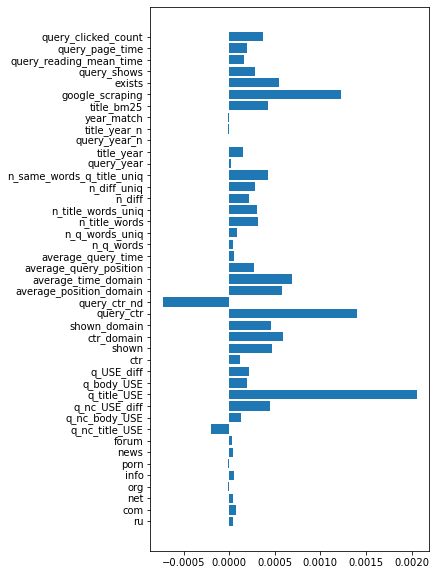

In [119]:
plt.figure(figsize=(5, 10))
plt.barh(train.drop(columns=['q_text', 'title_text']).columns[3:], model_yeti.get_feature_importance(pools['train']))

<BarContainer object of 43 artists>

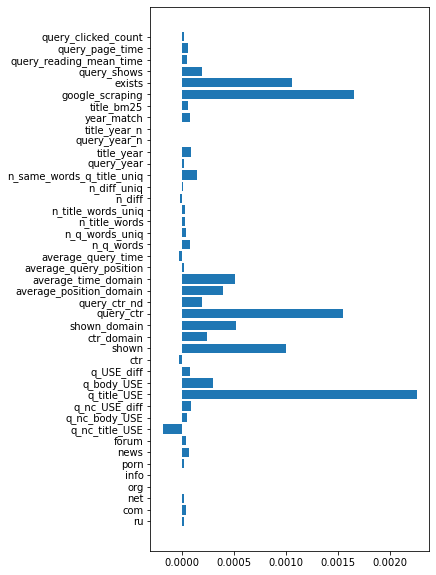

In [118]:
plt.figure(figsize=(5, 10))
plt.barh(train.drop(columns=['q_text', 'title_text']).columns[3:], model_stochastic.get_feature_importance(pools['train']))

<BarContainer object of 43 artists>

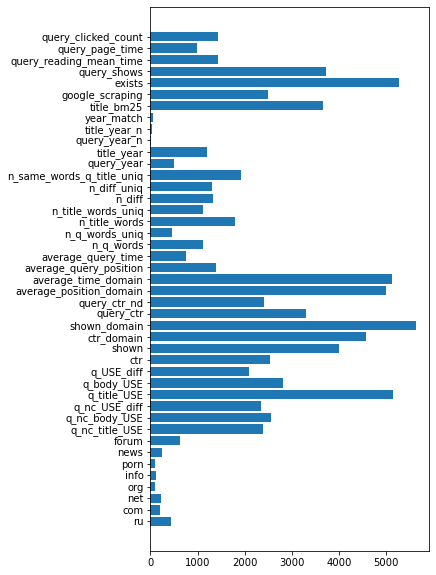

In [117]:
plt.figure(figsize=(5, 10))
plt.barh(train.drop(columns=['q_text', 'title_text']).columns[3:], model_lgbm.feature_importances_)

In [ ]:
model_yeti.calc_feature_statistics(pools['train'])